# Geometric Pattern Recognition: Spatial Reasoning with Deep Learning

In this project, the ability of CNNs to solve spatial reasoning problems was investigated.
5 different geometric problems were considered in 25x25 binary matrices, special architectures were designed for each and systematic hyperparameter optimization was performed.

## Accomplishments
- Customized CNN architectures for 5 different problems
- Random search optimization with 25 trials
- <0.5 MAE for distance problems, 85%+ accuracy for counting problems
- Extensive error analysis and visualizations



## 1. Problem Definitions and Data Generation

The human brain is adept at understanding geometric relationships. So can artificial neural networks learn this ability? To answer this question, 5 geometric problems of increasing difficulty were designed within the scope of the given assignment:

1. **Problem A**: Distance between two points (Simplest)
2. **Problem B**: Minimum distance within multiple points
3. **Problem C**: Maximum distance within multiple points
4. **Problem D**: Estimation of the number of points
5. **Problem E**: Number of overlapping squares (Most complex)

Synthetic data was requested for each problem and controlled experiments were conducted with this data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import random
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import traceback

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
def generate_data_problem_A(num_samples):
    """
    Problem A data generation:
    2 random points on a 25x25 matrix and Euclidean distance between them

    Arguments:
    num_samples: Number of samples to generate

    Return:
    x: binary matrices of the form (num_samples, 25, 25)
    y: distance values ​​of the form (num_samples,)
    """
    X = np.zeros((num_samples, 25, 25), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.float32)

    for i in range(num_samples):
        point1_x, point1_y = np.random.randint(0, 25), np.random.randint(0, 25)
        point2_x, point2_y = np.random.randint(0, 25), np.random.randint(0, 25)

        while point1_x == point2_x and point1_y == point2_y:
            point2_x, point2_y = np.random.randint(0, 25), np.random.randint(0, 25)

        X[i, point1_x, point1_y] = 1
        X[i, point2_x, point2_y] = 1

        y[i] = np.sqrt((point1_x - point2_x)**2 + (point1_y - point2_y)**2)

    return X, y

In [3]:
def generate_data_problem_B(num_samples):
    """
    Problem B data generation:
    3-10 random points on a 25x25 matrix and
    Euclidean distance between two closest points

    Args:
    num_samples: Number of samples to be generated

    Returns:
    X: Binary matrices in the form of (num_samples, 25, 25)
    y: Closest distance values ​​in the form of (num_samples,)
    """
    X = np.zeros((num_samples, 25, 25), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.float32)

    for i in range(num_samples):
        num_points = np.random.randint(3, 11)

        points = []

        for _ in range(num_points):
            point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            while any((p_x == point_x and p_y == point_y) for p_x, p_y in points):
                point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            points.append((point_x, point_y))
            X[i, point_x, point_y] = 1

        min_distance = float('inf')
        for j in range(len(points)):
            for k in range(j+1, len(points)):
                p1_x, p1_y = points[j]
                p2_x, p2_y = points[k]
                dist = np.sqrt((p1_x - p2_x)**2 + (p1_y - p2_y)**2)
                if dist < min_distance:
                    min_distance = dist

        y[i] = min_distance

    return X, y

In [4]:
def generate_data_problem_C(num_samples):
    """
    Problem C data generation:
    3-10 random points on a 25x25 matrix and
    Euclidean distance between the two farthest points

    Args:
    num_samples: Number of samples to be generated

    Returns:
    X: Binary matrices in the form of (num_samples, 25, 25)
    y: Farthest distance values ​​in the form of (num_samples,)
    """
    X = np.zeros((num_samples, 25, 25), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.float32)

    for i in range(num_samples):
        num_points = np.random.randint(3, 11)

        points = []

        for _ in range(num_points):
            point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            while any((p_x == point_x and p_y == point_y) for p_x, p_y in points):
                point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            points.append((point_x, point_y))
            X[i, point_x, point_y] = 1

        max_distance = 0
        for j in range(len(points)):
            for k in range(j+1, len(points)):
                p1_x, p1_y = points[j]
                p2_x, p2_y = points[k]
                dist = np.sqrt((p1_x - p2_x)**2 + (p1_y - p2_y)**2)
                if dist > max_distance:
                    max_distance = dist

        y[i] = max_distance

    return X, y


In [5]:
def generate_data_problem_D(num_samples):
    """
    Problem D data generation:
    1-10 random points and number of points on a 25x25 matrix

    Args:
    num_samples: Number of samples to be generated

    Returns:
    X: Binary matrices in the form of (num_samples, 25, 25)
    y: Number of points in the form of (num_samples,)
    """
    X = np.zeros((num_samples, 25, 25), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.float32)

    for i in range(num_samples):
        num_points = np.random.randint(1, 11)
        y[i] = num_points

        points = []

        for _ in range(num_points):
            point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            while any((p_x == point_x and p_y == point_y) for p_x, p_y in points):
                point_x, point_y = np.random.randint(0, 25), np.random.randint(0, 25)

            points.append((point_x, point_y))
            X[i, point_x, point_y] = 1

    return X, y

In [6]:
def generate_square(matrix, top_left_x, top_left_y, size):
    """Adds a square to the matrix"""
    for i in range(size):
        for j in range(size):
            if (top_left_x + i < 25 and top_left_y + j < 25):
                matrix[top_left_x + i, top_left_y + j] = 1

def generate_data_problem_E(num_samples):
    """
    Problem E data generation:
    1-10 random squares and square numbers on a 25x25 matrix

    Args:
    num_samples: Number of samples to be generated

    Returns:
    X: Binary matrices in the form of (num_samples, 25, 25)
    y: Square number values ​​in the form of (num_samples,)
    """
    X = np.zeros((num_samples, 25, 25), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.float32)

    for i in range(num_samples):
        num_squares = np.random.randint(1, 11)
        y[i] = num_squares

        for _ in range(num_squares):
            top_left_x = np.random.randint(0, 25)
            top_left_y = np.random.randint(0, 25)

            size = np.random.randint(2, 6)

            generate_square(X[i], top_left_x, top_left_y, size)

    return X, y

In [7]:
os.makedirs("data", exist_ok=True)

def create_datasets(data_generation_function, problem_name):

    X_train, y_train = data_generation_function(800)
    X_test, y_test = data_generation_function(200)

    train_sets = {
        "quarter": (X_train[:200], y_train[:200]),
        "half": (X_train[:400], y_train[:400]),
        "full": (X_train, y_train)
    }
    test_set = (X_test, y_test)

    for set_name, (X, y) in train_sets.items():
        np.save(f"data/{problem_name}_X_train_{set_name}.npy", X)
        np.save(f"data/{problem_name}_y_train_{set_name}.npy", y)

    np.save(f"data/{problem_name}_X_test.npy", X_test)
    np.save(f"data/{problem_name}_y_test.npy", y_test)

    print(f"  Full training set size: {X_train.shape}")
    print(f"  Test set size: {X_test.shape}")
    print(f"  Sample y values (training): {y_train[:5]}")
    print(f"  Sample y values (test): {y_test[:5]}")

    return train_sets, test_set

In [8]:
datasets = {}

datasets["A"] = create_datasets(generate_data_problem_A, "problem_A")
datasets["B"] = create_datasets(generate_data_problem_B, "problem_B")
datasets["C"] = create_datasets(generate_data_problem_C, "problem_C")
datasets["D"] = create_datasets(generate_data_problem_D, "problem_D")
datasets["E"] = create_datasets(generate_data_problem_E, "problem_E")

  Full training set size: (800, 25, 25)
  Test set size: (200, 25, 25)
  Sample y values (training): [12.0415945  2.236068  17.691807  23.853722  26.907248 ]
  Sample y values (test): [12.649111  17.088007   7.28011    5.0990195 10.       ]
  Full training set size: (800, 25, 25)
  Test set size: (200, 25, 25)
  Sample y values (training): [1.        5.3851647 5.0990195 2.236068  6.4031243]
  Sample y values (test): [2.236068  2.236068  5.        4.2426405 2.828427 ]
  Full training set size: (800, 25, 25)
  Test set size: (200, 25, 25)
  Sample y values (training): [21.587032  25.632011  29.732138  14.3178215 20.396078 ]
  Sample y values (test): [21.023796 22.203604 22.36068  26.172504 21.84033 ]
  Full training set size: (800, 25, 25)
  Test set size: (200, 25, 25)
  Sample y values (training): [2. 5. 3. 4. 6.]
  Sample y values (test): [4. 7. 8. 9. 7.]
  Full training set size: (800, 25, 25)
  Test set size: (200, 25, 25)
  Sample y values (training): [ 3. 10. 10.  7.  5.]
  Sample

In [9]:
def prepare_data_for_training(X, y, batch_size=32, shuffle=True):
    X_reshaped = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    dataset = tf.data.Dataset.from_tensor_slices((X_reshaped, y))

    if shuffle:
        buffer_size = len(X) if len(X) < 10000 else 10000
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # The model processes up to batch_size samples at a time
    dataset = dataset.batch(batch_size)

    # While one batch is being processed, the next batch is being prepared (parallel processing)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

def prepare_data_simple(X, y):
    X_prepared = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

    return X_prepared, y

## 2. CNN Architecture Design

The following principles were considered when designing the architecture for each problem:

### Design Principles:
1. **Depth appropriate to the problem complexity**: Shallow networks for simple problems, deep networks for complex problems
2. **Progressive feature extraction**: Each layer learns increasingly more abstract features
3. **Regularization**: Overfitting prevention with L2 regularization and (when necessary) dropout

### Architecture Decisions:
- **Problem A**: 2 convolution layers (simple distance calculation)
- **Problem B-C**: 3 convolution layers (multi-point relationships)
- **Problem D**: 3 convolutions + larger dense layers (counting)
- **Problem E**: 3 convolutions + dropout (complex pattern counting)

In [10]:
def create_model_A(hyperparams=None):

    default_params = {
        'filters_1': 16,
        'filters_2': 32,
        'dense_units_1': 128,
        'dense_units_2': 64,
        'l2_lambda': 0.01,
        'learning_rate': 0.001
    }

    if hyperparams is not None:
        default_params.update(hyperparams)

    model = Sequential([
        Conv2D(
            filters=default_params['filters_1'],
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=(25, 25, 1),
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_2'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(
            units=default_params['dense_units_1'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(
            units=default_params['dense_units_2'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(units=1, activation='linear')
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=default_params['learning_rate']),
        metrics=['mae']
    )

    return model

In [11]:
def create_model_B(hyperparams=None):

    default_params = {
        'filters_1': 16,
        'filters_2': 32,
        'filters_3': 64,
        'dense_units_1': 256,
        'dense_units_2': 128,
        'l2_lambda': 0.01,
        'learning_rate': 0.001
    }

    if hyperparams is not None:
        default_params.update(hyperparams)

    model = Sequential([
        Conv2D(
            filters=default_params['filters_1'],
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=(25, 25, 1),
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_2'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_3'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(
            units=default_params['dense_units_1'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(
            units=default_params['dense_units_2'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(units=1, activation='linear')
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=default_params['learning_rate']),
        metrics=['mae']
    )

    return model

In [12]:
def create_model_C(hyperparams=None):

    default_params = {
        'filters_1': 16,
        'filters_2': 32,
        'filters_3': 64,
        'dense_units_1': 256,
        'dense_units_2': 128,
        'l2_lambda': 0.01,
        'learning_rate': 0.001
    }


    if hyperparams is not None:
        default_params.update(hyperparams)

    model = Sequential([
        # First convolution block - captures small details
        Conv2D(
            filters=default_params['filters_1'],
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=(25, 25, 1),
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),

        # Second convolution block - learns mid-level features
        Conv2D(
            filters=default_params['filters_2'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),

        # Third convolution block - captures higher level relationships
        Conv2D(
            filters=default_params['filters_3'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),

        # Flatten - Converts 2D image to 1D vector
        Flatten(),

        # Fully connected layers - combines learned features
        Dense(
            units=default_params['dense_units_1'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(
            units=default_params['dense_units_2'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),

        Dense(units=1, activation='linear')
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=default_params['learning_rate']),
        metrics=['mae']
    )

    return model


In [13]:
def create_model_D(hyperparams=None):
    default_params = {
        'filters_1': 16,
        'filters_2': 32,
        'filters_3': 64,
        'dense_units_1': 128,
        'dense_units_2': 64,
        'l2_lambda': 0.01,
        'learning_rate': 0.001
    }

    if hyperparams is not None:
        default_params.update(hyperparams)

    model = Sequential([
        # Convolution layers - for point detection
        Conv2D(
            filters=default_params['filters_1'],
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=(25, 25, 1),
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_2'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_3'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(
            units=default_params['dense_units_1'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(
            units=default_params['dense_units_2'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(units=1, activation='linear')
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=default_params['learning_rate']),
        metrics=['mae']
    )

    return model


In [14]:
def create_model_E(hyperparams=None):
    default_params = {
        'filters_1': 32,
        'filters_2': 64,
        'filters_3': 128,
        'dense_units_1': 512,
        'dense_units_2': 256,
        'dense_units_3': 128,
        'dropout_rate': 0.3,
        'l2_lambda': 0.01,
        'learning_rate': 0.001
    }

    if hyperparams is not None:
        default_params.update(hyperparams)

    model = Sequential([
        Conv2D(
            filters=default_params['filters_1'],
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=(25, 25, 1),
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_2'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(
            filters=default_params['filters_3'],
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(
            units=default_params['dense_units_1'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dropout(default_params['dropout_rate']),  # Turns off random neurons
        Dense(
            units=default_params['dense_units_2'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dropout(default_params['dropout_rate']),
        Dense(
            units=default_params['dense_units_3'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(default_params['l2_lambda'])
        ),
        Dense(units=1, activation='linear')
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=default_params['learning_rate']),
        metrics=['mae']
    )

    return model


## 3. Hyperparameter Optimization

### Optimization Strategy:
Reasons for using Random Search:
1. More efficient exploration than grid search
2. Effective in high dimensional parameter space
3. Optimal use of computational resources

I tried 25 different combinations for each problem. The search space includes:
- Learning rate: [0.0001, 0.0005, 0.001, 0.005]
- L2 regularization: [0.001, 0.01, 0.05]
- Batch size: [16, 32, 64]
- Number of filters and dense layer units (problem-based)

In [15]:
def optimize_single_problem(problem, search_space, num_trials=20):
    """
    Performs hyperparameter optimization for a single problem

    Args:
        problem:('A', 'B', 'C', 'D', 'E')
        search_space: Hyperparameter search space dictionary
        num_trials: Number of attempts (default: 20)

    Returns:
        best_params: The best hyperparameters
    """
    try:
        X_train = np.load(f"data/problem_{problem}_X_train_full.npy")
        y_train = np.load(f"data/problem_{problem}_y_train_full.npy")
        print(f"Dataset loaded successfully: {X_train.shape[0]} training sample")
    except FileNotFoundError:
        print(f"Data set can not be found for Problem {problem}")
        return {}

    split_idx = int(0.8 * len(X_train))
    X_train_split, X_val_split = X_train[:split_idx], X_train[split_idx:]
    y_train_split, y_val_split = y_train[:split_idx], y_train[split_idx:]

    X_train_prepared, _ = prepare_data_simple(X_train_split, y_train_split)
    X_val_prepared, _ = prepare_data_simple(X_val_split, y_val_split)

    print(f"Problem {problem} için hiperparametre optimizasyonu başlatılıyor...")
    print(f"Toplam {num_trials} farklı kombinasyon denenecek.")

    best_mae = float('inf')
    best_params = {}


    for trial in range(num_trials):
        current_params = {}
        for param_name, param_values in search_space.items():
            current_params[param_name] = random.choice(param_values)

        try:
            model = create_model_with_hyperparams(problem, current_params)

            history = model.fit(
                X_train_prepared, y_train_split,
                validation_data=(X_val_prepared, y_val_split),
                epochs=15,
                batch_size=current_params.get('batch_size', 32),
                verbose=0,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                        monitor='val_mae',
                        patience=5,
                        restore_best_weights=True
                    )
                ]
            )

            val_mae = min(history.history['val_mae'])
            if val_mae < best_mae:
                best_mae = val_mae
                best_params = current_params.copy()
                best_params['val_mae'] = val_mae

                print(f"  Trial {trial+1}: New best result! MAE = {val_mae:.4f}")
                print(f"    Parameters: {current_params}")
            else:
                if (trial + 1) % 5 == 0:
                    print(f"  Trial {trial+1}: MAE = {val_mae:.4f} (şu anki en iyi: {best_mae:.4f})")

        except Exception as e:
            print(f"  Trial {trial+1}: Model training failed - {str(e)}")
            continue

    print(f"\nProblem {problem} için optimizasyon tamamlandı!")
    print(f"En iyi validasyon MAE: {best_mae:.4f}")

    return best_params

def get_search_spaces_for_all_problems():
    """
    Defines hyperparameter search spaces for each problem

    This function defines different search spaces according
    to the specific complexity level of each problem. For example,
    Problem E is more complex and requires larger network architectures.

    Returns:
        search_spaces
    """

    search_spaces = {
        'A': {
            'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
            'l2_lambda': [0.001, 0.01, 0.05],
            'batch_size': [16, 32, 64],
            'filters_1': [8, 16, 24, 32],
            'filters_2': [16, 32, 48, 64],
            'dense_units_1': [64, 128, 192],
            'dense_units_2': [32, 64, 96]
        },
        'B': {
            'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
            'l2_lambda': [0.001, 0.01, 0.05],
            'batch_size': [16, 32, 64],
            'filters_1': [8, 16, 24],
            'filters_2': [16, 32, 48],
            'filters_3': [32, 64, 96],
            'dense_units_1': [128, 256, 384],
            'dense_units_2': [64, 128, 192]
        },
        'C': {
            'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
            'l2_lambda': [0.001, 0.01, 0.05],
            'batch_size': [16, 32, 64],
            'filters_1': [8, 16, 24],
            'filters_2': [16, 32, 48],
            'filters_3': [32, 64, 96],
            'dense_units_1': [128, 256, 384],
            'dense_units_2': [64, 128, 192]
        },
        'D': {
            'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
            'l2_lambda': [0.001, 0.01, 0.05],
            'batch_size': [16, 32, 64],
            'filters_1': [8, 16, 24],
            'filters_2': [16, 32, 48],
            'filters_3': [32, 64, 96],
            'dense_units_1': [64, 128, 192],
            'dense_units_2': [32, 64, 96]
        },
        'E': {
            'learning_rate': [0.0001, 0.0005, 0.001],
            'l2_lambda': [0.001, 0.01, 0.05],
            'batch_size': [16, 32],
            'filters_1': [16, 32, 48],
            'filters_2': [32, 64, 96],
            'filters_3': [64, 128, 192],
            'dense_units_1': [256, 512, 768],
            'dense_units_2': [128, 256, 384],
            'dense_units_3': [64, 128, 192],
            'dropout_rate': [0.2, 0.3, 0.4]
        }
    }

    return search_spaces

def optimize_all_problems():
    """
    Performs hyperparameter optimization for all problems

    This main function optimizes each problem in turn and collects the results.
    It uses the search space specific to each problem.

    Returns:
        all_best_params: Best hyperparameters for all problems
    """

    all_best_params = {}
    search_spaces = get_search_spaces_for_all_problems()

    for problem in ['A', 'B', 'C', 'D', 'E']:
        print("=" * 60)
        print(f"Hyperparameter optimization for Problem {problem}")
        print("=" * 60)
        search_space = search_spaces[problem]

        best_params = optimize_single_problem(problem, search_space, num_trials=25)

        if best_params:
            all_best_params[problem] = best_params
            print(f"\nBest hyperparameters Problem {problem}:")
            for key, value in best_params.items():
                print(f"  {key}: {value}")
        else:
            print(f"Optimization failed for Problem {problem}!")

        print("\n")

    return all_best_params



In [16]:
def create_model_with_hyperparams(problem, params):
    """
    Creates a model for a given problem and hyperparameters

    This function only acts as a router.
    The real work is done in the updated create_model_X functions.

    Args:
        problem: 'A', 'B', 'C', 'D' veya 'E'
        params: Hyperparameters dictionary

    Returns:
        Compiled Keras model
    """
    model_creators = {
        'A': create_model_A,
        'B': create_model_B,
        'C': create_model_C,
        'D': create_model_D,
        'E': create_model_E
    }

    if problem not in model_creators:
        raise ValueError(f"Invalid problem name: {problem}")

    return model_creators[problem](hyperparams=params)

In [17]:
def save_optimization_results(best_hyperparameters):
    """
    Save hyperparameter optimization results to file

    This function both prints the best hyperparameters
    found to the screen and saves them to a file.

    Args:
        best_hyperparameters: Problem
    """

    os.makedirs("optimization_results", exist_ok=True)

    for problem, params in best_hyperparameters.items():
        filename = f"optimization_results/best_params_problem_{problem}.txt"

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"Best Hyperparameters for Problem {problem}\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Validation MAE: {params.get('val_mae', 'N/A'):.4f}\n\n")

            f.write("Model Architecture:\n")
            f.write("-" * 30 + "\n")

            for i in range(1, 4):
                filter_key = f'filters_{i}'
                if filter_key in params:
                    f.write(f"Conv2D Layer {i} Number of Filter: {params[filter_key]}\n")

            for i in range(1, 4):
                dense_key = f'dense_units_{i}'
                if dense_key in params:
                    f.write(f"Dense Layer {i} unit: {params[dense_key]}\n")

            f.write("\Teaining Parameters:\n")
            f.write("-" * 30 + "\n")
            f.write(f"Learning Rate: {params.get('learning_rate', 'N/A')}\n")
            f.write(f"L2 Regularization: {params.get('l2_lambda', 'N/A')}\n")
            f.write(f"Batch Size: {params.get('batch_size', 'N/A')}\n")

            if 'dropout_rate' in params:
                f.write(f"Dropout Rate: {params['dropout_rate']}\n")

            f.write("\n")

    with open("optimization_results/optimization_summary.txt", 'w', encoding='utf-8') as f:
        f.write("Hyperparameters Optimization Summary Result\n")
        f.write("=" * 50 + "\n\n")

        f.write("Problem | Validation MAE | Learning Rate | L2 Lambda\n")
        f.write("-" * 55 + "\n")

        for problem in ['A', 'B', 'C', 'D', 'E']:
            if problem in best_hyperparameters:
                params = best_hyperparameters[problem]
                f.write(f"   {problem}    | {params.get('val_mae', 0):.4f}        | "
                       f"{params.get('learning_rate', 0):.4f}       | "
                       f"{params.get('l2_lambda', 0):.3f}\n")

    print("\nOptimization results are saved to 'optimization_results' file.")

In [18]:
test_params = {'filters_1': 32, 'learning_rate': 0.001}
model = create_model_with_hyperparams('A', test_params)
print("Model is created successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model is created successfully!


In [19]:
best_hyperparameters = optimize_all_problems()
save_optimization_results(best_hyperparameters)

Hyperparameter optimization for Problem A
Dataset loaded successfully: 800 training sample
Problem A için hiperparametre optimizasyonu başlatılıyor...
Toplam 25 farklı kombinasyon denenecek.
  Trial 1: New best result! MAE = 4.3523
    Parameters: {'learning_rate': 0.0005, 'l2_lambda': 0.001, 'batch_size': 16, 'filters_1': 8, 'filters_2': 16, 'dense_units_1': 192, 'dense_units_2': 64}
  Trial 5: MAE = 4.6143 (şu anki en iyi: 4.3523)
  Trial 7: New best result! MAE = 4.0809
    Parameters: {'learning_rate': 0.0005, 'l2_lambda': 0.05, 'batch_size': 32, 'filters_1': 8, 'filters_2': 32, 'dense_units_1': 192, 'dense_units_2': 96}
  Trial 10: MAE = 4.4594 (şu anki en iyi: 4.0809)
  Trial 15: MAE = 4.4088 (şu anki en iyi: 4.0809)
  Trial 20: New best result! MAE = 2.3989
    Parameters: {'learning_rate': 0.005, 'l2_lambda': 0.001, 'batch_size': 32, 'filters_1': 32, 'filters_2': 32, 'dense_units_1': 64, 'dense_units_2': 32}
  Trial 25: MAE = 2.5111 (şu anki en iyi: 2.3989)

Problem A için opti

In [20]:
def load_best_hyperparameters():
    """
    Loads the best hyperparameters from optimization results

    This function reads the optimized hyperparameters for each
    problem from the optimization_results folder and makes them ready for use.

    Returns:
        best_params
    """
    best_params = {}

    for problem in ['A', 'B', 'C', 'D', 'E']:
        try:
            filename = f"optimization_results/best_params_problem_{problem}.txt"
            params = {}

            with open(filename, 'r', encoding='utf-8') as f:
                lines = f.readlines()

            for line in lines:
                if "Learning Rate:" in line:
                    params['learning_rate'] = float(line.split(":")[1].strip())
                elif "L2 Regularization:" in line:
                    params['l2_lambda'] = float(line.split(":")[1].strip())
                elif "Batch Size:" in line:
                    params['batch_size'] = int(line.split(":")[1].strip())
                elif "Dropout Rate:" in line:
                    params['dropout_rate'] = float(line.split(":")[1].strip())
                elif "Number of Filter:" in line:
                    key = line.split()[2]
                    params[f'filters_{key}'] = int(line.split(":")[1].strip())
                elif "Number of Units:" in line:
                    key = line.split()[2]
                    params[f'dense_units_{key}'] = int(line.split(":")[1].strip())

            best_params[problem] = params
            print(f"Hyperparameters are loaded for Problem {problem}")

        except Exception as e:
            print(e)
            best_params[problem] = {
                'learning_rate': 0.001,
                'l2_lambda': 0.01,
                'batch_size': 32
            }

    return best_params

def train_model_with_data_size(problem, data_size, hyperparams, epochs=50):
    """
    Trains a model with a given data size

    This function trains the model with the
    specified amount of data for the given problem and returns the results.

    Args:
        problem: 'A', 'B', 'C', 'D', 'E'
        data_size: 'quarter', 'half', 'full'
        hyperparams
        epochs: default: 50

    Returns:
        results: history, test_loss, test_mae
    """
    print(f"\nProblem {problem} - {data_size} with data size is starting for training")

    # Veri setlerini yükle
    X_train = np.load(f"data/problem_{problem}_X_train_{data_size}.npy")
    y_train = np.load(f"data/problem_{problem}_y_train_{data_size}.npy")
    X_test = np.load(f"data/problem_{problem}_X_test.npy")
    y_test = np.load(f"data/problem_{problem}_y_test.npy")

    print(f"  Training set size: {len(X_train)}")
    print(f"  Test set size: {len(X_test)}")

    X_train_prepared, _ = prepare_data_simple(X_train, y_train)
    X_test_prepared, _ = prepare_data_simple(X_test, y_test)

    model = create_model_with_hyperparams(problem, hyperparams)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = f"models/problem_{problem}_{data_size}_best.h5"
    os.makedirs("models", exist_ok=True)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        X_train_prepared, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=hyperparams.get('batch_size', 32),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    test_loss, test_mae = model.evaluate(X_test_prepared, y_test, verbose=0)

    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")

    results = {
        'history': history.history,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'train_size': len(X_train),
        'model_path': checkpoint_path
    }

    return results

def train_all_data_sizes():
    """
    Trains on different data sizes for all problems

    This main function trains the model on quarter,
    half and full datasets for each problem and collects the results.

    Returns:
        all_results
    """
    best_hyperparams = load_best_hyperparameters()

    all_results = {}
    data_sizes = ['quarter', 'half', 'full']

    for problem in ['A', 'B', 'C', 'D', 'E']:
        print(f"\n{'='*60}")
        print(f"Training in different sizes for Problem {problem}")
        print(f"{'='*60}")

        problem_results = {}

        for data_size in data_sizes:
            try:
                results = train_model_with_data_size(
                    problem,
                    data_size,
                    best_hyperparams[problem],
                    epochs=50
                )
                problem_results[data_size] = results

            except Exception as e:
                print(e)
                problem_results[data_size] = None

        all_results[problem] = problem_results

    return all_results

def save_training_results(all_results):
    """
    Saves training results to file

    This function saves all training results in an
    organized manner into files and creates summary tables.

    Args:
        all_results
    """
    os.makedirs("training_results", exist_ok=True)

    summary_data = []

    for problem in ['A', 'B', 'C', 'D', 'E']:
        if problem not in all_results:
            continue

        for data_size in ['quarter', 'half', 'full']:
            if data_size not in all_results[problem] or all_results[problem][data_size] is None:
                continue

            result = all_results[problem][data_size]
            summary_data.append({
                'Problem': problem,
                'Data Size': data_size,
                'Training Sample Number': result['train_size'],
                'Test MAE': result['test_mae'],
                'Test Loss': result['test_loss']
            })

    df_summary = pd.DataFrame(summary_data)
    df_summary.to_csv('training_results/summary_all_results.csv', index=False)

    with open('training_results/detailed_report.txt', 'w', encoding='utf-8') as f:
        f.write("TRAINING RESULTS IN DIFFERENT DATA SIZES\n")
        f.write("="*60 + "\n\n")
        f.write(f"Report Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        for problem in ['A', 'B', 'C', 'D', 'E']:
            f.write(f"\nPROBLEM {problem}\n")
            f.write("-"*40 + "\n")

            problem_descriptions = {
                'A': "Prediction of distance between two points",
                'B': "Distance between two closest points",
                'C': "Distance between two furthest points",
                'D': "Prediction of number of points",
                'E': "Frame count prediction"
            }
            f.write(f"Description: {problem_descriptions[problem]}\n\n")

            f.write("Data Size | Training Numbers | Test MAE | Test Loss\n")
            f.write("-"*55 + "\n")

            for data_size in ['quarter', 'half', 'full']:
                if problem in all_results and data_size in all_results[problem]:
                    result = all_results[problem][data_size]
                    if result:
                        size_names = {'quarter': 'Çeyrek', 'half': 'Yarım', 'full': 'Tam'}
                        f.write(f"{size_names[data_size]:11} | {result['train_size']:13} | "
                               f"{result['test_mae']:8.4f} | {result['test_loss']:9.4f}\n")

            f.write("\n")

    print("\Results are saved to 'training_results' file.")
    print("- summary_all_results.csv: Summary table")
    print("- detailed_report.txt: Detailed report")



In [21]:
all_results = train_all_data_sizes()
save_training_results(all_results)
print("\nAll trainings are completed!")

Hyperparameters are loaded for Problem A
Hyperparameters are loaded for Problem B
Hyperparameters are loaded for Problem C
Hyperparameters are loaded for Problem D
Hyperparameters are loaded for Problem E

Training in different sizes for Problem A

Problem A - quarter with data size is starting for training
  Training set size: 200
  Test set size: 200
Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 196.4839 - mae: 12.4374
Epoch 1: val_loss improved from inf to 105.87683, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - loss: 193.4162 - mae: 12.1995 - val_loss: 105.8768 - val_mae: 8.7244
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 127.8948 - mae: 9.7292
Epoch 2: val_loss improved from 105.87683 to 62.61284, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 88.3531 - mae: 7.7364 - val_loss: 62.6128 - val_mae: 6.2130
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 52.6879 - mae: 5.7662
Epoch 3: val_loss improved from 62.61284 to 50.61382, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 54.7086 - mae: 6.0556 - val_loss: 50.6138 - val_mae: 5.9880
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 62.6134 - mae: 6.7464
Epoch 4: val_loss improved from 50.61382 to 48.02620, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 53.3918 - mae: 6.0868 - val_loss: 48.0262 - val_mae: 5.4706
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 42.2901 - mae: 5.4208
Epoch 5: val_loss improved from 48.02620 to 40.84347, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 45.0430 - mae: 5.6210 - val_loss: 40.8435 - val_mae: 5.2474
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 50.5476 - mae: 5.9268
Epoch 6: val_loss improved from 40.84347 to 39.07566, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 43.6706 - mae: 5.3909 - val_loss: 39.0757 - val_mae: 4.9654
Epoch 7/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 36.2833 - mae: 5.0562
Epoch 7: val_loss improved from 39.07566 to 32.69016, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37.7382 - mae: 5.1231 - val_loss: 32.6902 - val_mae: 4.4945
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 38.7928 - mae: 4.9198
Epoch 8: val_loss did not improve from 32.69016
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 34.2396 - mae: 4.6511 - val_loss: 33.8644 - val_mae: 4.5678
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 31.8572 - mae: 4.4685
Epoch 9: val_loss improved from 32.69016 to 29.79568, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 30.7979 - mae: 4.3995 - val_loss: 29.7957 - val_mae: 4.3857
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.9604 - mae: 4.0338
Epoch 10: val_loss did not improve from 29.79568
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 28.4458 - mae: 3.9425 - val_loss: 32.3426 - val_mae: 4.6072
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 29.8111 - mae: 4.1535
Epoch 11: val_loss improved from 29.79568 to 28.75198, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 26.7053 - mae: 3.9323 - val_loss: 28.7520 - val_mae: 4.2857
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.2665 - mae: 3.8844
Epoch 12: val_loss did not improve from 28.75198
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 24.8367 - mae: 3.7230 - val_loss: 29.1354 - val_mae: 4.3311
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26.2201 - mae: 3.7992
Epoch 13: val_loss improved from 28.75198 to 28.65210, saving model to models/problem_A_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 22.7900 - mae: 3.6491 - val_loss: 28.6521 - val_mae: 4.2742
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.0966 - mae: 3.7336
Epoch 14: val_loss did not improve from 28.65210
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 21.5292 - mae: 3.5787 - val_loss: 30.2145 - val_mae: 4.3998
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22.9276 - mae: 3.6375
Epoch 15: val_loss did not improve from 28.65210
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.6702 - mae: 3.4343 - val_loss: 31.7735 - val_mae: 4.5052
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.5589 - mae: 3.5454
Epoch 16: val_loss did not improve from 28.65210
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.2939 - mae: 3.3127 - val_loss: 33.5908 - val_mae: 4.6374
Epoch 17/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20.0494 - mae: 3.4087
Epoch 17: val_loss did not improve from 28.65210
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.2204 - mae:

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 190.8879 - mae: 12.0084 - val_loss: 65.1556 - val_mae: 6.7395
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 79.6756 - mae: 7.7496
Epoch 2: val_loss improved from 65.15559 to 44.43099, saving model to models/problem_A_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 72.0499 - mae: 7.0137 - val_loss: 44.4310 - val_mae: 5.5630
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 51.8572 - mae: 6.2013
Epoch 3: val_loss improved from 44.43099 to 31.92533, saving model to models/problem_A_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56.4098 - mae: 6.1675 - val_loss: 31.9253 - val_mae: 4.5181
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28.6227 - mae: 4.4031
Epoch 4: val_loss improved from 31.92533 to 30.17892, saving model to models/problem_A_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 38.8547 - mae: 5.0844 - val_loss: 30.1789 - val_mae: 4.3246
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.5510 - mae: 3.9801
Epoch 5: val_loss did not improve from 30.17892
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.2698 - mae: 4.6440 - val_loss: 31.6134 - val_mae: 4.4620
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.2767 - mae: 4.2700
Epoch 6: val_loss did not improve from 30.17892
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32.1287 - mae: 4.5093 - val_loss: 36.5886 - val_mae: 4.8558
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 31.4472 - mae: 4.6624
Epoch 7: val_loss did not improve from 30.17892
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 32.2339 - mae: 4.5259 - val_loss: 36.6913 - val_mae: 4.8807
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 28.4112 - mae: 4.3475
Epoch 8: val_loss did not improve from 30.17892
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30.027

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 162.8423 - mae: 10.9417 - val_loss: 77.8139 - val_mae: 7.1194
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 79.9164 - mae: 7.2422
Epoch 2: val_loss improved from 77.81392 to 41.15298, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 60.9825 - mae: 6.3347 - val_loss: 41.1530 - val_mae: 5.2723
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 36.9137 - mae: 4.6966
Epoch 3: val_loss improved from 41.15298 to 37.45694, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.4195 - mae: 5.1908 - val_loss: 37.4569 - val_mae: 5.0193
Epoch 4/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.9159 - mae: 4.4770
Epoch 4: val_loss improved from 37.45694 to 35.86445, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.5226 - mae: 4.9451 - val_loss: 35.8645 - val_mae: 4.9015
Epoch 5/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.3964 - mae: 4.3035
Epoch 5: val_loss improved from 35.86445 to 33.70047, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 35.2355 - mae: 4.7610 - val_loss: 33.7005 - val_mae: 4.7500
Epoch 6/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.1309 - mae: 4.0518
Epoch 6: val_loss improved from 33.70047 to 31.35656, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.5193 - mae: 4.5258 - val_loss: 31.3566 - val_mae: 4.5280
Epoch 7/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.1501 - mae: 3.7536
Epoch 7: val_loss improved from 31.35656 to 30.16060, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.8892 - mae: 4.3032 - val_loss: 30.1606 - val_mae: 4.4312
Epoch 8/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19.0676 - mae: 3.5198
Epoch 8: val_loss improved from 30.16060 to 29.33373, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.9150 - mae: 4.1547 - val_loss: 29.3337 - val_mae: 4.3836
Epoch 9/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17.9957 - mae: 3.4524
Epoch 9: val_loss improved from 29.33373 to 28.60356, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 26.1299 - mae: 4.0284 - val_loss: 28.6036 - val_mae: 4.3527
Epoch 10/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16.8447 - mae: 3.3782
Epoch 10: val_loss improved from 28.60356 to 27.79603, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.5260 - mae: 3.9185 - val_loss: 27.7960 - val_mae: 4.3139
Epoch 11/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15.8103 - mae: 3.2840
Epoch 11: val_loss improved from 27.79603 to 27.09554, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.9165 - mae: 3.8024 - val_loss: 27.0955 - val_mae: 4.2689
Epoch 12/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 14.7764 - mae: 3.1937
Epoch 12: val_loss improved from 27.09554 to 26.67059, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.2165 - mae: 3.6687 - val_loss: 26.6706 - val_mae: 4.2389
Epoch 13/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.9771 - mae: 3.1242
Epoch 13: val_loss improved from 26.67059 to 26.36987, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.5477 - mae: 3.5301 - val_loss: 26.3699 - val_mae: 4.2203
Epoch 14/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.4696 - mae: 3.1243
Epoch 14: val_loss improved from 26.36987 to 26.10419, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.7993 - mae: 3.3803 - val_loss: 26.1042 - val_mae: 4.2071
Epoch 15/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.1565 - mae: 3.0914
Epoch 15: val_loss improved from 26.10419 to 26.01303, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.0014 - mae: 3.2016 - val_loss: 26.0130 - val_mae: 4.2305
Epoch 16/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.2855 - mae: 3.1175
Epoch 16: val_loss did not improve from 26.01303
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.4113 - mae: 3.0391 - val_loss: 26.0258 - val_mae: 4.2506
Epoch 17/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.4512 - mae: 3.1331
Epoch 17: val_loss improved from 26.01303 to 25.96882, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.0826 - mae: 2.8865 - val_loss: 25.9688 - val_mae: 4.2403
Epoch 18/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.1470 - mae: 3.1008
Epoch 18: val_loss improved from 25.96882 to 25.63262, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.7773 - mae: 2.7259 - val_loss: 25.6326 - val_mae: 4.1818
Epoch 19/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.6360 - mae: 3.0082
Epoch 19: val_loss improved from 25.63262 to 24.81517, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.4556 - mae: 2.5412 - val_loss: 24.8152 - val_mae: 4.0845
Epoch 20/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.4024 - mae: 2.8545
Epoch 20: val_loss improved from 24.81517 to 23.25731, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0437 - mae: 2.3414 - val_loss: 23.2573 - val_mae: 3.9044
Epoch 21/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6811 - mae: 2.6208
Epoch 21: val_loss improved from 23.25731 to 21.63395, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7857 - mae: 2.1428 - val_loss: 21.6340 - val_mae: 3.7430
Epoch 22/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.8568 - mae: 2.3236
Epoch 22: val_loss improved from 21.63395 to 20.69106, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7380 - mae: 1.9721 - val_loss: 20.6911 - val_mae: 3.6582
Epoch 23/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.2086 - mae: 2.0268
Epoch 23: val_loss improved from 20.69106 to 20.00068, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0798 - mae: 1.8818 - val_loss: 20.0007 - val_mae: 3.5611
Epoch 24/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1450 - mae: 1.7036
Epoch 24: val_loss did not improve from 20.00068
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6561 - mae: 1.7814 - val_loss: 22.1321 - val_mae: 3.6906
Epoch 25/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.9775 - mae: 1.9981
Epoch 25: val_loss did not improve from 20.00068
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7858 - mae: 1.9557 - val_loss: 28.5783 - val_mae: 4.2765
Epoch 26/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.2123 - mae: 3.1237
Epoch 26: val_loss did not improve from 20.00068
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4454 - mae: 2.5825 - val_loss: 29.7434 - val_mae: 4.3863
Epoch 27/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 14.8080 - mae: 3.2932
Epoch 27: val_loss did not improve from 20.00068
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.376

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9986 - mae: 2.2684 - val_loss: 15.7176 - val_mae: 3.1385
Epoch 30/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4989 - mae: 1.3202
Epoch 30: val_loss improved from 15.71761 to 13.44607, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5684 - mae: 1.3329 - val_loss: 13.4461 - val_mae: 2.7181
Epoch 31/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0389 - mae: 1.1932
Epoch 31: val_loss did not improve from 13.44607
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9721 - mae: 1.2206 - val_loss: 14.3596 - val_mae: 2.8137
Epoch 32/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1910 - mae: 1.2975
Epoch 32: val_loss improved from 13.44607 to 12.91568, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5484 - mae: 1.1346 - val_loss: 12.9157 - val_mae: 2.6953
Epoch 33/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3920 - mae: 0.7021
Epoch 33: val_loss improved from 12.91568 to 12.06388, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8367 - mae: 0.8855 - val_loss: 12.0639 - val_mae: 2.6151
Epoch 34/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1455 - mae: 0.6178
Epoch 34: val_loss improved from 12.06388 to 11.55058, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6528 - mae: 0.7860 - val_loss: 11.5506 - val_mae: 2.5214
Epoch 35/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1339 - mae: 0.6095
Epoch 35: val_loss did not improve from 11.55058
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5959 - mae: 0.7785 - val_loss: 12.0840 - val_mae: 2.5736
Epoch 36/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5859 - mae: 0.7900
Epoch 36: val_loss did not improve from 11.55058
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5602 - mae: 0.7881 - val_loss: 11.8592 - val_mae: 2.5559
Epoch 37/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2543 - mae: 0.6377
Epoch 37: val_loss improved from 11.55058 to 11.29833, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4369 - mae: 0.7436 - val_loss: 11.2983 - val_mae: 2.5381
Epoch 38/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9003 - mae: 0.4849
Epoch 38: val_loss improved from 11.29833 to 11.15052, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2719 - mae: 0.6611 - val_loss: 11.1505 - val_mae: 2.5559
Epoch 39/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6625 - mae: 0.8724
Epoch 39: val_loss improved from 11.15052 to 10.47104, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5593 - mae: 0.7954 - val_loss: 10.4710 - val_mae: 2.4474
Epoch 40/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4113 - mae: 0.7791
Epoch 40: val_loss improved from 10.47104 to 10.21490, saving model to models/problem_A_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8454 - mae: 0.9314 - val_loss: 10.2149 - val_mae: 2.3711
Epoch 41/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4133 - mae: 0.7343
Epoch 41: val_loss did not improve from 10.21490
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1066 - mae: 0.9861 - val_loss: 14.6983 - val_mae: 2.8749
Epoch 42/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2766 - mae: 1.8422
Epoch 42: val_loss did not improve from 10.21490
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6266 - mae: 1.4309 - val_loss: 15.1557 - val_mae: 2.9202
Epoch 43/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5420 - mae: 1.3956
Epoch 43: val_loss did not improve from 10.21490
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2759 - mae: 1.5887 - val_loss: 13.8596 - val_mae: 2.9107
Epoch 44/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5282 - mae: 1.5365
Epoch 44: val_loss did not improve from 10.21490
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5508 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6159 - mae: 1.4517 - val_loss: 9.9182 - val_mae: 2.4134
Epoch 50/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3867 - mae: 0.7307
Epoch 50: val_loss did not improve from 9.91821
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7948 - mae: 1.1913 - val_loss: 12.4577 - val_mae: 2.6167
Restoring model weights from the end of the best epoch: 49.
  Test Loss: 10.9289
  Test MAE: 2.5245

Training in different sizes for Problem B

Problem B - quarter with data size is starting for training
  Training set size: 200
  Test set size: 200
Epoch 1/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 25.5682 - mae: 3.7576
Epoch 1: val_loss improved from inf to 8.72490, saving model to models/problem_B_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 22.8694 - mae: 3.1147 - val_loss: 8.7249 - val_mae: 1.5087
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.8360 - mae: 2.0826
Epoch 2: val_loss improved from 8.72490 to 7.44823, saving model to models/problem_B_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.4574 - mae: 2.2975 - val_loss: 7.4482 - val_mae: 1.4900
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4013 - mae: 2.0167
Epoch 3: val_loss did not improve from 7.44823
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.6635 - mae: 2.2018 - val_loss: 7.6125 - val_mae: 1.5704
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.8177 - mae: 2.0848
Epoch 4: val_loss improved from 7.44823 to 6.70320, saving model to models/problem_B_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.5716 - mae: 2.1845 - val_loss: 6.7032 - val_mae: 1.5290
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8123 - mae: 1.9621
Epoch 5: val_loss did not improve from 6.70320
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.6745 - mae: 2.0110 - val_loss: 7.9293 - val_mae: 2.0459
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.2395 - mae: 1.9947
Epoch 6: val_loss did not improve from 6.70320
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1181 - mae: 1.8518 - val_loss: 7.5425 - val_mae: 1.9290
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7074 - mae: 1.6584
Epoch 7: val_loss did not improve from 6.70320
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6521 - mae: 1.6525 - val_loss: 7.4186 - val_mae: 1.9097
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4509 - mae: 1.3210
Epoch 8: val_loss did not improve from 6.70320
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4292 - mae: 1.3698 

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 15.2741 - mae: 2.5178 - val_loss: 13.6633 - val_mae: 2.1473
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.8878 - mae: 1.1754
Epoch 2: val_loss did not improve from 13.66331
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0885 - mae: 1.8217 - val_loss: 14.4663 - val_mae: 2.3563
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.4933 - mae: 1.3484
Epoch 3: val_loss improved from 13.66331 to 10.04477, saving model to models/problem_B_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6850 - mae: 1.7834 - val_loss: 10.0448 - val_mae: 2.0273
Epoch 4/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1639 - mae: 1.3982
Epoch 4: val_loss improved from 10.04477 to 9.22123, saving model to models/problem_B_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5596 - mae: 1.6741 - val_loss: 9.2212 - val_mae: 2.0468
Epoch 5/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.4637 - mae: 1.5559
Epoch 5: val_loss did not improve from 9.22123
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7096 - mae: 1.6176 - val_loss: 9.7140 - val_mae: 2.0562
Epoch 6/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0436 - mae: 1.4301
Epoch 6: val_loss did not improve from 9.22123
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9690 - mae: 1.4839 - val_loss: 10.2053 - val_mae: 2.1034
Epoch 7/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2235 - mae: 1.1933
Epoch 7: val_loss did not improve from 9.22123
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2803 - mae: 1.3110 - val_loss: 11.2942 - val_mae: 2.2264
Epoch 8/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1362 - mae: 0.8459
Epoch 8: val_loss did not improve from 9.22123
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7423 - mae: 1.1752 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 15.6196 - mae: 2.6713 - val_loss: 7.5954 - val_mae: 1.8710
Epoch 2/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6884 - mae: 1.8352 
Epoch 2: val_loss improved from 7.59537 to 6.82132, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0666 - mae: 1.9181 - val_loss: 6.8213 - val_mae: 1.8235
Epoch 3/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2386 - mae: 1.8015 
Epoch 3: val_loss improved from 6.82132 to 6.46690, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5068 - mae: 1.8729 - val_loss: 6.4669 - val_mae: 1.8435
Epoch 4/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2689 - mae: 1.7172 
Epoch 4: val_loss improved from 6.46690 to 6.11531, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6547 - mae: 1.7953 - val_loss: 6.1153 - val_mae: 1.7593
Epoch 5/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9975 - mae: 1.6704 
Epoch 5: val_loss improved from 6.11531 to 5.84478, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2789 - mae: 1.7362 - val_loss: 5.8448 - val_mae: 1.7272
Epoch 6/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4457 - mae: 1.5791 
Epoch 6: val_loss improved from 5.84478 to 5.67014, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6477 - mae: 1.6364 - val_loss: 5.6701 - val_mae: 1.7001
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1759 - mae: 1.5472
Epoch 7: val_loss improved from 5.67014 to 5.47430, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1767 - mae: 1.5483 - val_loss: 5.4743 - val_mae: 1.6268
Epoch 8/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3408 - mae: 1.5120 
Epoch 8: val_loss did not improve from 5.47430
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2810 - mae: 1.5354 - val_loss: 5.8481 - val_mae: 1.6986
Epoch 9/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3349 - mae: 1.3675 
Epoch 9: val_loss did not improve from 5.47430
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3912 - mae: 1.3993 - val_loss: 5.5348 - val_mae: 1.5879
Epoch 10/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0436 - mae: 1.3190 
Epoch 10: val_loss improved from 5.47430 to 5.42110, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0424 - mae: 1.3343 - val_loss: 5.4211 - val_mae: 1.5355
Epoch 11/50
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9809 - mae: 1.3323 
Epoch 11: val_loss did not improve from 5.42110
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8980 - mae: 1.3248 - val_loss: 5.8398 - val_mae: 1.5731
Epoch 12/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2750 - mae: 1.1696 
Epoch 12: val_loss did not improve from 5.42110
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2541 - mae: 1.1708 - val_loss: 5.6146 - val_mae: 1.4800
Epoch 13/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6453 - mae: 1.0151 
Epoch 13: val_loss did not improve from 5.42110
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9301 - mae: 1.0806 - val_loss: 5.7050 - val_mae: 1.5590
Epoch 14/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7416 - mae: 1.2096 
Epoch 14: val_loss did not improve from 5.42110
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8676 - mae: 1.2

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2194 - mae: 1.1560 - val_loss: 5.3244 - val_mae: 1.4819
Epoch 20/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5782 - mae: 0.9641 
Epoch 20: val_loss did not improve from 5.32442
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6665 - mae: 0.9901 - val_loss: 6.5834 - val_mae: 1.7248
Epoch 21/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2099 - mae: 1.1520 
Epoch 21: val_loss did not improve from 5.32442
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1712 - mae: 1.1395 - val_loss: 6.1945 - val_mae: 1.6443
Epoch 22/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3199 - mae: 1.1636 
Epoch 22: val_loss improved from 5.32442 to 4.98474, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5288 - mae: 1.1992 - val_loss: 4.9847 - val_mae: 1.4202
Epoch 23/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7828 - mae: 1.0609 
Epoch 23: val_loss did not improve from 4.98474
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8690 - mae: 1.0695 - val_loss: 5.0877 - val_mae: 1.3593
Epoch 24/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1530 - mae: 0.8544 
Epoch 24: val_loss did not improve from 4.98474
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1475 - mae: 0.8482 - val_loss: 5.0798 - val_mae: 1.4143
Epoch 25/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1125 - mae: 0.8316 
Epoch 25: val_loss improved from 4.98474 to 4.50079, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1090 - mae: 0.8303 - val_loss: 4.5008 - val_mae: 1.2545
Epoch 26/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8373 - mae: 0.7480 
Epoch 26: val_loss did not improve from 4.50079
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9500 - mae: 0.7908 - val_loss: 4.6611 - val_mae: 1.3289
Epoch 27/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0544 - mae: 0.8455 
Epoch 27: val_loss did not improve from 4.50079
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1319 - mae: 0.8667 - val_loss: 4.5555 - val_mae: 1.3229
Epoch 28/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3595 - mae: 0.9426 
Epoch 28: val_loss did not improve from 4.50079
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4521 - mae: 0.9687 - val_loss: 5.4147 - val_mae: 1.5635
Epoch 29/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7001 - mae: 1.0429 
Epoch 29: val_loss did not improve from 4.50079
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5916 - mae: 1.0

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4500 - mae: 0.9893 - val_loss: 3.9925 - val_mae: 1.2119
Epoch 36/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0699 - mae: 0.8350 
Epoch 36: val_loss did not improve from 3.99250
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1559 - mae: 0.8727 - val_loss: 7.7237 - val_mae: 1.9219
Epoch 37/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9471 - mae: 1.2897 
Epoch 37: val_loss improved from 3.99250 to 3.89052, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3520 - mae: 1.1368 - val_loss: 3.8905 - val_mae: 1.1581
Epoch 38/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7547 - mae: 0.7284 
Epoch 38: val_loss did not improve from 3.89052
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7580 - mae: 0.7318 - val_loss: 4.1043 - val_mae: 1.2230
Epoch 39/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5860 - mae: 0.6719 
Epoch 39: val_loss did not improve from 3.89052
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5746 - mae: 0.6722 - val_loss: 5.0818 - val_mae: 1.4632
Epoch 40/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6867 - mae: 0.7465 
Epoch 40: val_loss did not improve from 3.89052
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6100 - mae: 0.7070 - val_loss: 4.3938 - val_mae: 1.3038
Epoch 41/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7269 - mae: 0.7571 
Epoch 41: val_loss improved from 3.89052 to 3.83451, saving model to models/problem_B_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6714 - mae: 0.7249 - val_loss: 3.8345 - val_mae: 1.1981
Epoch 42/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1554 - mae: 0.9082 
Epoch 42: val_loss did not improve from 3.83451
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0454 - mae: 0.8563 - val_loss: 5.7105 - val_mae: 1.6145
Epoch 43/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9965 - mae: 1.1678 
Epoch 43: val_loss did not improve from 3.83451
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0177 - mae: 1.1602 - val_loss: 4.0005 - val_mae: 1.2255
Epoch 44/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7349 - mae: 0.7140 
Epoch 44: val_loss did not improve from 3.83451
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8061 - mae: 0.7501 - val_loss: 5.2550 - val_mae: 1.5875
Epoch 45/50
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0547 - mae: 0.8788 
Epoch 45: val_loss did not improve from 3.83451
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9474 - mae: 0.8

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 499.2540 - mae: 21.5387 - val_loss: 287.9427 - val_mae: 14.8246
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 208.4333 - mae: 12.6709
Epoch 2: val_loss improved from 287.94269 to 113.10447, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 148.3098 - mae: 9.9702 - val_loss: 113.1045 - val_mae: 9.4822
Epoch 3/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 118.6184 - mae: 9.7077
Epoch 3: val_loss improved from 113.10447 to 94.84342, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 103.7043 - mae: 8.8301 - val_loss: 94.8434 - val_mae: 8.1349
Epoch 4/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 64.4850 - mae: 6.1030
Epoch 4: val_loss improved from 94.84342 to 36.16256, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 66.8766 - mae: 6.2863 - val_loss: 36.1626 - val_mae: 4.2472
Epoch 5/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 34.7106 - mae: 4.4455
Epoch 5: val_loss improved from 36.16256 to 35.80225, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 47.7497 - mae: 5.3523 - val_loss: 35.8023 - val_mae: 4.2488
Epoch 6/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 35.4787 - mae: 4.5477
Epoch 6: val_loss did not improve from 35.80225
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 36.1986 - mae: 4.5866 - val_loss: 55.4467 - val_mae: 6.1572
Epoch 7/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 40.8626 - mae: 4.7059
Epoch 7: val_loss improved from 35.80225 to 31.72563, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 37.0056 - mae: 4.5197 - val_loss: 31.7256 - val_mae: 4.0308
Epoch 8/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31.8452 - mae: 4.3376
Epoch 8: val_loss improved from 31.72563 to 24.48545, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 35.0768 - mae: 4.5694 - val_loss: 24.4854 - val_mae: 3.6420
Epoch 9/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 21.2080 - mae: 3.2685
Epoch 9: val_loss improved from 24.48545 to 24.09380, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 25.8723 - mae: 3.6984 - val_loss: 24.0938 - val_mae: 3.6728
Epoch 10/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 21.1797 - mae: 3.2400
Epoch 10: val_loss improved from 24.09380 to 22.32010, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 23.9828 - mae: 3.5221 - val_loss: 22.3201 - val_mae: 3.2470
Epoch 11/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22.3978 - mae: 3.5244
Epoch 11: val_loss did not improve from 22.32010
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 23.7910 - mae: 3.6172 - val_loss: 22.7993 - val_mae: 3.6357
Epoch 12/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 21.3929 - mae: 3.2566
Epoch 12: val_loss improved from 22.32010 to 18.00955, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 22.5555 - mae: 3.3938 - val_loss: 18.0095 - val_mae: 2.9063
Epoch 13/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.3382 - mae: 3.1062
Epoch 13: val_loss improved from 18.00955 to 16.42005, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 20.8237 - mae: 3.2961 - val_loss: 16.4201 - val_mae: 2.9040
Epoch 14/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 16.9671 - mae: 2.8642
Epoch 14: val_loss improved from 16.42005 to 15.38317, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 19.0438 - mae: 3.0745 - val_loss: 15.3832 - val_mae: 2.7805
Epoch 15/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 16.2698 - mae: 2.8182
Epoch 15: val_loss improved from 15.38317 to 14.76619, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 18.2782 - mae: 2.9910 - val_loss: 14.7662 - val_mae: 2.6364
Epoch 16/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 15.6937 - mae: 2.8121
Epoch 16: val_loss improved from 14.76619 to 13.87137, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 17.3396 - mae: 2.9435 - val_loss: 13.8714 - val_mae: 2.6320
Epoch 17/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 15.3166 - mae: 2.6719
Epoch 17: val_loss improved from 13.87137 to 13.48712, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 16.7171 - mae: 2.8042 - val_loss: 13.4871 - val_mae: 2.4831
Epoch 18/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 14.4356 - mae: 2.6813
Epoch 18: val_loss improved from 13.48712 to 12.25100, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 15.7883 - mae: 2.7696 - val_loss: 12.2510 - val_mae: 2.3749
Epoch 19/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 13.8219 - mae: 2.5100
Epoch 19: val_loss improved from 12.25100 to 12.11025, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 15.0265 - mae: 2.6169 - val_loss: 12.1102 - val_mae: 2.3142
Epoch 20/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.0838 - mae: 2.4851
Epoch 20: val_loss improved from 12.11025 to 11.14855, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 14.1820 - mae: 2.5660 - val_loss: 11.1486 - val_mae: 2.1802
Epoch 21/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.5380 - mae: 2.3901
Epoch 21: val_loss improved from 11.14855 to 11.08828, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 13.4931 - mae: 2.4584 - val_loss: 11.0883 - val_mae: 2.1703
Epoch 22/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.9789 - mae: 2.3217
Epoch 22: val_loss improved from 11.08828 to 10.76926, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 12.8137 - mae: 2.3798 - val_loss: 10.7693 - val_mae: 2.1424
Epoch 23/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5251 - mae: 2.2606
Epoch 23: val_loss improved from 10.76926 to 10.21400, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 12.2062 - mae: 2.2969 - val_loss: 10.2140 - val_mae: 2.0836
Epoch 24/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.1275 - mae: 2.2165
Epoch 24: val_loss did not improve from 10.21400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 11.6841 - mae: 2.2294 - val_loss: 10.6190 - val_mae: 2.1939
Epoch 25/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.7859 - mae: 2.1444
Epoch 25: val_loss improved from 10.21400 to 9.83067, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 11.1803 - mae: 2.1420 - val_loss: 9.8307 - val_mae: 2.0690
Epoch 26/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.3536 - mae: 2.1001
Epoch 26: val_loss improved from 9.83067 to 9.46458, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 10.6703 - mae: 2.0726 - val_loss: 9.4646 - val_mae: 2.0165
Epoch 27/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.9368 - mae: 2.0484
Epoch 27: val_loss did not improve from 9.46458
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 10.2326 - mae: 2.0136 - val_loss: 9.7939 - val_mae: 2.1224
Epoch 28/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.5272 - mae: 1.9821
Epoch 28: val_loss did not improve from 9.46458
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.7725 - mae: 1.9379 - val_loss: 9.7019 - val_mae: 2.1125
Epoch 29/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1265 - mae: 1.9165
Epoch 29: val_loss improved from 9.46458 to 9.03211, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 9.3241 - mae: 1.8636 - val_loss: 9.0321 - val_mae: 1.9568
Epoch 30/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.6569 - mae: 1.8494
Epoch 30: val_loss improved from 9.03211 to 8.74997, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.9037 - mae: 1.8040 - val_loss: 8.7500 - val_mae: 1.8940
Epoch 31/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.3140 - mae: 1.7974
Epoch 31: val_loss did not improve from 8.74997
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.5693 - mae: 1.7603 - val_loss: 8.8752 - val_mae: 1.9271
Epoch 32/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9609 - mae: 1.7231
Epoch 32: val_loss did not improve from 8.74997
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.2387 - mae: 1.7067 - val_loss: 9.0119 - val_mae: 1.9635
Epoch 33/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6971 - mae: 1.6680
Epoch 33: val_loss did not improve from 8.74997
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.9425 - mae: 1.6557 - val_loss: 9.1419 - val_mae: 2.0023
Epoch 34/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4671 - mae: 1.6255
Epoch 34: val_loss did not improve from 8.74997
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.6727 - mae: 1.6091 - val_los

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 6.4449 - mae: 1.3461 - val_loss: 8.6215 - val_mae: 1.9276
Epoch 40/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.0440 - mae: 1.3301
Epoch 40: val_loss did not improve from 8.62145
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.1743 - mae: 1.3084 - val_loss: 8.8218 - val_mae: 1.9936
Epoch 41/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8460 - mae: 1.2623
Epoch 41: val_loss improved from 8.62145 to 8.34127, saving model to models/problem_C_quarter_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 6.0006 - mae: 1.2576 - val_loss: 8.3413 - val_mae: 1.9019
Epoch 42/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7461 - mae: 1.2666
Epoch 42: val_loss did not improve from 8.34127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.7755 - mae: 1.2112 - val_loss: 8.6247 - val_mae: 1.9876
Epoch 43/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.4543 - mae: 1.1613
Epoch 43: val_loss did not improve from 8.34127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.5191 - mae: 1.1311 - val_loss: 8.7563 - val_mae: 2.0140
Epoch 44/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.2314 - mae: 1.1022
Epoch 44: val_loss did not improve from 8.34127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.4065 - mae: 1.1115 - val_loss: 8.6004 - val_mae: 1.9895
Epoch 45/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9987 - mae: 1.0470
Epoch 45: val_loss did not improve from 8.34127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.2248 - mae: 1.0767 - val_los

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - loss: 474.7280 - mae: 20.7461 - val_loss: 45.6481 - val_mae: 4.9312
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 43.4327 - mae: 4.8259
Epoch 2: val_loss did not improve from 45.64808
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 127.6740 - mae: 9.2805 - val_loss: 240.5533 - val_mae: 14.6485
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 259.2845 - mae: 15.3781
Epoch 3: val_loss did not improve from 45.64808
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 186.3148 - mae: 12.3197 - val_loss: 119.6221 - val_mae: 9.4673
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 110.1290 - mae: 8.7678
Epoch 4: val_loss did not improve from 45.64808
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 95.5585 - mae: 7.7480 - val_loss: 57.9490 - val_mae: 5.9114
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 62.2925 - mae: 6.4226
Epoch 5: val_loss improved from 45.64808 to 29.97681, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 63.3962 - mae: 6.5293 - val_loss: 29.9768 - val_mae: 3.9842
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.7879 - mae: 3.8057
Epoch 6: val_loss improved from 29.97681 to 28.84682, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 35.2291 - mae: 4.4159 - val_loss: 28.8468 - val_mae: 4.0137
Epoch 7/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.3917 - mae: 3.5716
Epoch 7: val_loss improved from 28.84682 to 28.10360, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 28.8044 - mae: 3.9641 - val_loss: 28.1036 - val_mae: 3.8504
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.8416 - mae: 3.7335
Epoch 8: val_loss improved from 28.10360 to 27.79240, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 26.3459 - mae: 3.7987 - val_loss: 27.7924 - val_mae: 4.0698
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 23.0513 - mae: 3.3944
Epoch 9: val_loss improved from 27.79240 to 25.49105, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23.7741 - mae: 3.5206 - val_loss: 25.4910 - val_mae: 3.6868
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 23.7586 - mae: 3.4845
Epoch 10: val_loss improved from 25.49105 to 25.48017, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 22.9995 - mae: 3.5061 - val_loss: 25.4802 - val_mae: 3.8977
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 20.7580 - mae: 3.1400
Epoch 11: val_loss improved from 25.48017 to 23.43672, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 21.4071 - mae: 3.2728 - val_loss: 23.4367 - val_mae: 3.5631
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 21.0314 - mae: 3.2140
Epoch 12: val_loss improved from 23.43672 to 23.40765, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 20.8844 - mae: 3.2809 - val_loss: 23.4077 - val_mae: 3.6916
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.0829 - mae: 2.9581
Epoch 13: val_loss improved from 23.40765 to 22.17393, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 19.8942 - mae: 3.1189 - val_loss: 22.1739 - val_mae: 3.4962
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.1528 - mae: 2.9939
Epoch 14: val_loss improved from 22.17393 to 21.81940, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 19.5069 - mae: 3.1134 - val_loss: 21.8194 - val_mae: 3.4945
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 18.2404 - mae: 2.8574
Epoch 15: val_loss improved from 21.81940 to 21.45473, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18.8938 - mae: 3.0393 - val_loss: 21.4547 - val_mae: 3.4569
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17.8611 - mae: 2.8203
Epoch 16: val_loss improved from 21.45473 to 21.03759, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18.5413 - mae: 2.9809 - val_loss: 21.0376 - val_mae: 3.4022
Epoch 17/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17.6898 - mae: 2.8291
Epoch 17: val_loss improved from 21.03759 to 20.68885, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18.1035 - mae: 2.9667 - val_loss: 20.6889 - val_mae: 3.3688
Epoch 18/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17.0265 - mae: 2.7279
Epoch 18: val_loss improved from 20.68885 to 20.26476, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17.5202 - mae: 2.9004 - val_loss: 20.2648 - val_mae: 3.3169
Epoch 19/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.4775 - mae: 2.6634
Epoch 19: val_loss improved from 20.26476 to 19.67447, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 16.9316 - mae: 2.8286 - val_loss: 19.6745 - val_mae: 3.2271
Epoch 20/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15.9949 - mae: 2.6368
Epoch 20: val_loss improved from 19.67447 to 19.08795, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 16.2417 - mae: 2.7678 - val_loss: 19.0879 - val_mae: 3.1310
Epoch 21/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15.3335 - mae: 2.5601
Epoch 21: val_loss improved from 19.08795 to 18.49975, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 15.4256 - mae: 2.6907 - val_loss: 18.4997 - val_mae: 3.0317
Epoch 22/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.5690 - mae: 2.4455
Epoch 22: val_loss improved from 18.49975 to 17.97009, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 14.6010 - mae: 2.5999 - val_loss: 17.9701 - val_mae: 2.9381
Epoch 23/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.8775 - mae: 2.3427
Epoch 23: val_loss improved from 17.97009 to 17.48065, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 13.8603 - mae: 2.5146 - val_loss: 17.4807 - val_mae: 2.8695
Epoch 24/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13.3437 - mae: 2.3208
Epoch 24: val_loss improved from 17.48065 to 17.02730, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 13.2540 - mae: 2.4646 - val_loss: 17.0273 - val_mae: 2.8126
Epoch 25/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12.9032 - mae: 2.3080
Epoch 25: val_loss improved from 17.02730 to 16.58809, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 12.7738 - mae: 2.4257 - val_loss: 16.5881 - val_mae: 2.7728
Epoch 26/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12.5167 - mae: 2.3000
Epoch 26: val_loss improved from 16.58809 to 16.16822, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 12.3228 - mae: 2.3822 - val_loss: 16.1682 - val_mae: 2.7544
Epoch 27/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12.1751 - mae: 2.2823
Epoch 27: val_loss improved from 16.16822 to 15.66272, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 11.8643 - mae: 2.3247 - val_loss: 15.6627 - val_mae: 2.7219
Epoch 28/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.7607 - mae: 2.2386
Epoch 28: val_loss improved from 15.66272 to 15.05605, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 11.4219 - mae: 2.2541 - val_loss: 15.0560 - val_mae: 2.6631
Epoch 29/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2623 - mae: 2.1685
Epoch 29: val_loss improved from 15.05605 to 14.36503, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 10.9846 - mae: 2.1748 - val_loss: 14.3650 - val_mae: 2.5747
Epoch 30/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.6912 - mae: 2.0577
Epoch 30: val_loss improved from 14.36503 to 13.76418, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 10.5227 - mae: 2.0804 - val_loss: 13.7642 - val_mae: 2.4915
Epoch 31/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.2048 - mae: 1.9587
Epoch 31: val_loss improved from 13.76418 to 13.29321, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 10.1072 - mae: 1.9983 - val_loss: 13.2932 - val_mae: 2.4189
Epoch 32/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.8380 - mae: 1.8988
Epoch 32: val_loss improved from 13.29321 to 12.95129, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.7315 - mae: 1.9374 - val_loss: 12.9513 - val_mae: 2.3741
Epoch 33/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.5805 - mae: 1.8649
Epoch 33: val_loss improved from 12.95129 to 12.71565, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.4006 - mae: 1.8874 - val_loss: 12.7157 - val_mae: 2.3450
Epoch 34/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.4078 - mae: 1.8565
Epoch 34: val_loss improved from 12.71565 to 12.55120, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.1143 - mae: 1.8494 - val_loss: 12.5512 - val_mae: 2.3249
Epoch 35/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2808 - mae: 1.8645
Epoch 35: val_loss improved from 12.55120 to 12.41584, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.8576 - mae: 1.8184 - val_loss: 12.4158 - val_mae: 2.3067
Epoch 36/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1439 - mae: 1.8620
Epoch 36: val_loss improved from 12.41584 to 12.34197, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.6067 - mae: 1.7832 - val_loss: 12.3420 - val_mae: 2.2914
Epoch 37/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0553 - mae: 1.8706
Epoch 37: val_loss did not improve from 12.34197
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3917 - mae: 1.7549 - val_loss: 12.3450 - val_mae: 2.2928
Epoch 38/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0044 - mae: 1.8984
Epoch 38: val_loss did not improve from 12.34197
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.2111 - mae: 1.7371 - val_loss: 12.4241 - val_mae: 2.3168
Epoch 39/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.9747 - mae: 1.9337
Epoch 39: val_loss did not improve from 12.34197
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.0629 - mae: 1.7294 - val_loss: 12.5499 - val_mae: 2.3400
Epoch 40/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.9507 - mae: 1.9609
Epoch 40: val_loss did not improve from 12.34197
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.9438 - mae: 1.7239 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.5804 - mae: 1.7219 - val_loss: 11.7849 - val_mae: 2.2128
Epoch 45/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.1751 - mae: 1.5967
Epoch 45: val_loss improved from 11.78490 to 11.13340, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.4711 - mae: 1.7052 - val_loss: 11.1334 - val_mae: 2.1137
Epoch 46/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.4633 - mae: 1.3949
Epoch 46: val_loss improved from 11.13340 to 10.84248, saving model to models/problem_C_half_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.4677 - mae: 1.7039 - val_loss: 10.8425 - val_mae: 2.0929
Epoch 47/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.3456 - mae: 1.4707
Epoch 47: val_loss did not improve from 10.84248
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7788 - mae: 1.8203 - val_loss: 12.5889 - val_mae: 2.4539
Epoch 48/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.4911 - mae: 2.0359
Epoch 48: val_loss did not improve from 10.84248
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.8701 - mae: 2.0896 - val_loss: 17.6959 - val_mae: 3.2941
Epoch 49/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.7491 - mae: 2.9433
Epoch 49: val_loss did not improve from 10.84248
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 11.1758 - mae: 2.4620 - val_loss: 19.7707 - val_mae: 3.5790
Epoch 50/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.8601 - mae: 3.1173
Epoch 50: val_loss did not improve from 10.84248
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12.5462 - mae: 2.73

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 344.5078 - mae: 16.6536 - val_loss: 35.0882 - val_mae: 4.4270
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 39.7581 - mae: 4.7142
Epoch 2: val_loss improved from 35.08822 to 33.95914, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 69.2772 - mae: 6.4175 - val_loss: 33.9591 - val_mae: 4.4051
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 36.8041 - mae: 4.5008
Epoch 3: val_loss improved from 33.95914 to 27.89310, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 41.9542 - mae: 4.8747 - val_loss: 27.8931 - val_mae: 3.9045
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.0448 - mae: 3.9768
Epoch 4: val_loss improved from 27.89310 to 22.90570, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 29.2026 - mae: 4.0032 - val_loss: 22.9057 - val_mae: 3.4508
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 23.2535 - mae: 3.5235
Epoch 5: val_loss improved from 22.90570 to 19.82199, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 23.8157 - mae: 3.5842 - val_loss: 19.8220 - val_mae: 3.1707
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 20.0480 - mae: 3.2414
Epoch 6: val_loss improved from 19.82199 to 18.60350, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21.4589 - mae: 3.3787 - val_loss: 18.6035 - val_mae: 3.0661
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 18.2633 - mae: 3.0597
Epoch 7: val_loss improved from 18.60350 to 17.73274, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19.8586 - mae: 3.2218 - val_loss: 17.7327 - val_mae: 2.9741
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16.6167 - mae: 2.8783
Epoch 8: val_loss improved from 17.73274 to 16.77816, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 18.1523 - mae: 3.0427 - val_loss: 16.7782 - val_mae: 2.8817
Epoch 9/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.8401 - mae: 2.6725
Epoch 9: val_loss improved from 16.77816 to 16.05203, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.1964 - mae: 2.8264 - val_loss: 16.0520 - val_mae: 2.7835
Epoch 10/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13.3040 - mae: 2.5319
Epoch 10: val_loss improved from 16.05203 to 15.43121, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.5641 - mae: 2.6451 - val_loss: 15.4312 - val_mae: 2.6926
Epoch 11/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.6614 - mae: 2.2914
Epoch 11: val_loss improved from 15.43121 to 14.60339, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13.0862 - mae: 2.4537 - val_loss: 14.6034 - val_mae: 2.5845
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.5201 - mae: 2.1135
Epoch 12: val_loss improved from 14.60339 to 13.86143, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12.1484 - mae: 2.3481 - val_loss: 13.8614 - val_mae: 2.4999
Epoch 13/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6290 - mae: 1.9728
Epoch 13: val_loss improved from 13.86143 to 13.74823, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11.3394 - mae: 2.2538 - val_loss: 13.7482 - val_mae: 2.5167
Epoch 14/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1925 - mae: 1.9553
Epoch 14: val_loss improved from 13.74823 to 12.78452, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.4639 - mae: 2.1490 - val_loss: 12.7845 - val_mae: 2.4001
Epoch 15/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.4755 - mae: 1.8180
Epoch 15: val_loss improved from 12.78452 to 12.30563, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.8454 - mae: 2.0542 - val_loss: 12.3056 - val_mae: 2.3705
Epoch 16/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0132 - mae: 1.7653
Epoch 16: val_loss improved from 12.30563 to 11.81819, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4094 - mae: 2.0015 - val_loss: 11.8182 - val_mae: 2.3205
Epoch 17/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.6270 - mae: 1.6833
Epoch 17: val_loss improved from 11.81819 to 11.54765, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.0710 - mae: 1.9477 - val_loss: 11.5476 - val_mae: 2.2962
Epoch 18/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3307 - mae: 1.6201
Epoch 18: val_loss improved from 11.54765 to 11.35285, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7986 - mae: 1.9052 - val_loss: 11.3529 - val_mae: 2.2815
Epoch 19/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0853 - mae: 1.5607
Epoch 19: val_loss improved from 11.35285 to 11.16883, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5483 - mae: 1.8638 - val_loss: 11.1688 - val_mae: 2.2678
Epoch 20/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.8746 - mae: 1.5166
Epoch 20: val_loss improved from 11.16883 to 10.94910, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3089 - mae: 1.8267 - val_loss: 10.9491 - val_mae: 2.2516
Epoch 21/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.6779 - mae: 1.4694
Epoch 21: val_loss improved from 10.94910 to 10.82869, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0687 - mae: 1.7874 - val_loss: 10.8287 - val_mae: 2.2414
Epoch 22/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.4703 - mae: 1.4332
Epoch 22: val_loss improved from 10.82869 to 10.69172, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8334 - mae: 1.7539 - val_loss: 10.6917 - val_mae: 2.2229
Epoch 23/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.3255 - mae: 1.3978
Epoch 23: val_loss improved from 10.69172 to 10.55935, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.6188 - mae: 1.7182 - val_loss: 10.5594 - val_mae: 2.2067
Epoch 24/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.1929 - mae: 1.3639
Epoch 24: val_loss improved from 10.55935 to 10.45229, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4029 - mae: 1.6833 - val_loss: 10.4523 - val_mae: 2.1921
Epoch 25/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.0635 - mae: 1.3305
Epoch 25: val_loss improved from 10.45229 to 10.40173, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1922 - mae: 1.6482 - val_loss: 10.4017 - val_mae: 2.1875
Epoch 26/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9055 - mae: 1.3066
Epoch 26: val_loss improved from 10.40173 to 10.32399, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9742 - mae: 1.6127 - val_loss: 10.3240 - val_mae: 2.1812
Epoch 27/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.7218 - mae: 1.2767
Epoch 27: val_loss improved from 10.32399 to 10.27245, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7540 - mae: 1.5763 - val_loss: 10.2724 - val_mae: 2.1837
Epoch 28/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5396 - mae: 1.2460
Epoch 28: val_loss improved from 10.27245 to 10.26475, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5516 - mae: 1.5415 - val_loss: 10.2648 - val_mae: 2.1880
Epoch 29/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4080 - mae: 1.2266
Epoch 29: val_loss improved from 10.26475 to 10.20784, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3579 - mae: 1.5084 - val_loss: 10.2078 - val_mae: 2.1891
Epoch 30/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2438 - mae: 1.1874
Epoch 30: val_loss improved from 10.20784 to 10.16466, saving model to models/problem_C_full_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1537 - mae: 1.4678 - val_loss: 10.1647 - val_mae: 2.1864
Epoch 31/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1017 - mae: 1.1718
Epoch 31: val_loss did not improve from 10.16466
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9891 - mae: 1.4398 - val_loss: 10.1771 - val_mae: 2.1988
Epoch 32/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9313 - mae: 1.1355
Epoch 32: val_loss did not improve from 10.16466
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7703 - mae: 1.3946 - val_loss: 10.2674 - val_mae: 2.2208
Epoch 33/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8243 - mae: 1.1252
Epoch 33: val_loss did not improve from 10.16466
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5817 - mae: 1.3580 - val_loss: 10.3405 - val_mae: 2.2344
Epoch 34/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.7582 - mae: 1.1088
Epoch 34: val_loss did not improve from 10.16466
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.42

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - loss: 26.0894 - mae: 4.3616 - val_loss: 4.4329 - val_mae: 1.6816
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6931 - mae: 1.2367
Epoch 2: val_loss improved from 4.43290 to 2.65993, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.8530 - mae: 1.5867 - val_loss: 2.6599 - val_mae: 1.3142
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0003 - mae: 1.1087
Epoch 3: val_loss did not improve from 2.65993
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2637 - mae: 1.4472 - val_loss: 5.0222 - val_mae: 1.7104
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.0892 - mae: 1.2776
Epoch 4: val_loss improved from 2.65993 to 2.12091, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.7166 - mae: 1.1846 - val_loss: 2.1209 - val_mae: 1.1393
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.5268 - mae: 1.2187
Epoch 5: val_loss did not improve from 2.12091
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1282 - mae: 1.1148 - val_loss: 3.0674 - val_mae: 1.3094
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6011 - mae: 0.9267
Epoch 6: val_loss improved from 2.12091 to 1.64545, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4739 - mae: 0.8869 - val_loss: 1.6454 - val_mae: 0.9462
Epoch 7/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4241 - mae: 0.8579
Epoch 7: val_loss did not improve from 1.64545
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3862 - mae: 0.8568 - val_loss: 1.9230 - val_mae: 1.0278
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0245 - mae: 0.7594
Epoch 8: val_loss did not improve from 1.64545
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0652 - mae: 0.7538 - val_loss: 1.9753 - val_mae: 1.0387
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9408 - mae: 0.7254
Epoch 9: val_loss improved from 1.64545 to 1.38883, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0228 - mae: 0.7285 - val_loss: 1.3888 - val_mae: 0.8449
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9390 - mae: 0.6624
Epoch 10: val_loss improved from 1.38883 to 1.33414, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9747 - mae: 0.6849 - val_loss: 1.3341 - val_mae: 0.8292
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8265 - mae: 0.6170
Epoch 11: val_loss did not improve from 1.33414
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8234 - mae: 0.6125 - val_loss: 1.5447 - val_mae: 0.9044
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6595 - mae: 0.5653
Epoch 12: val_loss did not improve from 1.33414
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7268 - mae: 0.5819 - val_loss: 1.4236 - val_mae: 0.8624
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5905 - mae: 0.5141
Epoch 13: val_loss improved from 1.33414 to 1.20622, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7111 - mae: 0.5682 - val_loss: 1.2062 - val_mae: 0.7908
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5636 - mae: 0.4758
Epoch 14: val_loss improved from 1.20622 to 1.15323, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6661 - mae: 0.5361 - val_loss: 1.1532 - val_mae: 0.7761
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5158 - mae: 0.4392
Epoch 15: val_loss did not improve from 1.15323
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5974 - mae: 0.4946 - val_loss: 1.1730 - val_mae: 0.7906
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4540 - mae: 0.4018
Epoch 16: val_loss did not improve from 1.15323
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5434 - mae: 0.4643 - val_loss: 1.2047 - val_mae: 0.8051
Epoch 17/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4190 - mae: 0.3708
Epoch 17: val_loss improved from 1.15323 to 1.12642, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5157 - mae: 0.4450 - val_loss: 1.1264 - val_mae: 0.7741
Epoch 18/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3885 - mae: 0.3469
Epoch 18: val_loss improved from 1.12642 to 1.04526, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4942 - mae: 0.4300 - val_loss: 1.0453 - val_mae: 0.7431
Epoch 19/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3650 - mae: 0.3229
Epoch 19: val_loss improved from 1.04526 to 0.97697, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4698 - mae: 0.4114 - val_loss: 0.9770 - val_mae: 0.7155
Epoch 20/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3460 - mae: 0.3005
Epoch 20: val_loss improved from 0.97697 to 0.89553, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4458 - mae: 0.3910 - val_loss: 0.8955 - val_mae: 0.6788
Epoch 21/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3365 - mae: 0.2861
Epoch 21: val_loss improved from 0.89553 to 0.84259, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4249 - mae: 0.3750 - val_loss: 0.8426 - val_mae: 0.6540
Epoch 22/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3238 - mae: 0.2730
Epoch 22: val_loss improved from 0.84259 to 0.76948, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3993 - mae: 0.3553 - val_loss: 0.7695 - val_mae: 0.6160
Epoch 23/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3232 - mae: 0.2787
Epoch 23: val_loss improved from 0.76948 to 0.70707, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3824 - mae: 0.3451 - val_loss: 0.7071 - val_mae: 0.5819
Epoch 24/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3254 - mae: 0.2908
Epoch 24: val_loss improved from 0.70707 to 0.65847, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3673 - mae: 0.3375 - val_loss: 0.6585 - val_mae: 0.5539
Epoch 25/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3200 - mae: 0.2882
Epoch 25: val_loss improved from 0.65847 to 0.62379, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3543 - mae: 0.3262 - val_loss: 0.6238 - val_mae: 0.5311
Epoch 26/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3101 - mae: 0.2780
Epoch 26: val_loss improved from 0.62379 to 0.60038, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3440 - mae: 0.3147 - val_loss: 0.6004 - val_mae: 0.5137
Epoch 27/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2843 - mae: 0.2476
Epoch 27: val_loss improved from 0.60038 to 0.59725, saving model to models/problem_D_quarter_best.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3389 - mae: 0.3066 - val_loss: 0.5973 - val_mae: 0.5094
Epoch 28/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2544 - mae: 0.2034
Epoch 28: val_loss did not improve from 0.59725
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3483 - mae: 0.3015 - val_loss: 0.6473 - val_mae: 0.5319
Epoch 29/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2294 - mae: 0.1658
Epoch 29: val_loss did not improve from 0.59725
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4029 - mae: 0.3468 - val_loss: 0.8114 - val_mae: 0.6078
Epoch 30/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2663 - mae: 0.2476
Epoch 30: val_loss did not improve from 0.59725
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5504 - mae: 0.4739 - val_loss: 1.3540 - val_mae: 0.8553
Epoch 31/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5664 - mae: 0.5484
Epoch 31: val_loss did not improve from 0.59725
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8768 - mae: 0.6876 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 21.5485 - mae: 3.7668 - val_loss: 3.8778 - val_mae: 1.5796
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4617 - mae: 1.4227
Epoch 2: val_loss improved from 3.87781 to 3.57551, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1260 - mae: 1.6249 - val_loss: 3.5755 - val_mae: 1.4850
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.2038 - mae: 1.3554
Epoch 3: val_loss improved from 3.57551 to 2.97960, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7344 - mae: 1.2852 - val_loss: 2.9796 - val_mae: 1.3258
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.5770 - mae: 1.1868
Epoch 4: val_loss improved from 2.97960 to 2.12717, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0770 - mae: 1.0938 - val_loss: 2.1272 - val_mae: 1.0825
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6801 - mae: 0.9135
Epoch 5: val_loss improved from 2.12717 to 1.51495, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5440 - mae: 0.9164 - val_loss: 1.5150 - val_mae: 0.8844
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1082 - mae: 0.7044
Epoch 6: val_loss improved from 1.51495 to 1.15566, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1979 - mae: 0.7811 - val_loss: 1.1557 - val_mae: 0.7466
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8418 - mae: 0.6251
Epoch 7: val_loss improved from 1.15566 to 1.09930, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0006 - mae: 0.7064 - val_loss: 1.0993 - val_mae: 0.7772
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8807 - mae: 0.7141
Epoch 8: val_loss improved from 1.09930 to 1.00143, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9021 - mae: 0.6726 - val_loss: 1.0014 - val_mae: 0.7371
Epoch 9/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7910 - mae: 0.6672
Epoch 9: val_loss improved from 1.00143 to 0.86387, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7968 - mae: 0.6179 - val_loss: 0.8639 - val_mae: 0.6422
Epoch 10/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6505 - mae: 0.5790
Epoch 10: val_loss improved from 0.86387 to 0.84068, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6929 - mae: 0.5565 - val_loss: 0.8407 - val_mae: 0.6490
Epoch 11/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6252 - mae: 0.5752
Epoch 11: val_loss improved from 0.84068 to 0.77402, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6329 - mae: 0.5275 - val_loss: 0.7740 - val_mae: 0.6018
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5589 - mae: 0.5277
Epoch 12: val_loss improved from 0.77402 to 0.74986, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5654 - mae: 0.4871 - val_loss: 0.7499 - val_mae: 0.5873
Epoch 13/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5228 - mae: 0.4932
Epoch 13: val_loss improved from 0.74986 to 0.69627, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5100 - mae: 0.4512 - val_loss: 0.6963 - val_mae: 0.5425
Epoch 14/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4691 - mae: 0.4360
Epoch 14: val_loss improved from 0.69627 to 0.64711, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4498 - mae: 0.4053 - val_loss: 0.6471 - val_mae: 0.5070
Epoch 15/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4208 - mae: 0.3905
Epoch 15: val_loss improved from 0.64711 to 0.59715, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3971 - mae: 0.3644 - val_loss: 0.5971 - val_mae: 0.4755
Epoch 16/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3721 - mae: 0.3453
Epoch 16: val_loss improved from 0.59715 to 0.54797, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3501 - mae: 0.3243 - val_loss: 0.5480 - val_mae: 0.4497
Epoch 17/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3279 - mae: 0.3027
Epoch 17: val_loss improved from 0.54797 to 0.50316, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3101 - mae: 0.2886 - val_loss: 0.5032 - val_mae: 0.4247
Epoch 18/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2934 - mae: 0.2691
Epoch 18: val_loss improved from 0.50316 to 0.46551, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2775 - mae: 0.2543 - val_loss: 0.4655 - val_mae: 0.4027
Epoch 19/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2660 - mae: 0.2356
Epoch 19: val_loss improved from 0.46551 to 0.43117, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2522 - mae: 0.2229 - val_loss: 0.4312 - val_mae: 0.3843
Epoch 20/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2463 - mae: 0.2060
Epoch 20: val_loss improved from 0.43117 to 0.39372, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2331 - mae: 0.1956 - val_loss: 0.3937 - val_mae: 0.3573
Epoch 21/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2238 - mae: 0.1861
Epoch 21: val_loss improved from 0.39372 to 0.37410, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2168 - mae: 0.1779 - val_loss: 0.3741 - val_mae: 0.3424
Epoch 22/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2154 - mae: 0.1763
Epoch 22: val_loss did not improve from 0.37410
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2060 - mae: 0.1599 - val_loss: 0.3751 - val_mae: 0.3454
Epoch 23/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2226 - mae: 0.1780
Epoch 23: val_loss improved from 0.37410 to 0.33840, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2103 - mae: 0.1684 - val_loss: 0.3384 - val_mae: 0.3167
Epoch 24/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1915 - mae: 0.1429
Epoch 24: val_loss did not improve from 0.33840
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1998 - mae: 0.1626 - val_loss: 0.3628 - val_mae: 0.3130
Epoch 25/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2363 - mae: 0.2202
Epoch 25: val_loss did not improve from 0.33840
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2280 - mae: 0.2189 - val_loss: 0.3582 - val_mae: 0.3284
Epoch 26/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2226 - mae: 0.2110
Epoch 26: val_loss improved from 0.33840 to 0.31564, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2385 - mae: 0.2277 - val_loss: 0.3156 - val_mae: 0.2908
Epoch 27/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1785 - mae: 0.1329
Epoch 27: val_loss improved from 0.31564 to 0.31361, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2016 - mae: 0.1798 - val_loss: 0.3136 - val_mae: 0.2891
Epoch 28/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1729 - mae: 0.1223
Epoch 28: val_loss did not improve from 0.31361
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1743 - mae: 0.1254 - val_loss: 0.3245 - val_mae: 0.2939
Epoch 29/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1839 - mae: 0.1519
Epoch 29: val_loss improved from 0.31361 to 0.30465, saving model to models/problem_D_half_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1915 - mae: 0.1729 - val_loss: 0.3047 - val_mae: 0.2839
Epoch 30/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1640 - mae: 0.1096
Epoch 30: val_loss did not improve from 0.30465
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1724 - mae: 0.1324 - val_loss: 0.3161 - val_mae: 0.2863
Epoch 31/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1742 - mae: 0.1401
Epoch 31: val_loss did not improve from 0.30465
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1868 - mae: 0.1718 - val_loss: 0.3480 - val_mae: 0.3080
Epoch 32/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1969 - mae: 0.1879
Epoch 32: val_loss did not improve from 0.30465
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2047 - mae: 0.2071 - val_loss: 0.3501 - val_mae: 0.3114
Epoch 33/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1893 - mae: 0.1775
Epoch 33: val_loss did not improve from 0.30465
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2095 - mae

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 16.3913 - mae: 3.1899 - val_loss: 3.3393 - val_mae: 1.4250
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7054 - mae: 1.1863
Epoch 2: val_loss improved from 3.33929 to 1.83232, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2820 - mae: 1.1411 - val_loss: 1.8323 - val_mae: 1.0194
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3096 - mae: 0.7800
Epoch 3: val_loss improved from 1.83232 to 1.00082, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3277 - mae: 0.8319 - val_loss: 1.0008 - val_mae: 0.7313
Epoch 4/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7027 - mae: 0.5752
Epoch 4: val_loss improved from 1.00082 to 0.75188, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8604 - mae: 0.6470 - val_loss: 0.7519 - val_mae: 0.6112
Epoch 5/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4884 - mae: 0.4335
Epoch 5: val_loss improved from 0.75188 to 0.59419, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6346 - mae: 0.5246 - val_loss: 0.5942 - val_mae: 0.5221
Epoch 6/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4514 - mae: 0.4395
Epoch 6: val_loss improved from 0.59419 to 0.43240, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4911 - mae: 0.4277 - val_loss: 0.4324 - val_mae: 0.3970
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3628 - mae: 0.3276 
Epoch 7: val_loss improved from 0.43240 to 0.37004, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3624 - mae: 0.3272 - val_loss: 0.3700 - val_mae: 0.3466
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3023 - mae: 0.2726 
Epoch 8: val_loss improved from 0.37004 to 0.31243, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3016 - mae: 0.2720 - val_loss: 0.3124 - val_mae: 0.2936
Epoch 9/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2735 - mae: 0.2371
Epoch 9: val_loss improved from 0.31243 to 0.27639, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2577 - mae: 0.2285 - val_loss: 0.2764 - val_mae: 0.2564
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2295 - mae: 0.1986 
Epoch 10: val_loss improved from 0.27639 to 0.25727, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2292 - mae: 0.1982 - val_loss: 0.2573 - val_mae: 0.2434
Epoch 11/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2069 - mae: 0.1674
Epoch 11: val_loss improved from 0.25727 to 0.24178, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2070 - mae: 0.1724 - val_loss: 0.2418 - val_mae: 0.2270
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940 - mae: 0.1583 
Epoch 12: val_loss improved from 0.24178 to 0.22849, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1939 - mae: 0.1582 - val_loss: 0.2285 - val_mae: 0.2157
Epoch 13/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1777 - mae: 0.1349
Epoch 13: val_loss improved from 0.22849 to 0.21893, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1824 - mae: 0.1448 - val_loss: 0.2189 - val_mae: 0.2093
Epoch 14/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1682 - mae: 0.1227
Epoch 14: val_loss improved from 0.21893 to 0.20974, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1726 - mae: 0.1324 - val_loss: 0.2097 - val_mae: 0.1998
Epoch 15/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1603 - mae: 0.1150
Epoch 15: val_loss improved from 0.20974 to 0.20415, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1667 - mae: 0.1274 - val_loss: 0.2042 - val_mae: 0.1909
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1650 - mae: 0.1309 
Epoch 16: val_loss improved from 0.20415 to 0.19630, saving model to models/problem_D_full_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1651 - mae: 0.1310 - val_loss: 0.1963 - val_mae: 0.1886
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1607 - mae: 0.1267 
Epoch 17: val_loss did not improve from 0.19630
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1611 - mae: 0.1275 - val_loss: 0.2453 - val_mae: 0.2756
Epoch 18/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1837 - mae: 0.1943
Epoch 18: val_loss did not improve from 0.19630
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2462 - mae: 0.2559 - val_loss: 0.3886 - val_mae: 0.3946
Epoch 19/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3512 - mae: 0.3824
Epoch 19: val_loss did not improve from 0.19630
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3249 - mae: 0.3522 - val_loss: 0.4072 - val_mae: 0.4134
Epoch 20/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3207 - mae: 0.3555
Epoch 20: val_loss did not improve from 0.19630
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3304 - mae: 0.3

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - loss: 42.5585 - mae: 4.8064 - val_loss: 18.4274 - val_mae: 2.2722
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.4805 - mae: 2.0593
Epoch 2: val_loss improved from 18.42740 to 14.80647, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 17.3344 - mae: 2.0902 - val_loss: 14.8065 - val_mae: 1.5667
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15.9621 - mae: 1.7113
Epoch 3: val_loss improved from 14.80647 to 12.67681, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 14.5289 - mae: 1.6120 - val_loss: 12.6768 - val_mae: 1.3285
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.0492 - mae: 0.9185
Epoch 4: val_loss improved from 12.67681 to 11.43550, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.7587 - mae: 1.1628 - val_loss: 11.4355 - val_mae: 1.1379
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.4274 - mae: 1.0085
Epoch 5: val_loss improved from 11.43550 to 10.59095, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.9184 - mae: 1.2066 - val_loss: 10.5910 - val_mae: 1.0717
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.0592 - mae: 1.0311
Epoch 6: val_loss improved from 10.59095 to 10.04977, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.8596 - mae: 1.1525 - val_loss: 10.0498 - val_mae: 1.0559
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.8168 - mae: 1.1260
Epoch 7: val_loss improved from 10.04977 to 9.67735, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.5794 - mae: 1.2063 - val_loss: 9.6774 - val_mae: 1.0507
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8826 - mae: 1.0828
Epoch 8: val_loss improved from 9.67735 to 9.09415, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.1477 - mae: 1.2143 - val_loss: 9.0941 - val_mae: 1.0148
Epoch 9/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.0654 - mae: 1.1399
Epoch 9: val_loss improved from 9.09415 to 8.66591, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.7052 - mae: 1.1855 - val_loss: 8.6659 - val_mae: 0.9861
Epoch 10/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7079 - mae: 0.8467
Epoch 10: val_loss improved from 8.66591 to 8.34872, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0314 - mae: 1.0901 - val_loss: 8.3487 - val_mae: 0.9643
Epoch 11/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9483 - mae: 0.7477
Epoch 11: val_loss improved from 8.34872 to 8.32168, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.7852 - mae: 1.1002 - val_loss: 8.3217 - val_mae: 0.9813
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.3299 - mae: 0.9721
Epoch 12: val_loss improved from 8.32168 to 7.79772, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.6133 - mae: 1.1456 - val_loss: 7.7977 - val_mae: 0.9403
Epoch 13/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0116 - mae: 0.8954
Epoch 13: val_loss improved from 7.79772 to 7.38768, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.1256 - mae: 1.0315 - val_loss: 7.3877 - val_mae: 0.9028
Epoch 14/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8940 - mae: 1.0233
Epoch 14: val_loss improved from 7.38768 to 7.23370, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6771 - mae: 1.0006 - val_loss: 7.2337 - val_mae: 0.8872
Epoch 15/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.4995 - mae: 0.9394
Epoch 15: val_loss improved from 7.23370 to 7.20931, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.7979 - mae: 1.1058 - val_loss: 7.2093 - val_mae: 0.8997
Epoch 16/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.1280 - mae: 0.9018
Epoch 16: val_loss did not improve from 7.20931
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5243 - mae: 1.0497 - val_loss: 7.5505 - val_mae: 0.9860
Epoch 17/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9691 - mae: 1.0565
Epoch 17: val_loss improved from 7.20931 to 6.91574, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6123 - mae: 1.0527 - val_loss: 6.9157 - val_mae: 0.8966
Epoch 18/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2377 - mae: 0.9915
Epoch 18: val_loss improved from 6.91574 to 6.68229, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.1436 - mae: 1.0291 - val_loss: 6.6823 - val_mae: 0.8637
Epoch 19/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.9403 - mae: 0.9691
Epoch 19: val_loss improved from 6.68229 to 6.23626, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.7171 - mae: 0.9212 - val_loss: 6.2363 - val_mae: 0.8083
Epoch 20/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.5015 - mae: 0.7267
Epoch 20: val_loss did not improve from 6.23626
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5639 - mae: 0.8730 - val_loss: 6.2739 - val_mae: 0.8049
Epoch 21/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8723 - mae: 0.6243
Epoch 21: val_loss improved from 6.23626 to 5.96285, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9672 - mae: 0.7232 - val_loss: 5.9628 - val_mae: 0.7553
Epoch 22/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8986 - mae: 0.6741
Epoch 22: val_loss improved from 5.96285 to 5.68070, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.0263 - mae: 0.7628 - val_loss: 5.6807 - val_mae: 0.7330
Epoch 23/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.4080 - mae: 0.5975
Epoch 23: val_loss improved from 5.68070 to 5.57012, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6354 - mae: 0.6680 - val_loss: 5.5701 - val_mae: 0.7234
Epoch 24/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.7392 - mae: 0.6413
Epoch 24: val_loss improved from 5.57012 to 5.48068, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7113 - mae: 0.7032 - val_loss: 5.4807 - val_mae: 0.7141
Epoch 25/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0426 - mae: 0.3914
Epoch 25: val_loss improved from 5.48068 to 5.36975, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4454 - mae: 0.6194 - val_loss: 5.3698 - val_mae: 0.7048
Epoch 26/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8517 - mae: 0.3632
Epoch 26: val_loss improved from 5.36975 to 5.32951, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1101 - mae: 0.5197 - val_loss: 5.3295 - val_mae: 0.7147
Epoch 27/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1853 - mae: 0.5351
Epoch 27: val_loss did not improve from 5.32951
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2972 - mae: 0.6508 - val_loss: 5.5102 - val_mae: 0.8203
Epoch 28/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.3010 - mae: 0.7269
Epoch 28: val_loss did not improve from 5.32951
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3246 - mae: 0.7036 - val_loss: 5.8615 - val_mae: 0.9479
Epoch 29/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.4422 - mae: 1.0631
Epoch 29: val_loss did not improve from 5.32951
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4642 - mae: 0.7495 - val_loss: 5.8113 - val_mae: 0.9736
Epoch 30/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9561 - mae: 0.6782
Epoch 30: val_loss improved from 5.32951 to 5.30397, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1321 - mae: 0.7078 - val_loss: 5.3040 - val_mae: 0.8217
Epoch 31/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0290 - mae: 0.6744
Epoch 31: val_loss did not improve from 5.30397
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6310 - mae: 0.8901 - val_loss: 5.4294 - val_mae: 0.8889
Epoch 32/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4593 - mae: 0.9077
Epoch 32: val_loss improved from 5.30397 to 4.97495, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7662 - mae: 0.9598 - val_loss: 4.9750 - val_mae: 0.7582
Epoch 33/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.1048 - mae: 0.7088
Epoch 33: val_loss did not improve from 4.97495
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7514 - mae: 0.9673 - val_loss: 5.2229 - val_mae: 0.8350
Epoch 34/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.4581 - mae: 0.8134
Epoch 34: val_loss did not improve from 4.97495
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4997 - mae: 0.9469 - val_loss: 6.1853 - val_mae: 1.1071
Epoch 35/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7257 - mae: 1.2437
Epoch 35: val_loss did not improve from 4.97495
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9287 - mae: 1.0478 - val_loss: 6.6732 - val_mae: 1.2865
Epoch 36/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.2414 - mae: 1.7562
Epoch 36: val_loss did not improve from 4.97495
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4129 - mae

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2624 - mae: 0.9295 - val_loss: 4.7362 - val_mae: 0.6938
Epoch 38/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.3768 - mae: 0.5842
Epoch 38: val_loss improved from 4.73619 to 4.42665, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6082 - mae: 0.6944 - val_loss: 4.4267 - val_mae: 0.6437
Epoch 39/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9797 - mae: 0.3402
Epoch 39: val_loss improved from 4.42665 to 4.35032, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2235 - mae: 0.4992 - val_loss: 4.3503 - val_mae: 0.6299
Epoch 40/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9401 - mae: 0.3273
Epoch 40: val_loss improved from 4.35032 to 4.32047, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1182 - mae: 0.4656 - val_loss: 4.3205 - val_mae: 0.6389
Epoch 41/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9767 - mae: 0.4333
Epoch 41: val_loss did not improve from 4.32047
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0671 - mae: 0.4818 - val_loss: 4.3363 - val_mae: 0.6816
Epoch 42/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0429 - mae: 0.5074
Epoch 42: val_loss improved from 4.32047 to 4.23129, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0998 - mae: 0.5272 - val_loss: 4.2313 - val_mae: 0.6528
Epoch 43/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.1934 - mae: 0.5658
Epoch 43: val_loss improved from 4.23129 to 4.23090, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2029 - mae: 0.5766 - val_loss: 4.2309 - val_mae: 0.6781
Epoch 44/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.0182 - mae: 0.4692
Epoch 44: val_loss did not improve from 4.23090
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0369 - mae: 0.5304 - val_loss: 4.6132 - val_mae: 0.7895
Epoch 45/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1107 - mae: 0.6022
Epoch 45: val_loss did not improve from 4.23090
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1629 - mae: 0.6297 - val_loss: 4.7302 - val_mae: 0.8215
Epoch 46/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4132 - mae: 0.7084
Epoch 46: val_loss did not improve from 4.23090
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3287 - mae: 0.7114 - val_loss: 4.7104 - val_mae: 0.8135
Epoch 47/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3597 - mae: 0.7354
Epoch 47: val_loss did not improve from 4.23090
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2603 - mae

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0502 - mae: 0.6356 - val_loss: 4.2121 - val_mae: 0.6827
Epoch 50/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.5815 - mae: 0.4138
Epoch 50: val_loss improved from 4.21215 to 3.84016, saving model to models/problem_E_quarter_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.9168 - mae: 0.6088 - val_loss: 3.8402 - val_mae: 0.5996
Restoring model weights from the end of the best epoch: 50.
  Test Loss: 4.4045
  Test MAE: 0.8058

Problem E - half with data size is starting for training
  Training set size: 400
  Test set size: 200
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.1006 - mae: 4.0654 
Epoch 1: val_loss improved from inf to 14.47975, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 34.5997 - mae: 4.0093 - val_loss: 14.4798 - val_mae: 1.6270
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 15.0215 - mae: 1.8151
Epoch 2: val_loss improved from 14.47975 to 10.97961, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.3384 - mae: 1.4429 - val_loss: 10.9796 - val_mae: 1.0317
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.9959 - mae: 1.0806
Epoch 3: val_loss improved from 10.97961 to 9.87079, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.6602 - mae: 1.3073 - val_loss: 9.8708 - val_mae: 0.9798
Epoch 4/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.9878 - mae: 1.0912
Epoch 4: val_loss improved from 9.87079 to 8.98820, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.3367 - mae: 1.2103 - val_loss: 8.9882 - val_mae: 0.9324
Epoch 5/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9457 - mae: 0.9261
Epoch 5: val_loss improved from 8.98820 to 8.17833, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3791 - mae: 1.1562 - val_loss: 8.1783 - val_mae: 0.8746
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6309 - mae: 1.0907 
Epoch 6: val_loss improved from 8.17833 to 7.56514, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6228 - mae: 1.0893 - val_loss: 7.5651 - val_mae: 0.8320
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0236 - mae: 1.0507 
Epoch 7: val_loss improved from 7.56514 to 7.17236, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0167 - mae: 1.0487 - val_loss: 7.1724 - val_mae: 0.8404
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6549 - mae: 1.0579 
Epoch 8: val_loss improved from 7.17236 to 6.70606, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6507 - mae: 1.0574 - val_loss: 6.7061 - val_mae: 0.7807
Epoch 9/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.5739 - mae: 1.2116
Epoch 9: val_loss improved from 6.70606 to 6.33656, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2034 - mae: 1.0094 - val_loss: 6.3366 - val_mae: 0.7384
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6821 - mae: 0.9042 
Epoch 10: val_loss improved from 6.33656 to 6.02018, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6807 - mae: 0.9046 - val_loss: 6.0202 - val_mae: 0.7163
Epoch 11/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2721 - mae: 0.8203 
Epoch 11: val_loss improved from 6.02018 to 5.78290, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2641 - mae: 0.8208 - val_loss: 5.7829 - val_mae: 0.7147
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8394 - mae: 0.7541 
Epoch 12: val_loss improved from 5.78290 to 5.51309, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8339 - mae: 0.7519 - val_loss: 5.5131 - val_mae: 0.6742
Epoch 13/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.3825 - mae: 0.5750
Epoch 13: val_loss improved from 5.51309 to 5.42580, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4784 - mae: 0.6502 - val_loss: 5.4258 - val_mae: 0.6950
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2988 - mae: 0.6818 
Epoch 14: val_loss improved from 5.42580 to 5.15984, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3033 - mae: 0.6846 - val_loss: 5.1598 - val_mae: 0.6706
Epoch 15/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0635 - mae: 0.6297
Epoch 15: val_loss improved from 5.15984 to 5.04393, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0916 - mae: 0.6219 - val_loss: 5.0439 - val_mae: 0.6885
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8437 - mae: 0.6066 
Epoch 16: val_loss improved from 5.04393 to 4.94221, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8459 - mae: 0.6085 - val_loss: 4.9422 - val_mae: 0.6910
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6199 - mae: 0.5479 
Epoch 17: val_loss improved from 4.94221 to 4.68052, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6239 - mae: 0.5507 - val_loss: 4.6805 - val_mae: 0.6406
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7159 - mae: 0.6498 
Epoch 18: val_loss improved from 4.68052 to 4.58086, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7142 - mae: 0.6499 - val_loss: 4.5809 - val_mae: 0.6641
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4944 - mae: 0.6191 
Epoch 19: val_loss improved from 4.58086 to 4.57977, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4959 - mae: 0.6197 - val_loss: 4.5798 - val_mae: 0.7071
Epoch 20/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3930 - mae: 0.6990
Epoch 20: val_loss improved from 4.57977 to 4.36619, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3976 - mae: 0.6326 - val_loss: 4.3662 - val_mae: 0.6635
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1244 - mae: 0.5505 
Epoch 21: val_loss improved from 4.36619 to 4.28956, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1267 - mae: 0.5517 - val_loss: 4.2896 - val_mae: 0.6676
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0362 - mae: 0.5694 
Epoch 22: val_loss improved from 4.28956 to 4.24757, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0342 - mae: 0.5686 - val_loss: 4.2476 - val_mae: 0.6977
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0483 - mae: 0.5897 
Epoch 23: val_loss improved from 4.24757 to 4.15102, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0426 - mae: 0.5876 - val_loss: 4.1510 - val_mae: 0.7056
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9368 - mae: 0.5808 
Epoch 24: val_loss improved from 4.15102 to 3.94296, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9366 - mae: 0.5813 - val_loss: 3.9430 - val_mae: 0.6515
Epoch 25/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.5440 - mae: 0.3760
Epoch 25: val_loss did not improve from 3.94296
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7482 - mae: 0.5326 - val_loss: 4.3193 - val_mae: 0.8440
Epoch 26/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8204 - mae: 0.6084 
Epoch 26: val_loss did not improve from 3.94296
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8140 - mae: 0.6053 - val_loss: 3.9528 - val_mae: 0.7353
Epoch 27/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7049 - mae: 0.5716
Epoch 27: val_loss improved from 3.94296 to 3.83984, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7637 - mae: 0.6129 - val_loss: 3.8398 - val_mae: 0.6877
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5962 - mae: 0.5507 
Epoch 28: val_loss did not improve from 3.83984
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5996 - mae: 0.5528 - val_loss: 3.8960 - val_mae: 0.7571
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9601 - mae: 0.7977 
Epoch 29: val_loss improved from 3.83984 to 3.63917, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9512 - mae: 0.7932 - val_loss: 3.6392 - val_mae: 0.6758
Epoch 30/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6640 - mae: 0.7039
Epoch 30: val_loss did not improve from 3.63917
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4059 - mae: 0.5503 - val_loss: 3.7987 - val_mae: 0.7684
Epoch 31/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7640 - mae: 0.6995
Epoch 31: val_loss improved from 3.63917 to 3.50799, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5354 - mae: 0.6390 - val_loss: 3.5080 - val_mae: 0.6715
Epoch 32/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0360 - mae: 0.3810
Epoch 32: val_loss did not improve from 3.50799
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4001 - mae: 0.6133 - val_loss: 3.8148 - val_mae: 0.8143
Epoch 33/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.8204 - mae: 0.7510
Epoch 33: val_loss improved from 3.50799 to 3.44140, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4518 - mae: 0.6359 - val_loss: 3.4414 - val_mae: 0.6921
Epoch 34/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4759 - mae: 0.6659
Epoch 34: val_loss did not improve from 3.44140
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6898 - mae: 0.7822 - val_loss: 3.5537 - val_mae: 0.7289
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9291 - mae: 0.8596 
Epoch 35: val_loss did not improve from 3.44140
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9348 - mae: 0.8615 - val_loss: 3.9586 - val_mae: 0.8798
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9968 - mae: 0.9321 
Epoch 36: val_loss did not improve from 3.44140
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0055 - mae: 0.9355 - val_loss: 5.9148 - val_mae: 1.4930
Epoch 37/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8092 - mae: 1.5333
Epoch 37: val_loss did not improve from 3.44140
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6001 - mae: 1.1

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4693 - mae: 0.7522 - val_loss: 3.2605 - val_mae: 0.7059
Epoch 40/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7687 - mae: 0.4532
Epoch 40: val_loss improved from 3.26054 to 3.18278, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9487 - mae: 0.5429 - val_loss: 3.1828 - val_mae: 0.6946
Epoch 41/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7051 - mae: 0.4496
Epoch 41: val_loss did not improve from 3.18278
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8057 - mae: 0.4959 - val_loss: 3.3648 - val_mae: 0.7597
Epoch 42/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7797 - mae: 0.4903 
Epoch 42: val_loss did not improve from 3.18278
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7820 - mae: 0.4919 - val_loss: 3.9551 - val_mae: 0.9738
Epoch 43/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2108 - mae: 0.7034
Epoch 43: val_loss did not improve from 3.18278
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0063 - mae: 0.6345 - val_loss: 3.5543 - val_mae: 0.8510
Epoch 44/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.6547 - mae: 0.5059
Epoch 44: val_loss improved from 3.18278 to 3.14223, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8910 - mae: 0.6002 - val_loss: 3.1422 - val_mae: 0.7211
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7125 - mae: 0.5145 
Epoch 45: val_loss improved from 3.14223 to 2.91009, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7129 - mae: 0.5153 - val_loss: 2.9101 - val_mae: 0.6578
Epoch 46/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7538 - mae: 0.5543 
Epoch 46: val_loss improved from 2.91009 to 2.87250, saving model to models/problem_E_half_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7511 - mae: 0.5534 - val_loss: 2.8725 - val_mae: 0.6667
Epoch 47/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.5757 - mae: 0.4626
Epoch 47: val_loss did not improve from 2.87250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5224 - mae: 0.4448 - val_loss: 3.0752 - val_mae: 0.7349
Epoch 48/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4913 - mae: 0.4599
Epoch 48: val_loss did not improve from 2.87250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4432 - mae: 0.4327 - val_loss: 3.0063 - val_mae: 0.7185
Epoch 49/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3945 - mae: 0.4021
Epoch 49: val_loss did not improve from 2.87250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3848 - mae: 0.3991 - val_loss: 3.2724 - val_mae: 0.8065
Epoch 50/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2369 - mae: 0.7707
Epoch 50: val_loss did not improve from 2.87250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4984 - mae: 0.4

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 28.5657 - mae: 3.2492 - val_loss: 11.9269 - val_mae: 1.2432
Epoch 2/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.3061 - mae: 1.1814
Epoch 2: val_loss improved from 11.92694 to 9.73597, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2817 - mae: 1.1810 - val_loss: 9.7360 - val_mae: 1.1044
Epoch 3/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8389 - mae: 1.2056 
Epoch 3: val_loss improved from 9.73597 to 8.79840, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6090 - mae: 1.1797 - val_loss: 8.7984 - val_mae: 1.0964
Epoch 4/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5897 - mae: 1.1458 
Epoch 4: val_loss improved from 8.79840 to 7.28305, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4024 - mae: 1.1160 - val_loss: 7.2830 - val_mae: 0.8947
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2520 - mae: 0.9727
Epoch 5: val_loss improved from 7.28305 to 6.70380, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2458 - mae: 0.9718 - val_loss: 6.7038 - val_mae: 0.8633
Epoch 6/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4513 - mae: 0.8664 
Epoch 6: val_loss improved from 6.70380 to 6.22860, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4150 - mae: 0.8687 - val_loss: 6.2286 - val_mae: 0.8272
Epoch 7/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8515 - mae: 0.8095 
Epoch 7: val_loss improved from 6.22860 to 5.87881, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8000 - mae: 0.8011 - val_loss: 5.8788 - val_mae: 0.8156
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5525 - mae: 0.8375
Epoch 8: val_loss improved from 5.87881 to 5.21707, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5525 - mae: 0.8377 - val_loss: 5.2171 - val_mae: 0.7529
Epoch 9/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1668 - mae: 0.7917 
Epoch 9: val_loss improved from 5.21707 to 4.97965, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0732 - mae: 0.7697 - val_loss: 4.9797 - val_mae: 0.7113
Epoch 10/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6812 - mae: 0.7085 
Epoch 10: val_loss did not improve from 4.97965
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7351 - mae: 0.7335 - val_loss: 5.0577 - val_mae: 0.7930
Epoch 11/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4375 - mae: 0.6983 
Epoch 11: val_loss improved from 4.97965 to 4.68657, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4628 - mae: 0.7112 - val_loss: 4.6866 - val_mae: 0.7336
Epoch 12/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3388 - mae: 0.7269 
Epoch 12: val_loss did not improve from 4.68657
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2935 - mae: 0.7095 - val_loss: 4.7422 - val_mae: 0.8108
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0899 - mae: 0.6900
Epoch 13: val_loss improved from 4.68657 to 4.16756, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0886 - mae: 0.6894 - val_loss: 4.1676 - val_mae: 0.6809
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8736 - mae: 0.6718
Epoch 14: val_loss improved from 4.16756 to 4.07834, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8748 - mae: 0.6725 - val_loss: 4.0783 - val_mae: 0.6919
Epoch 15/50
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7514 - mae: 0.6681 
Epoch 15: val_loss did not improve from 4.07834
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6882 - mae: 0.6467 - val_loss: 4.5717 - val_mae: 0.9231
Epoch 16/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5311 - mae: 0.6564 
Epoch 16: val_loss improved from 4.07834 to 3.69897, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5308 - mae: 0.6454 - val_loss: 3.6990 - val_mae: 0.6604
Epoch 17/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4639 - mae: 0.6599
Epoch 17: val_loss did not improve from 3.69897
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4657 - mae: 0.6609 - val_loss: 4.1557 - val_mae: 0.8477
Epoch 18/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3433 - mae: 0.6542 
Epoch 18: val_loss did not improve from 3.69897
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3345 - mae: 0.6509 - val_loss: 4.6144 - val_mae: 1.0537
Epoch 19/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5474 - mae: 0.7699 
Epoch 19: val_loss did not improve from 3.69897
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5448 - mae: 0.7644 - val_loss: 5.1632 - val_mae: 1.2341
Epoch 20/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7191 - mae: 0.8755
Epoch 20: val_loss did not improve from 3.69897
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7302 - mae: 0.878

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3671 - mae: 1.1239 - val_loss: 3.1933 - val_mae: 0.6536
Epoch 22/50
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7508 - mae: 0.9096 
Epoch 22: val_loss improved from 3.19331 to 3.03104, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6861 - mae: 0.8904 - val_loss: 3.0310 - val_mae: 0.6549
Epoch 23/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2797 - mae: 0.7597
Epoch 23: val_loss improved from 3.03104 to 2.95664, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2765 - mae: 0.7587 - val_loss: 2.9566 - val_mae: 0.6752
Epoch 24/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1338 - mae: 0.7379
Epoch 24: val_loss did not improve from 2.95664
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1271 - mae: 0.7353 - val_loss: 2.9817 - val_mae: 0.7443
Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7348 - mae: 0.6054
Epoch 25: val_loss improved from 2.95664 to 2.81312, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7335 - mae: 0.6045 - val_loss: 2.8131 - val_mae: 0.6232
Epoch 26/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6962 - mae: 0.6087
Epoch 26: val_loss improved from 2.81312 to 2.77361, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6980 - mae: 0.6095 - val_loss: 2.7736 - val_mae: 0.6404
Epoch 27/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7546 - mae: 0.6566
Epoch 27: val_loss improved from 2.77361 to 2.71816, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7515 - mae: 0.6550 - val_loss: 2.7182 - val_mae: 0.6119
Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5208 - mae: 0.5674
Epoch 28: val_loss improved from 2.71816 to 2.71410, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5210 - mae: 0.5675 - val_loss: 2.7141 - val_mae: 0.7145
Epoch 29/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3416 - mae: 0.5058 
Epoch 29: val_loss improved from 2.71410 to 2.57434, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3611 - mae: 0.5209 - val_loss: 2.5743 - val_mae: 0.6100
Epoch 30/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2975 - mae: 0.5104
Epoch 30: val_loss improved from 2.57434 to 2.54600, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2981 - mae: 0.5108 - val_loss: 2.5460 - val_mae: 0.6223
Epoch 31/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2804 - mae: 0.5107 
Epoch 31: val_loss did not improve from 2.54600
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2710 - mae: 0.5072 - val_loss: 2.5481 - val_mae: 0.6089
Epoch 32/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1644 - mae: 0.4811
Epoch 32: val_loss did not improve from 2.54600
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1658 - mae: 0.4820 - val_loss: 2.5472 - val_mae: 0.6179
Epoch 33/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2803 - mae: 0.5738
Epoch 33: val_loss did not improve from 2.54600
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2802 - mae: 0.5738 - val_loss: 2.6662 - val_mae: 0.6674
Epoch 34/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1306 - mae: 0.4953
Epoch 34: val_loss did not improve from 2.54600
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1325 - mae: 0.4970

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2246 - mae: 0.5797 - val_loss: 2.3796 - val_mae: 0.5938
Epoch 36/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3257 - mae: 0.6295
Epoch 36: val_loss improved from 2.37964 to 2.34663, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3283 - mae: 0.6312 - val_loss: 2.3466 - val_mae: 0.6033
Epoch 37/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3285 - mae: 0.6433
Epoch 37: val_loss did not improve from 2.34663
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3333 - mae: 0.6457 - val_loss: 2.4843 - val_mae: 0.7690
Epoch 38/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9020 - mae: 0.8765
Epoch 38: val_loss did not improve from 2.34663
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8788 - mae: 0.8671 - val_loss: 2.9355 - val_mae: 1.0033
Epoch 39/50
35/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6714 - mae: 0.8500
Epoch 39: val_loss did not improve from 2.34663
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6554 - mae: 0.8416 - val_loss: 2.5562 - val_mae: 0.8404
Epoch 40/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5349 - mae: 0.7783
Epoch 40: val_loss did not improve from 2.34663
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5282 - mae: 0.7756 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2965 - mae: 0.7469 - val_loss: 2.2657 - val_mae: 0.6985
Epoch 46/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1224 - mae: 0.6649 
Epoch 46: val_loss improved from 2.26573 to 2.24908, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1425 - mae: 0.6697 - val_loss: 2.2491 - val_mae: 0.6759
Epoch 47/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0757 - mae: 0.6269 
Epoch 47: val_loss improved from 2.24908 to 2.24448, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1048 - mae: 0.6422 - val_loss: 2.2445 - val_mae: 0.6673
Epoch 48/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9853 - mae: 0.6080
Epoch 48: val_loss improved from 2.24448 to 2.14043, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9846 - mae: 0.6077 - val_loss: 2.1404 - val_mae: 0.6641
Epoch 49/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8519 - mae: 0.5530
Epoch 49: val_loss improved from 2.14043 to 2.12255, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8522 - mae: 0.5533 - val_loss: 2.1225 - val_mae: 0.6311
Epoch 50/50
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8288 - mae: 0.5677 
Epoch 50: val_loss improved from 2.12255 to 2.10110, saving model to models/problem_E_full_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8667 - mae: 0.5902 - val_loss: 2.1011 - val_mae: 0.6393
Restoring model weights from the end of the best epoch: 50.
  Test Loss: 2.0694
  Test MAE: 0.6374
\Results are saved to 'training_results' file.
- summary_all_results.csv: Summary table
- detailed_report.txt: Detailed report

All trainings are completed!


In [22]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

In [23]:
df_summary_loaded = pd.read_csv('training_results/summary_all_results.csv')
print(df_summary_loaded.head())


  Problem Data Size  Training Sample Number  Test MAE  Test Loss
0       A   quarter                     200  4.628512  33.966705
1       A      half                     400  4.922246  35.240795
2       A      full                     800  2.524472  10.928902
3       B   quarter                     200  1.830801   8.193269
4       B      half                     400  1.803186   6.491553


In [24]:
def prepare_data_for_performance_plot(all_results):
    plot_data_list = []
    data_size_map = {'quarter': 200, 'half': 400, 'full': 800}

    for problem_id, problem_res in all_results.items():
        for data_size_key, results in problem_res.items():
            if results:
                plot_data_list.append({
                    'Problem': problem_id,
                    'DataSize_Key': data_size_key,
                    'TrainSamples': results.get('train_size', data_size_map.get(data_size_key)),
                    'TestMAE': results['test_mae'],
                    'TestLoss': results['test_loss']
                })
            else:
                print(f"Problem {problem_id}, Result is None for Data set {data_size_key}.")

    df = pd.DataFrame(plot_data_list)
    df = df.sort_values(by=['Problem', 'TrainSamples'])
    return df


best_hyperparams = load_best_hyperparameters()
df_performance = prepare_data_for_performance_plot(all_results)
df_performance = pd.read_csv('training_results/summary_all_results.csv')
df_performance.rename(columns={
    'Training Sample Number': 'TrainSamples',  # Changed from 'Eğitim Örnek Sayısı'
    'Data Size': 'DataSize_Key',               # This was 'Veri Boyutu' in your code
    'Test MAE': 'TestMAE',
    'Test Loss': 'TestLoss'
}, inplace=True)
df_performance = df_performance.sort_values(by=['Problem', 'TrainSamples'])

print(df_performance.head())


Hyperparameters are loaded for Problem A
Hyperparameters are loaded for Problem B
Hyperparameters are loaded for Problem C
Hyperparameters are loaded for Problem D
Hyperparameters are loaded for Problem E
  Problem DataSize_Key  TrainSamples   TestMAE   TestLoss
0       A      quarter           200  4.628512  33.966705
1       A         half           400  4.922246  35.240795
2       A         full           800  2.524472  10.928902
3       B      quarter           200  1.830801   8.193269
4       B         half           400  1.803186   6.491553


## 4. Training Results and Performance Analysis

### 4.1 Overall Performance Summary

The models were trained on three different data sizes: quarter (200), half (400), and full (800) samples.
This provides insight into the impact of data size on model performance.

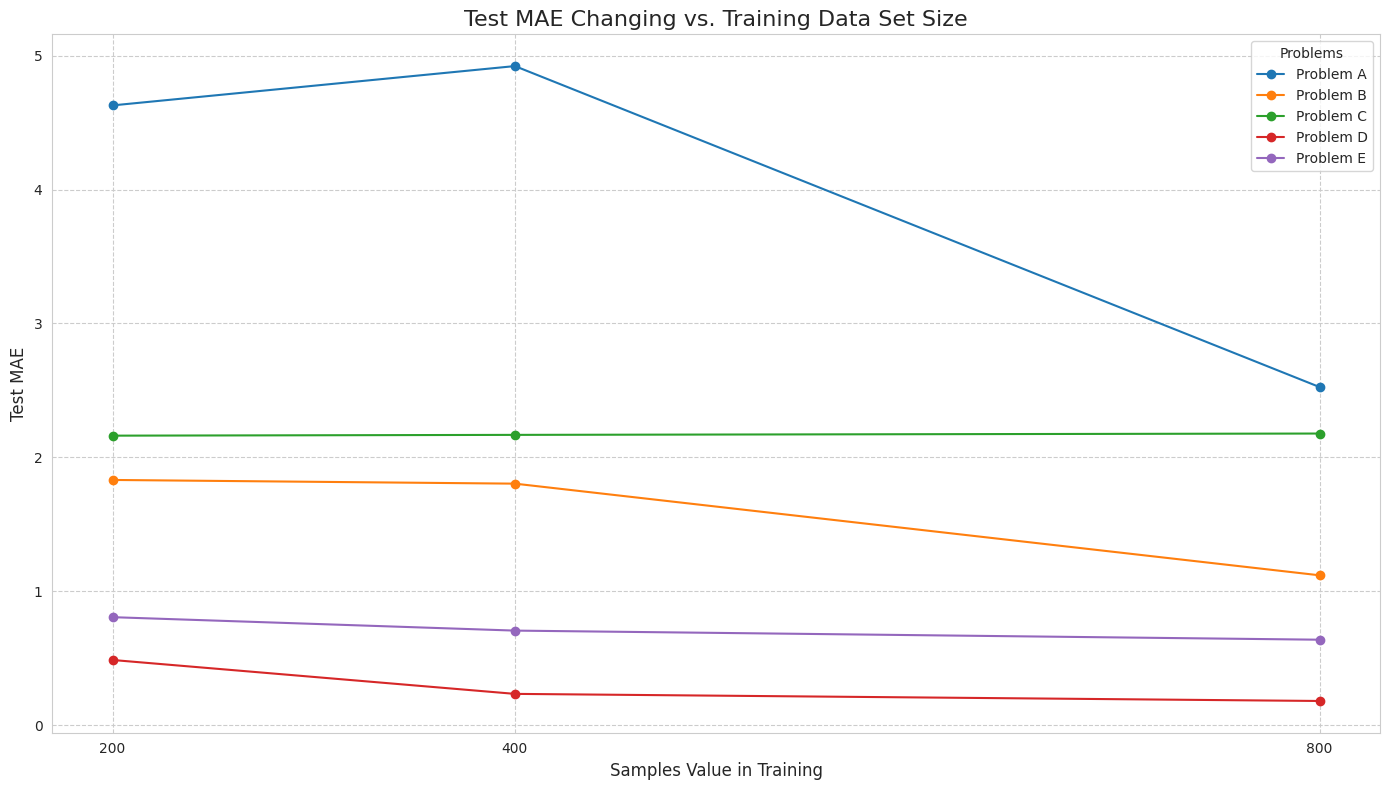

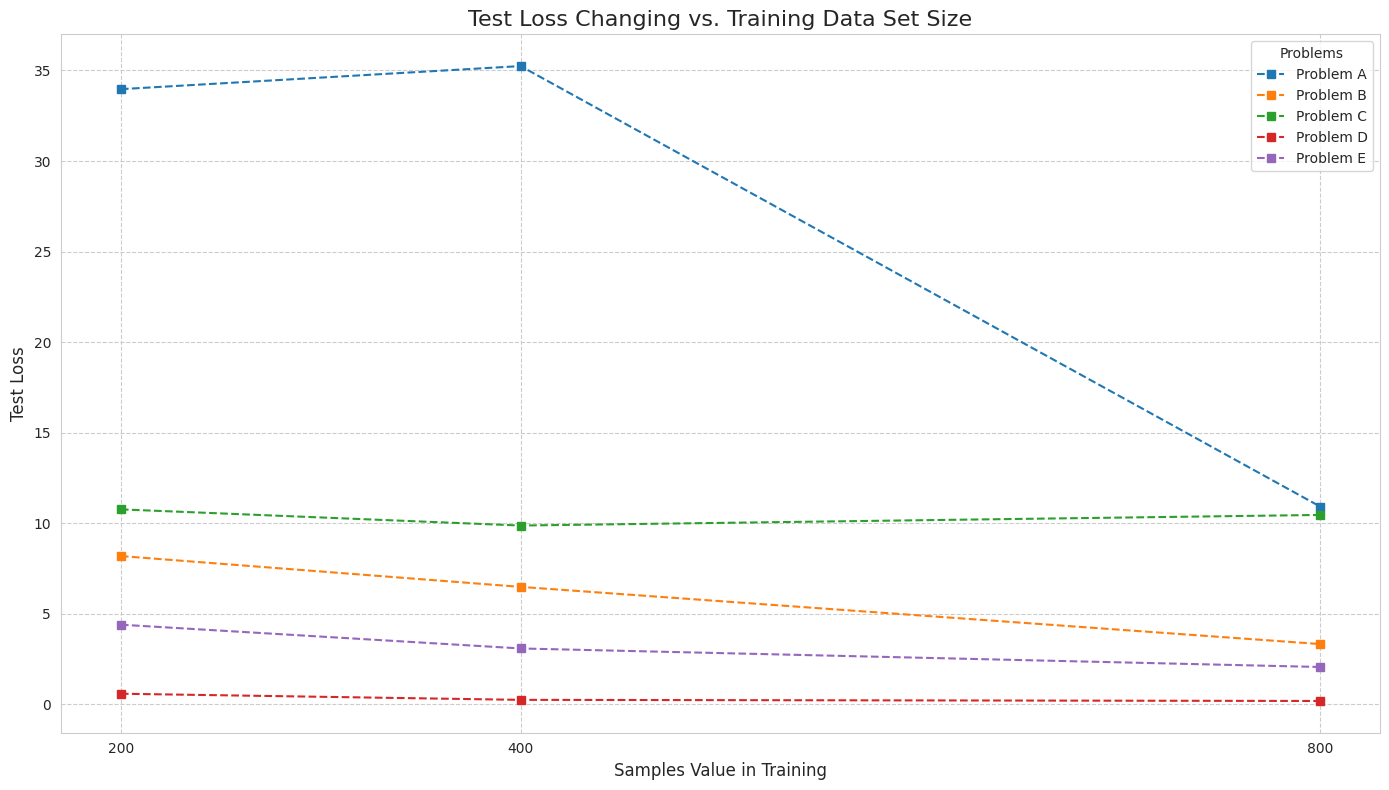

In [25]:
problems = df_performance['Problem'].unique()
plt.figure(figsize=(14, 8))
for problem_id in problems:
      subset = df_performance[df_performance['Problem'] == problem_id]
      plt.plot(subset['TrainSamples'], subset['TestMAE'], marker='o', linestyle='-', label=f'Problem {problem_id}')

plt.title('Test MAE Changing vs. Training Data Set Size', fontsize=16)
plt.xlabel('Samples Value in Training', fontsize=12)
plt.ylabel('Test MAE', fontsize=12)
plt.xticks(sorted(df_performance['TrainSamples'].unique()))
plt.legend(title='Problems')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("training_results/mae_vs_datasize.png")
plt.show()

# --- Test Loss vs. Data Set Size ---
plt.figure(figsize=(14, 8))
for problem_id in problems:
    subset = df_performance[df_performance['Problem'] == problem_id]
    plt.plot(subset['TrainSamples'], subset['TestLoss'], marker='s', linestyle='--', label=f'Problem {problem_id}')

plt.title('Test Loss Changing vs. Training Data Set Size', fontsize=16)
plt.xlabel('Samples Value in Training', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.xticks(sorted(df_performance['TrainSamples'].unique()))
plt.legend(title='Problems')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("training_results/loss_vs_datasize.png")
plt.show()



--- Problem A Learning Curves ---


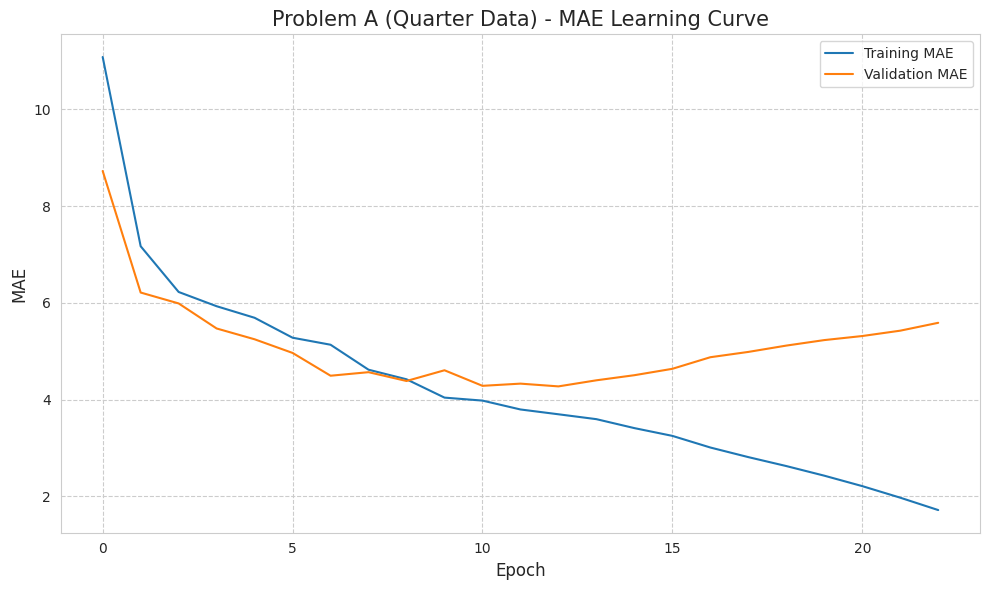

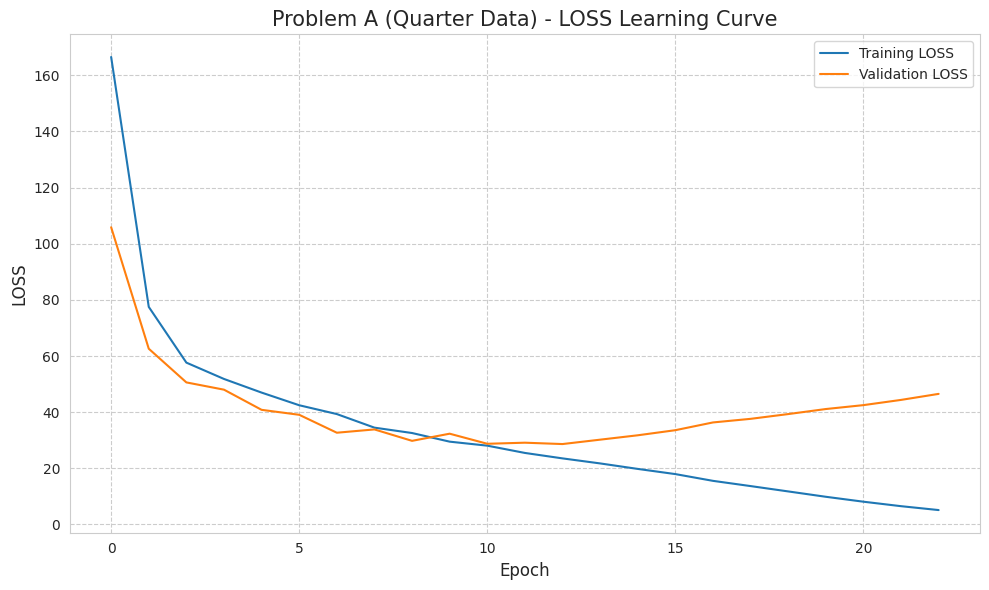

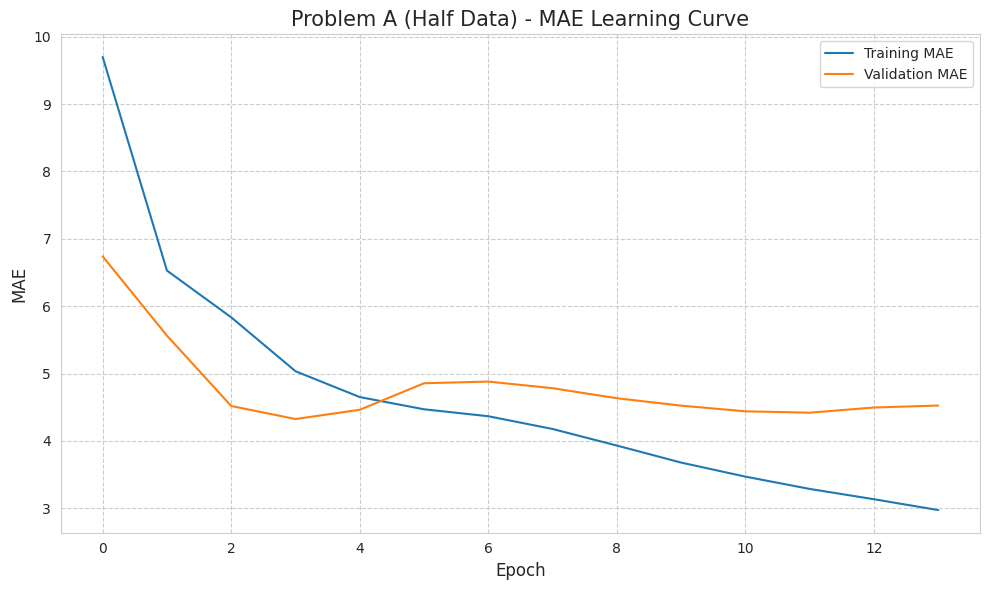

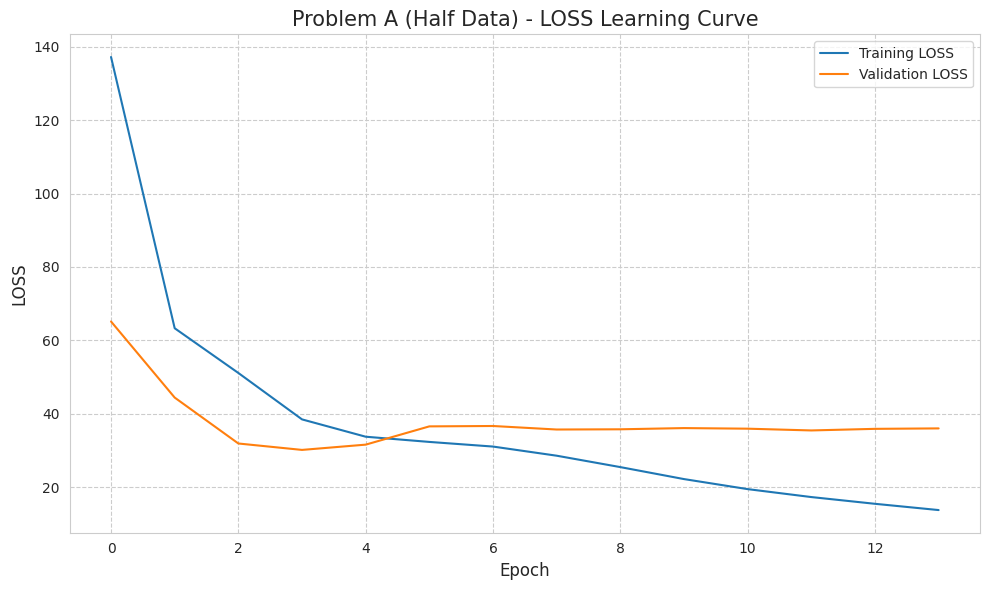

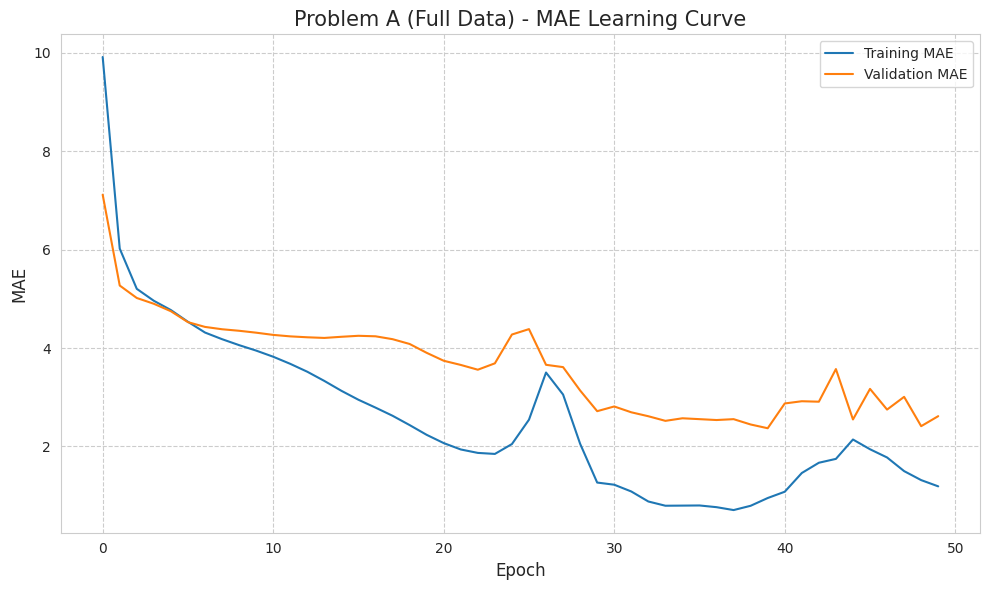

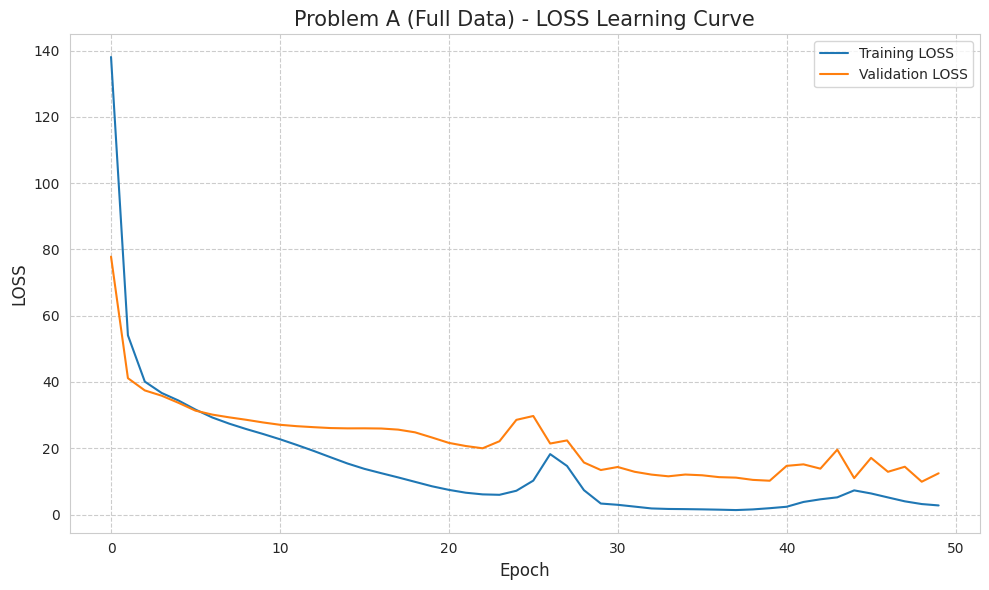


--- Problem B Learning Curves ---


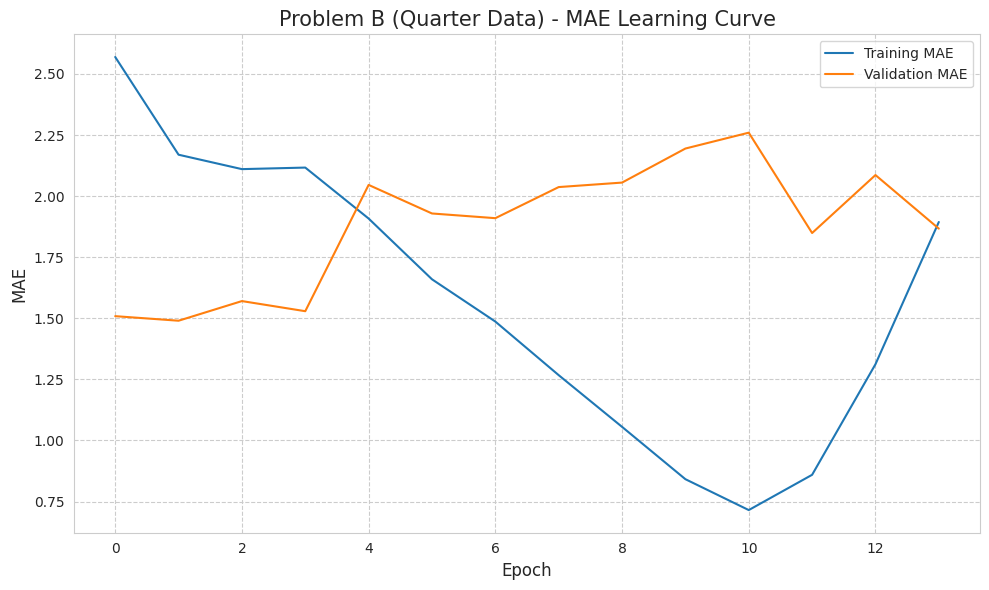

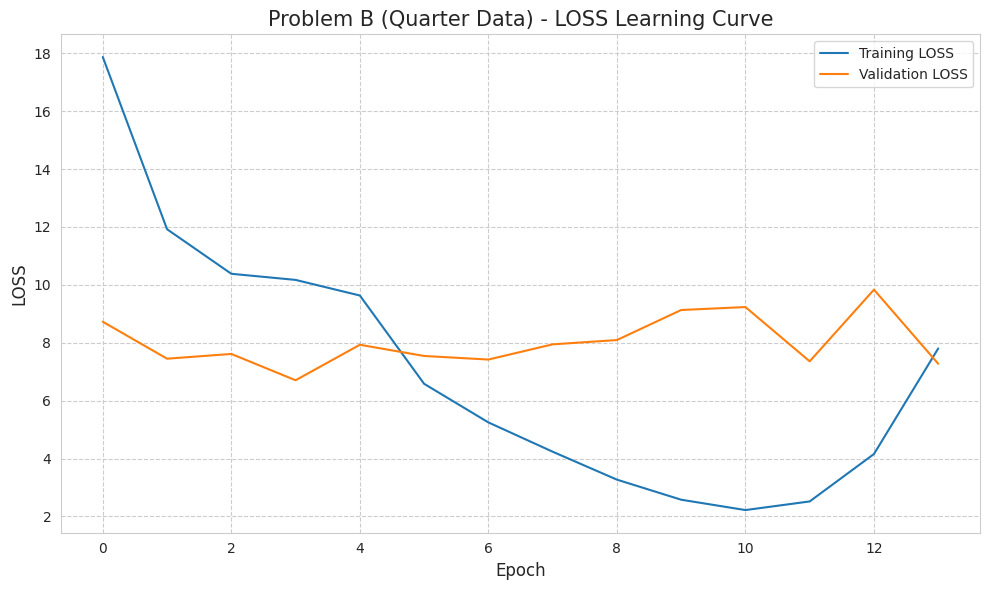

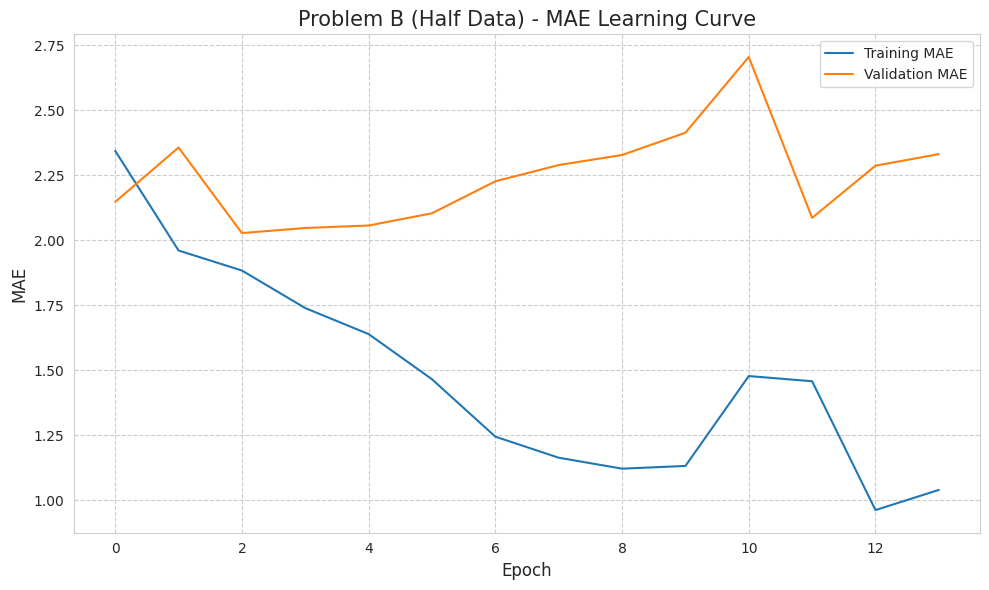

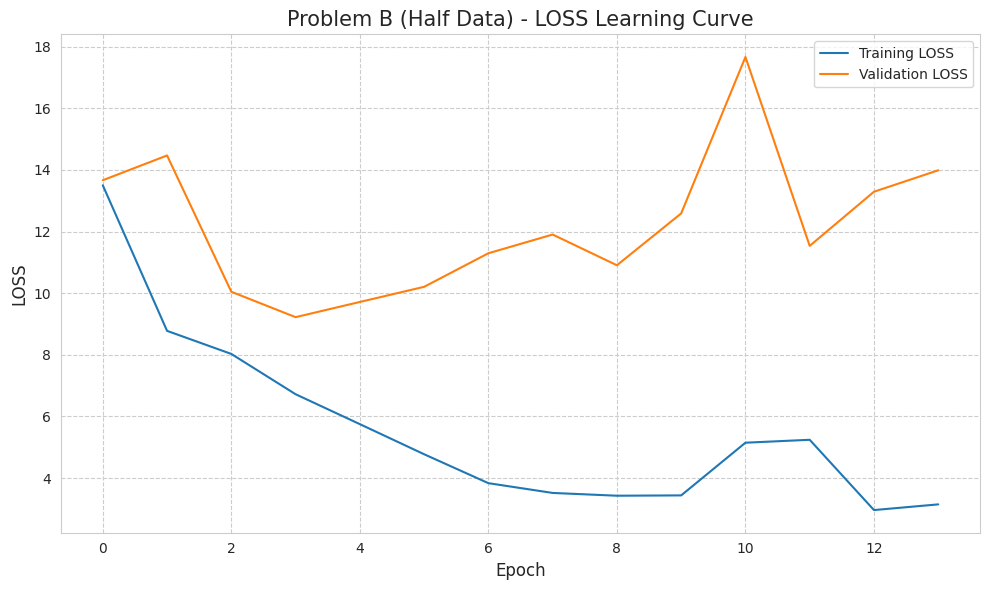

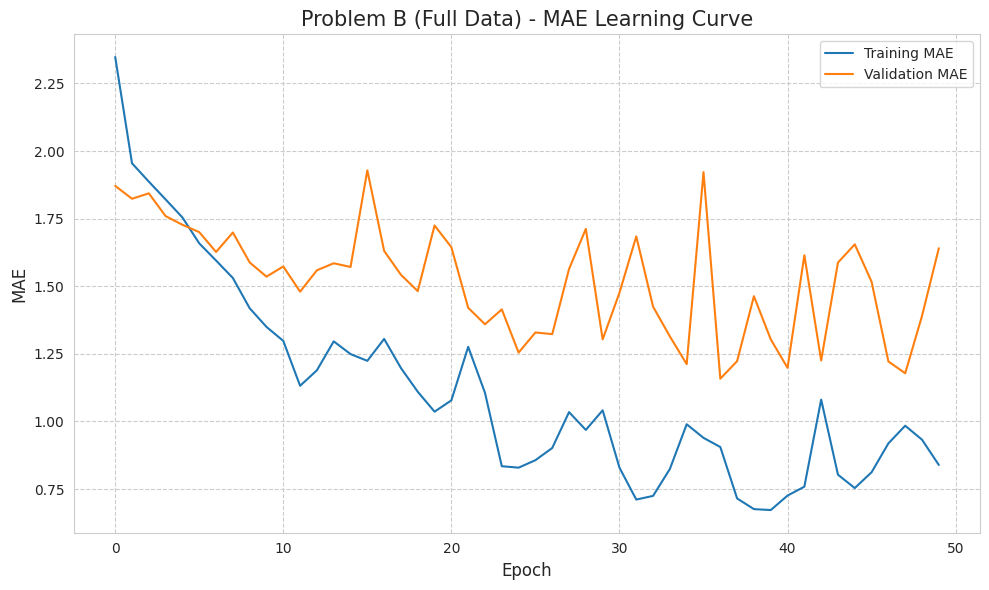

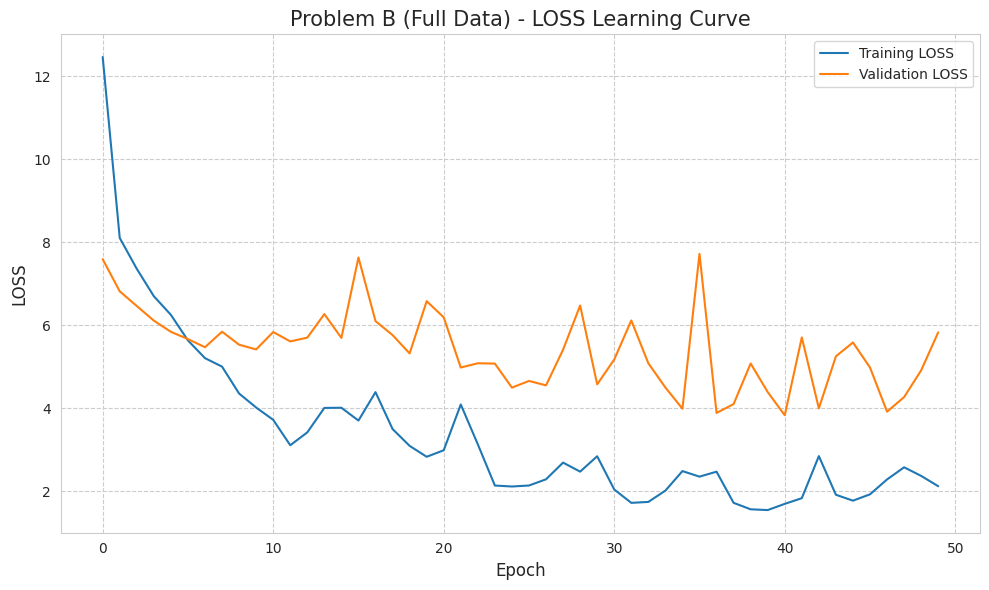


--- Problem C Learning Curves ---


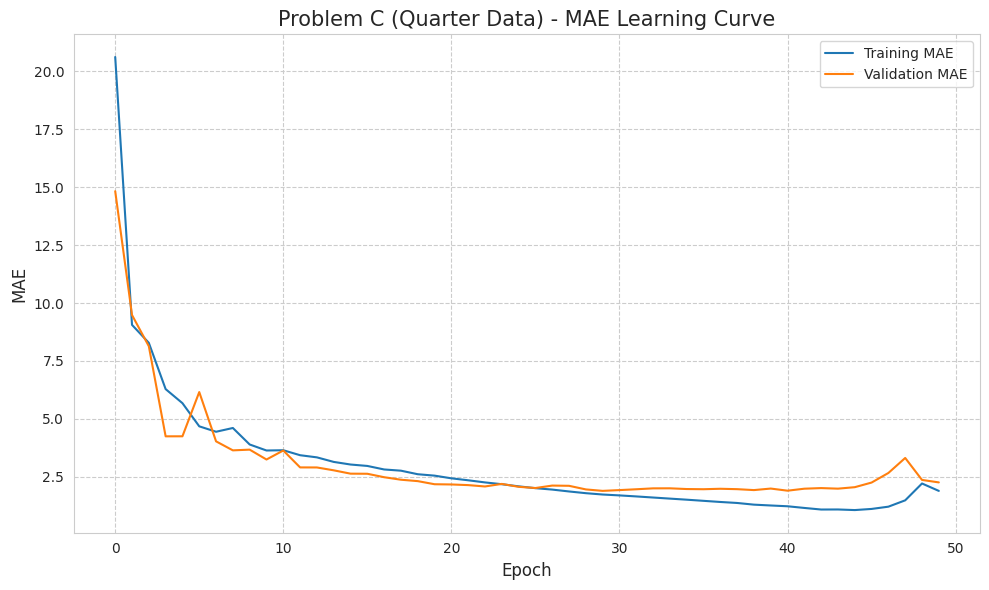

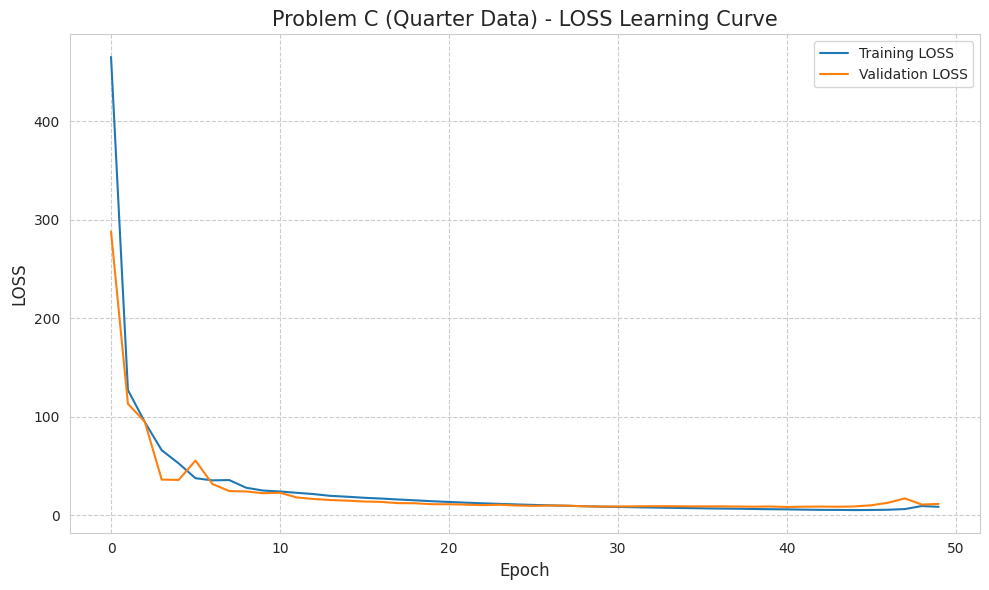

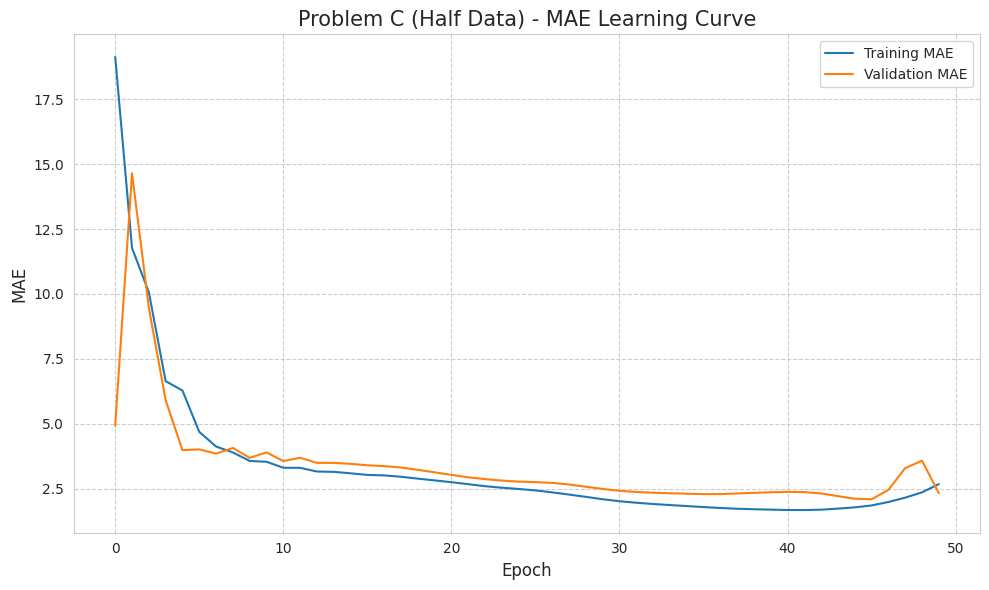

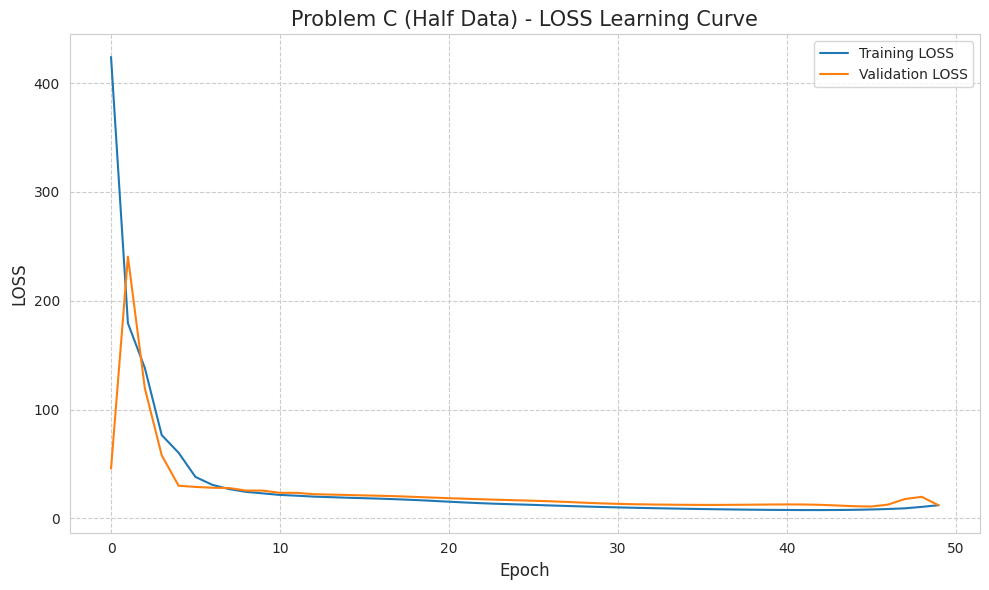

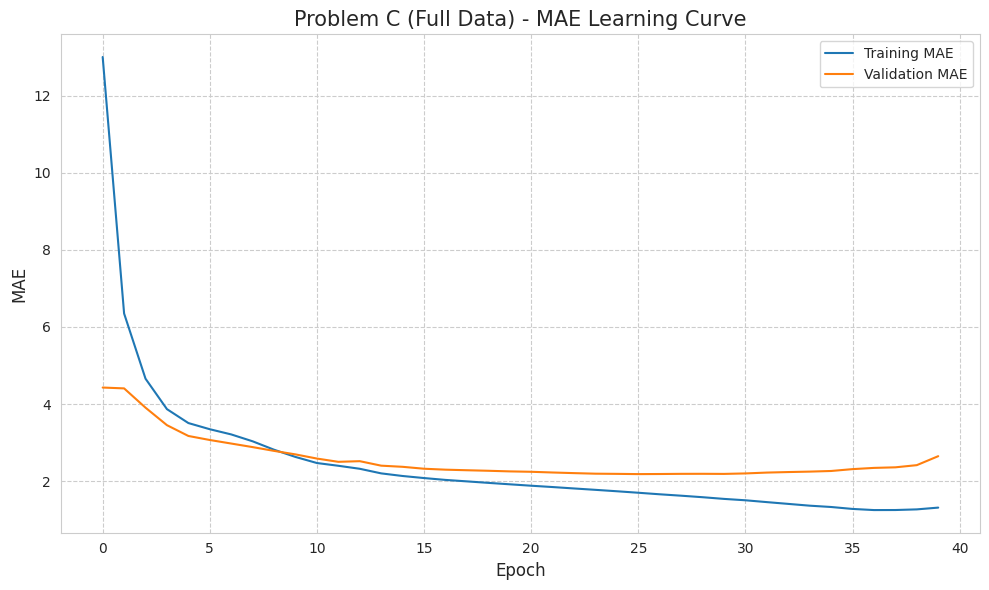

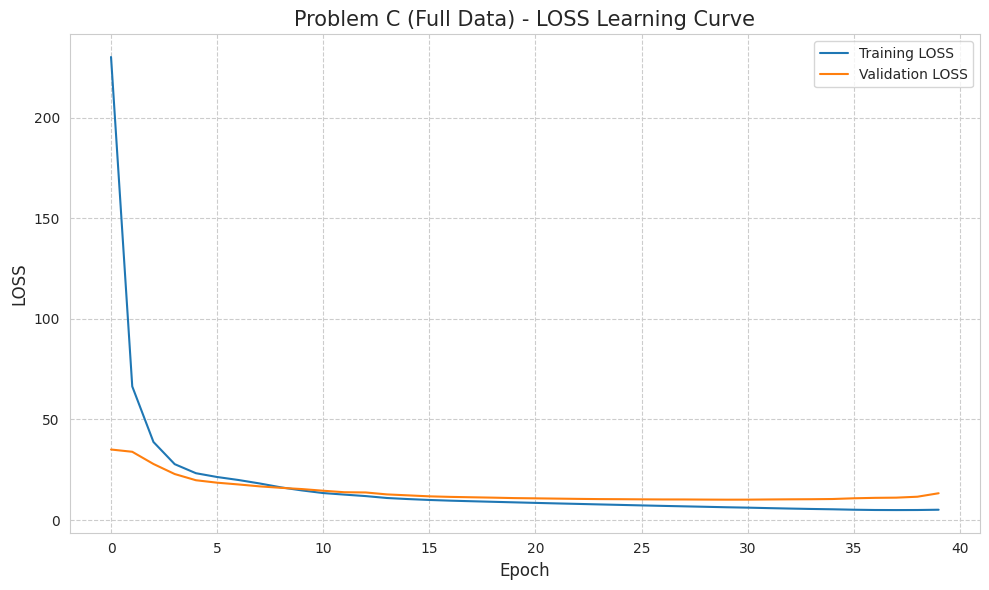


--- Problem D Learning Curves ---


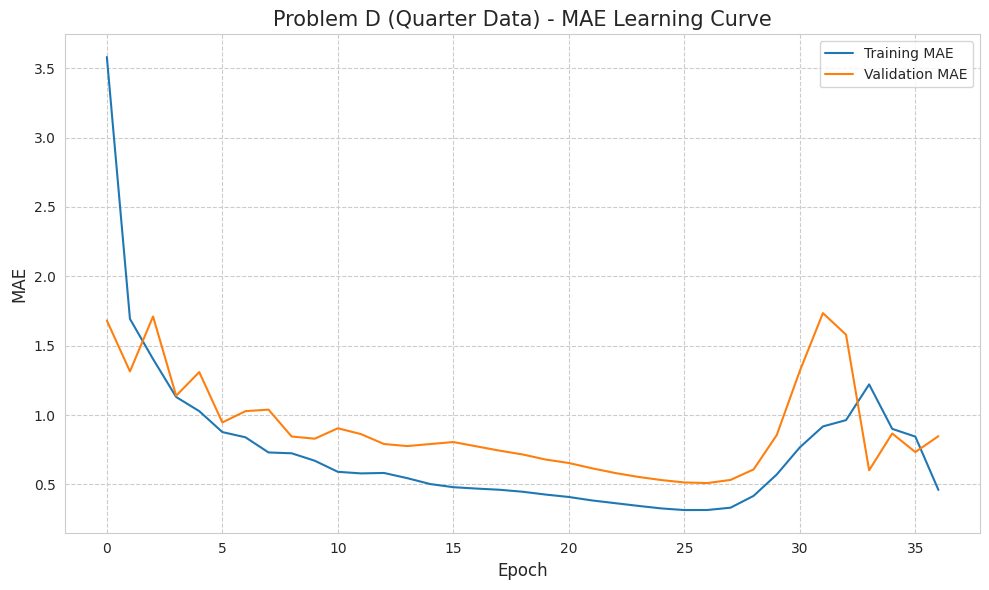

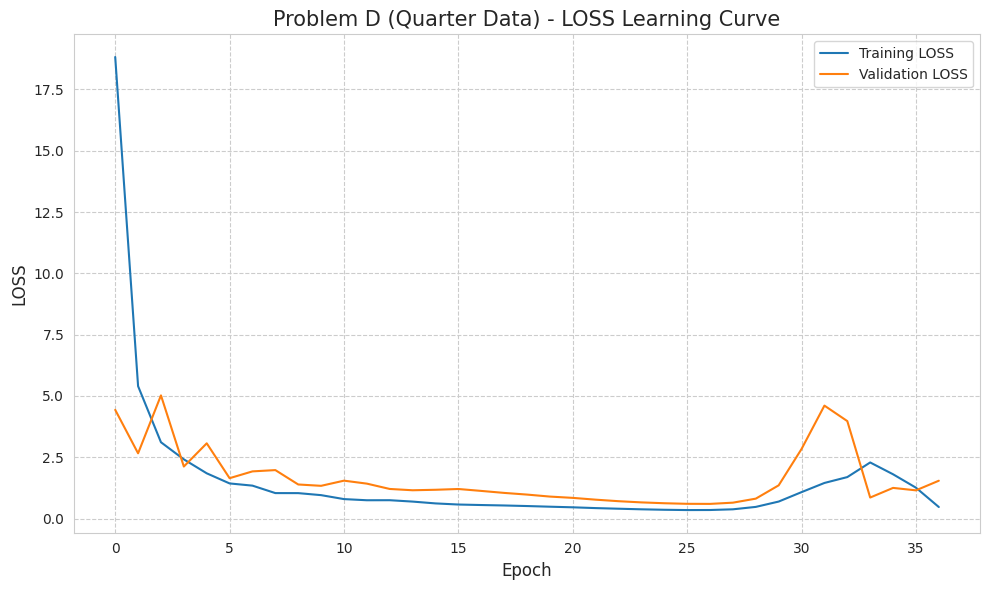

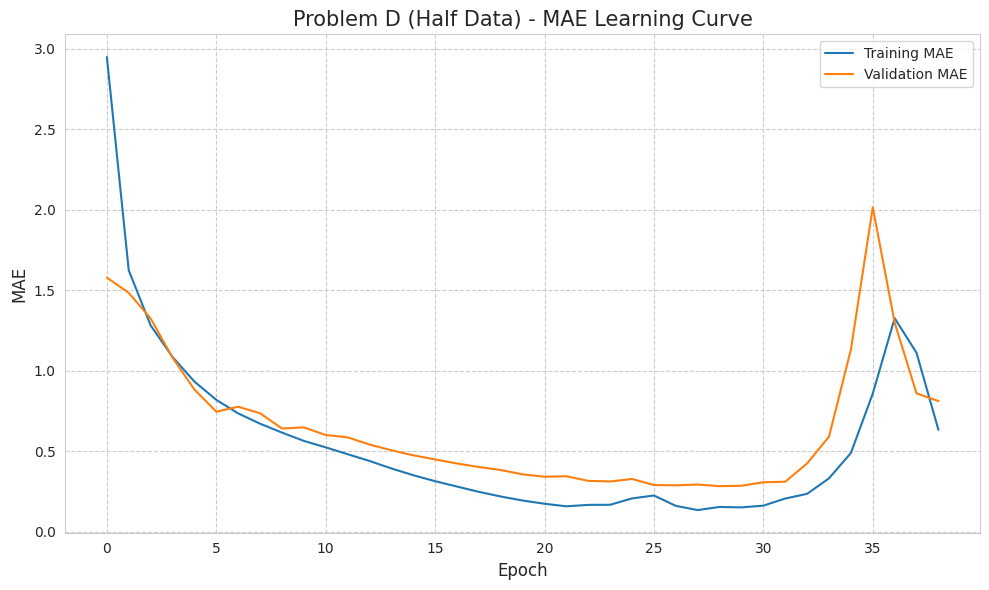

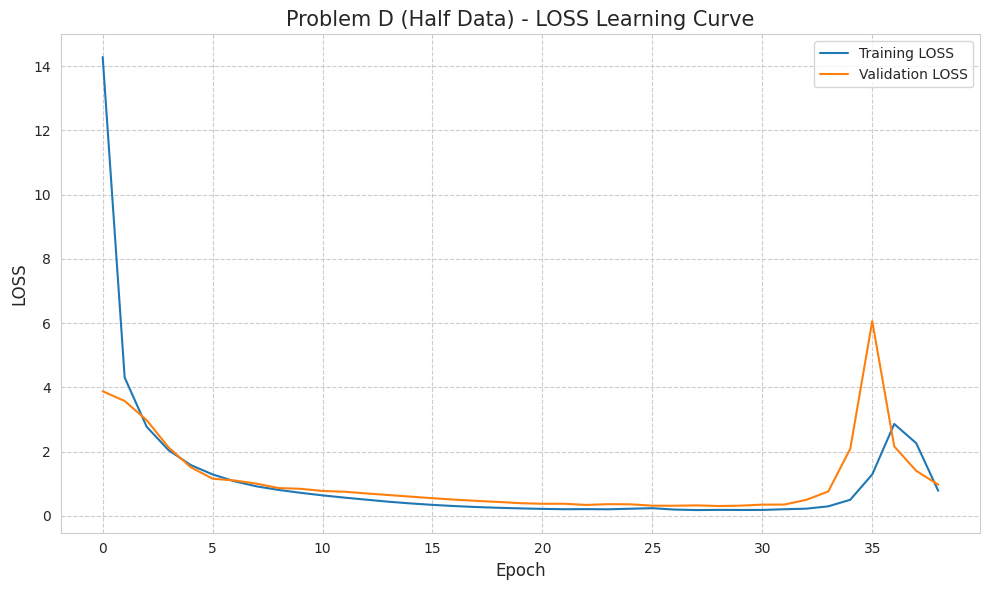

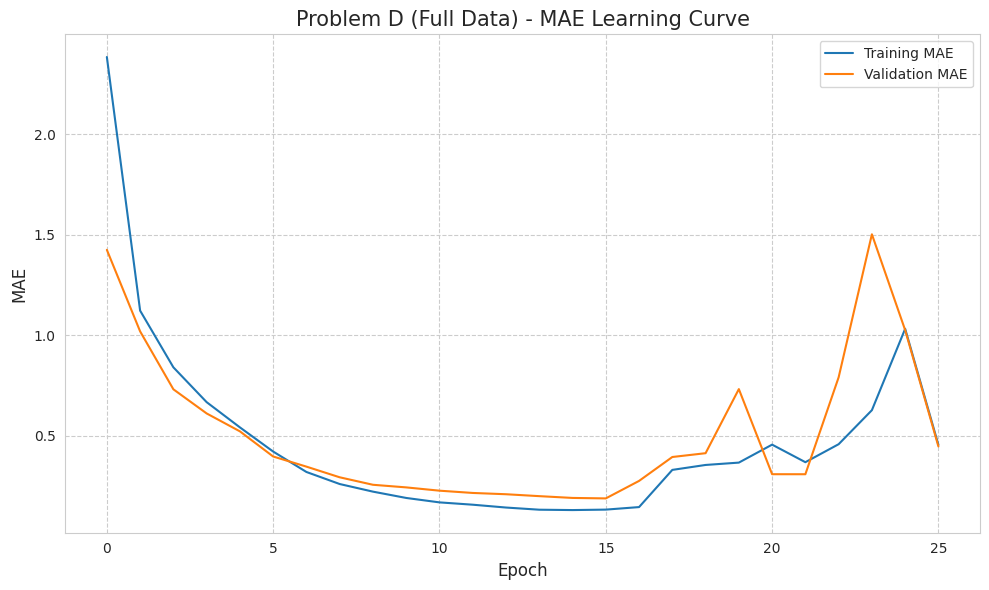

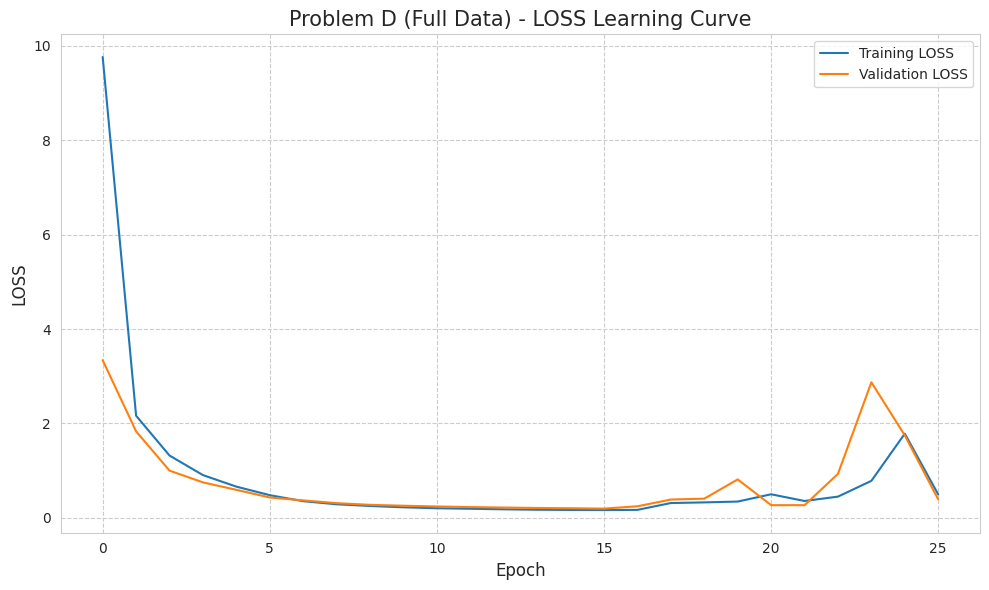


--- Problem E Learning Curves ---


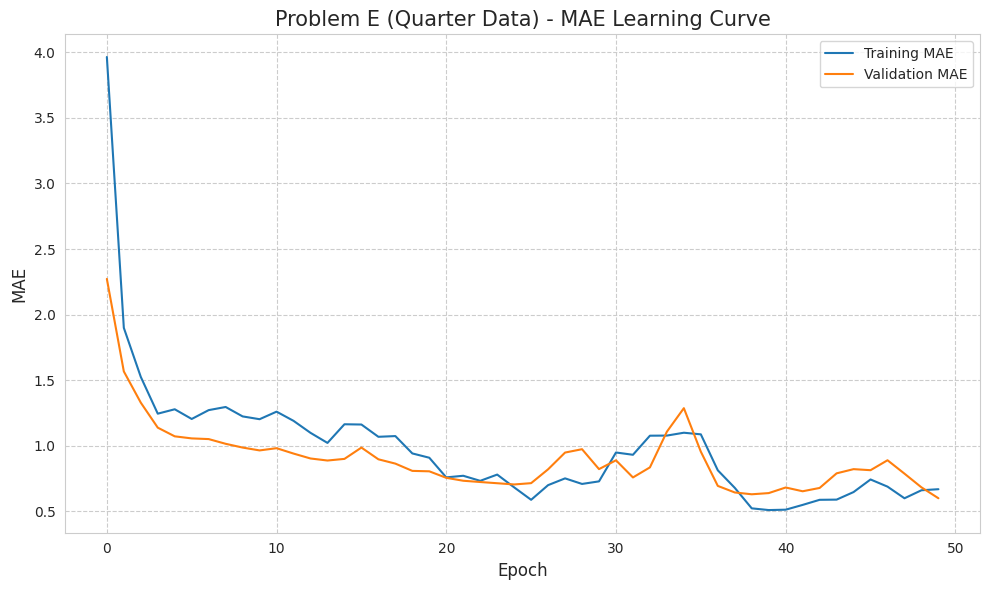

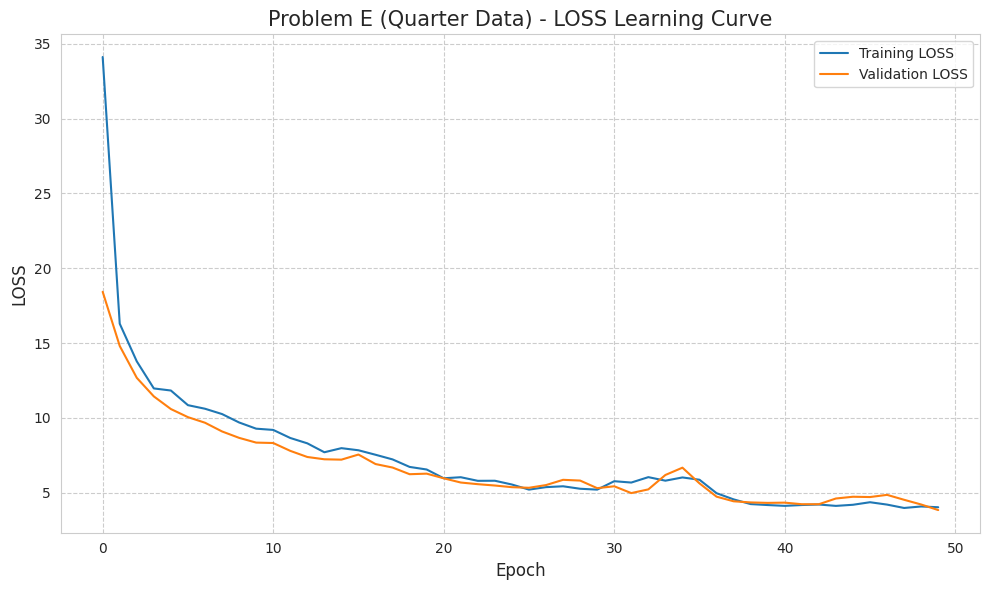

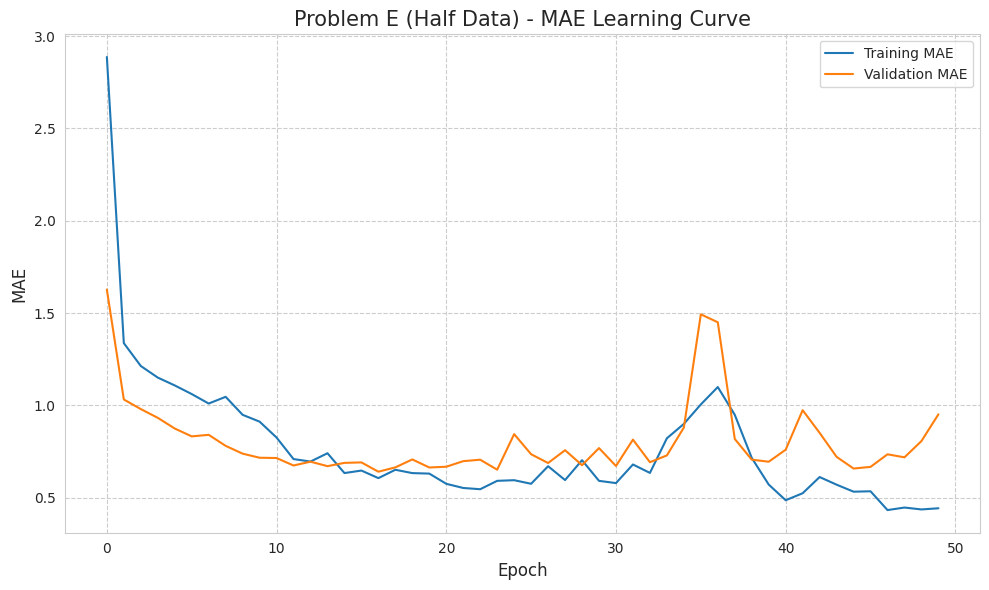

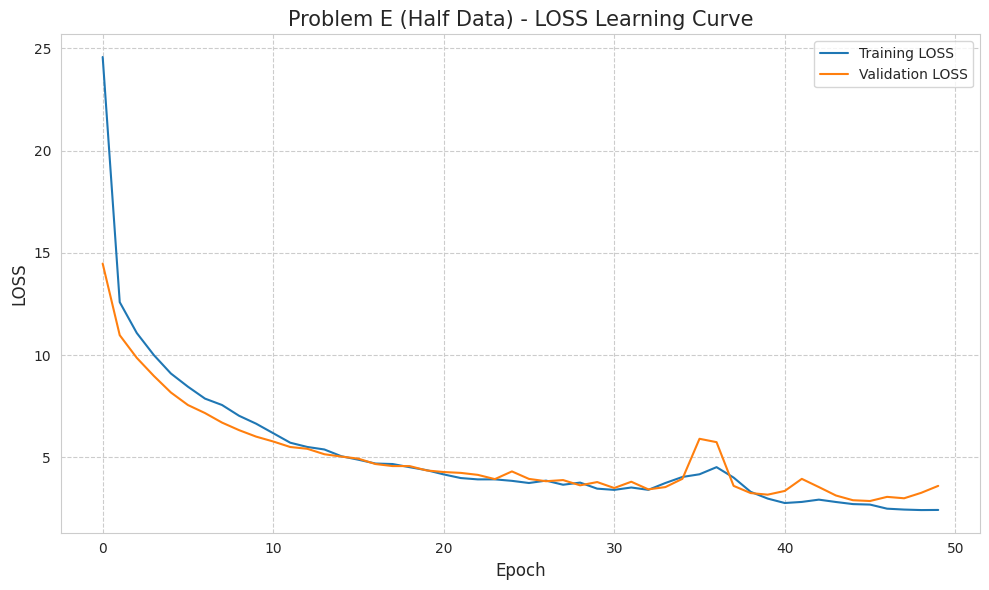

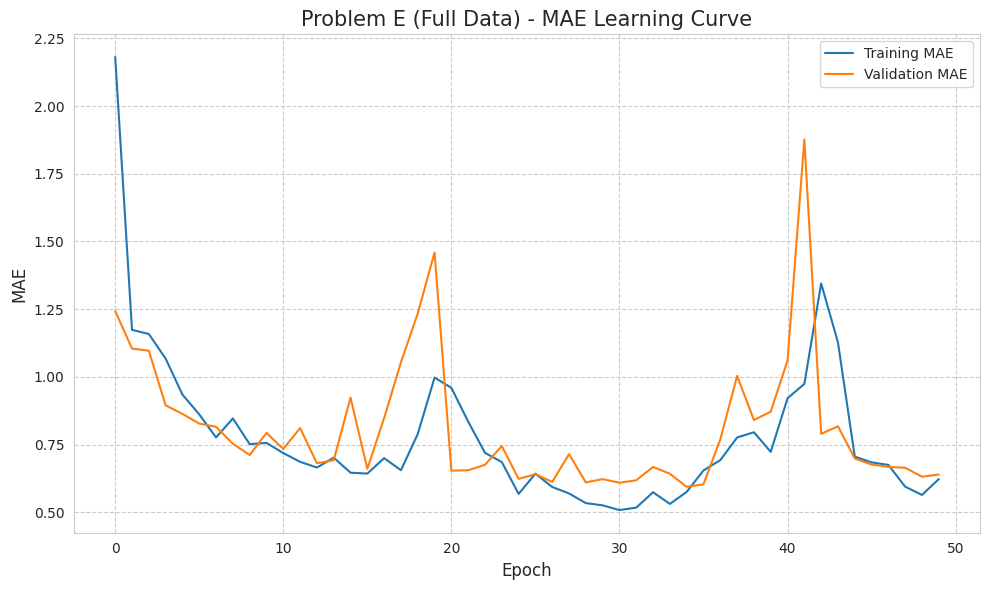

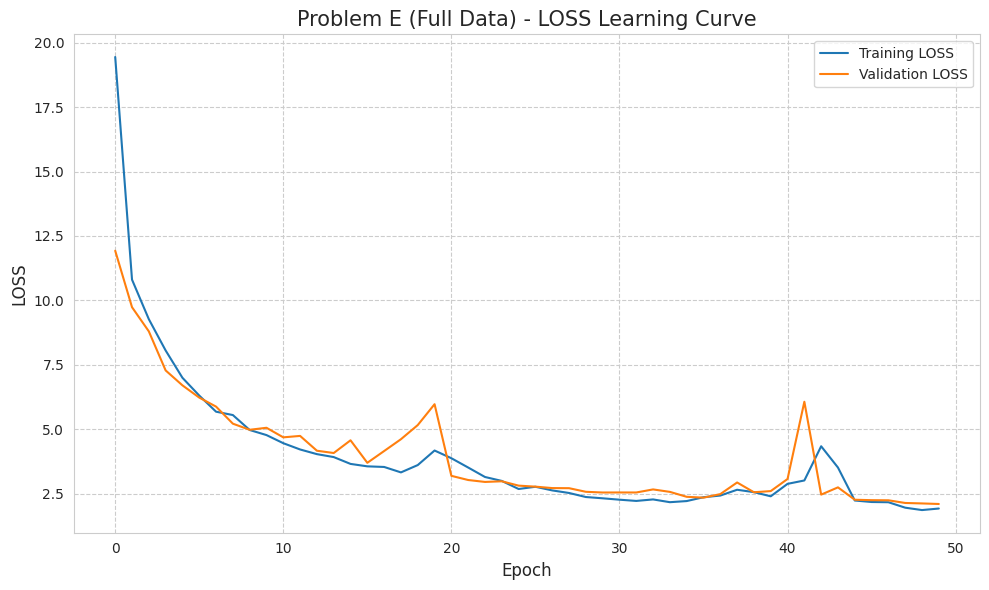

In [26]:
def plot_learning_curves(history, problem_id, data_size_key, metric='mae'):
    """
    Plots learning curves for a given educational background.

    Args:
        history (dict): model.fit() Thistory.history object returned by the method.
        problem_id (str): A, B, C, D, E.
        data_size_key (str): 'quarter', 'half', 'full'.
        metric (str): 'mae' or 'loss'.
    """
    if not history:
        print(f" Problem {problem_id} - {data_size_key} için history verisi bulunamadı.")
        return

    plt.figure(figsize=(10, 6))

    if metric in history and f'val_{metric}' in history:
        plt.plot(history[metric], label=f'Training {metric.upper()}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric.upper()}')
        plt.title(f'Problem {problem_id} ({data_size_key.capitalize()} Data) - {metric.upper()} Learning Curve', fontsize=15)
        plt.ylabel(metric.upper(), fontsize=12)
    else:
        print(f"Problem {problem_id} - {data_size_key} for '{metric}' or 'val_{metric}' can not be found in history.")
        if 'loss' in history and 'val_loss' in history:
            metric = 'loss'
            plt.plot(history[metric], label=f'Training {metric.upper()}')
            plt.plot(history[f'val_{metric}'], label=f'Validation {metric.upper()}')
            plt.title(f'Problem {problem_id} ({data_size_key.capitalize()} Data) - {metric.upper()} Learning Curve (Alternative)', fontsize=15)
            plt.ylabel(metric.upper(), fontsize=12)
        else:
            plt.title(f'Problem {problem_id} ({data_size_key.capitalize()} Data) - No Metric Data', fontsize=15)

    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()

    save_dir = f"training_results/learning_curves/problem_{problem_id}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{data_size_key}_{metric}_learning_curve.png")
    plt.show()


if 'all_results' in locals() and all_results:
    for problem_id, problem_data in all_results.items():
        print(f"\n--- Problem {problem_id} Learning Curves ---")
        for data_size_key, results_dict in problem_data.items():
              plot_learning_curves(results_dict['history'], problem_id, data_size_key, metric='mae')
              plot_learning_curves(results_dict['history'], problem_id, data_size_key, metric='loss')

else:
    print("`all_results` variable can not be found or None.")
    print("Please complete the training by running the function `all_results = train_all_data_sizes()` first.")


--- Test Performances of Problems on Full Dataset (Ordered by MAE) ---
   Problem   TestMAE   TestLoss  TrainSamples
11       D  0.179809   0.193542           800
14       E  0.637444   2.069444           800
5        B  1.118464   3.335679           800
8        C  2.177485  10.463284           800
2        A  2.524472  10.928902           800


<ipython-input-27-63ae5e1567cd>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Problem', y='TestMAE', data=df_full_data_performance, palette='viridis', order=df_full_data_performance['Problem'])


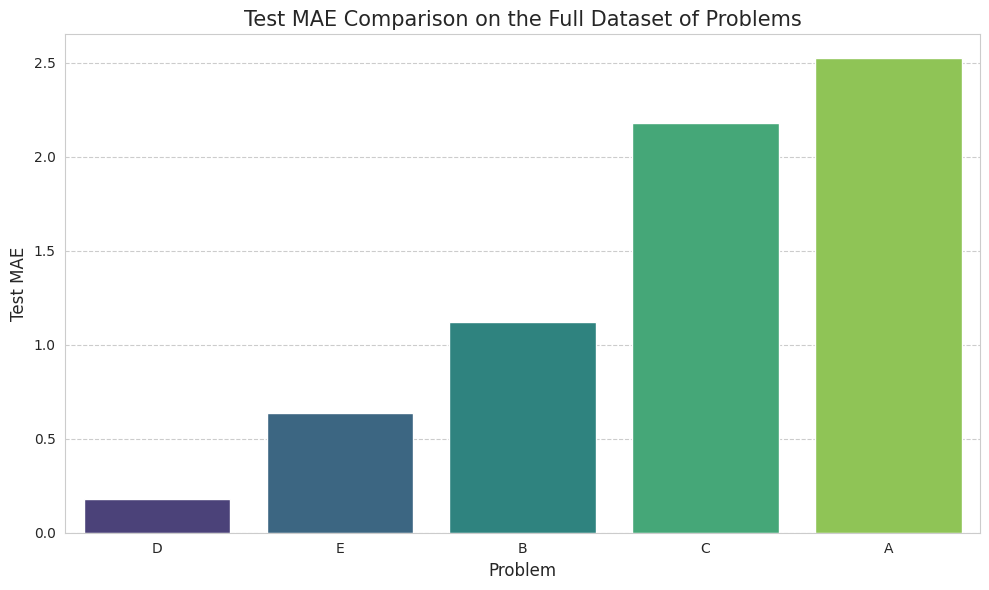

<ipython-input-27-63ae5e1567cd>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Problem', y='TestLoss', data=df_full_data_performance, palette='magma', order=df_full_data_performance['Problem'])


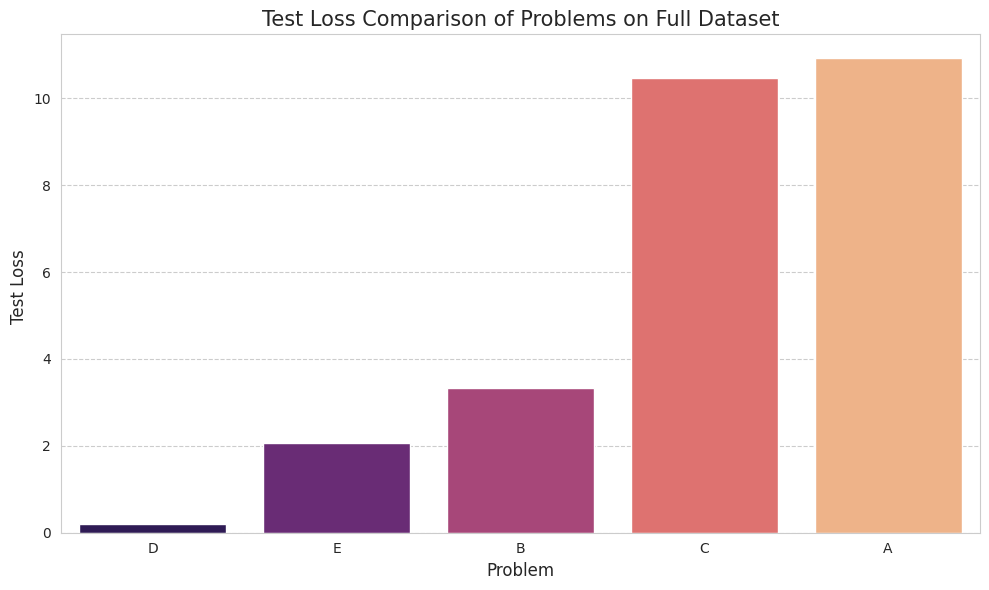

In [27]:
df_full_data_performance = df_performance[df_performance['DataSize_Key'] == 'full'].copy()
df_full_data_performance.sort_values(by='TestMAE', ascending=True, inplace=True)

print("\n--- Test Performances of Problems on Full Dataset (Ordered by MAE) ---")
print(df_full_data_performance[['Problem', 'TestMAE', 'TestLoss', 'TrainSamples']])

plt.figure(figsize=(10, 6))
sns.barplot(x='Problem', y='TestMAE', data=df_full_data_performance, palette='viridis', order=df_full_data_performance['Problem'])
plt.title('Test MAE Comparison on the Full Dataset of Problems', fontsize=15)
plt.xlabel('Problem', fontsize=12)
plt.ylabel('Test MAE', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig("training_results/problem_comparison_mae_bar.png")
plt.show()

df_full_data_performance.sort_values(by='TestLoss', ascending=True, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Problem', y='TestLoss', data=df_full_data_performance, palette='magma', order=df_full_data_performance['Problem'])
plt.title('Test Loss Comparison of Problems on Full Dataset', fontsize=15)
plt.xlabel('Problem', fontsize=12)
plt.ylabel('Test Loss ', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig("training_results/problem_comparison_loss_bar.png")
plt.show()


## 5. Detailed Error Analysis

### 5.1 Error Distributions and Patterns

For each problem, I examined the most successful and unsuccessful cases of the model.
This analysis allows us to understand what the model learned and what it struggled with.

Hata analizi başlatılıyor...

Error Analysis for Problem A
Model yüklendi: models/problem_A_full_best.h5

Test Set Performance Metrics:
  MAE: 2.5245
  MSE: 10.3261
  RMSE: 3.2134
  Average Relative Error: 30.81%

--- En Başarılı 10 Tahmin ---


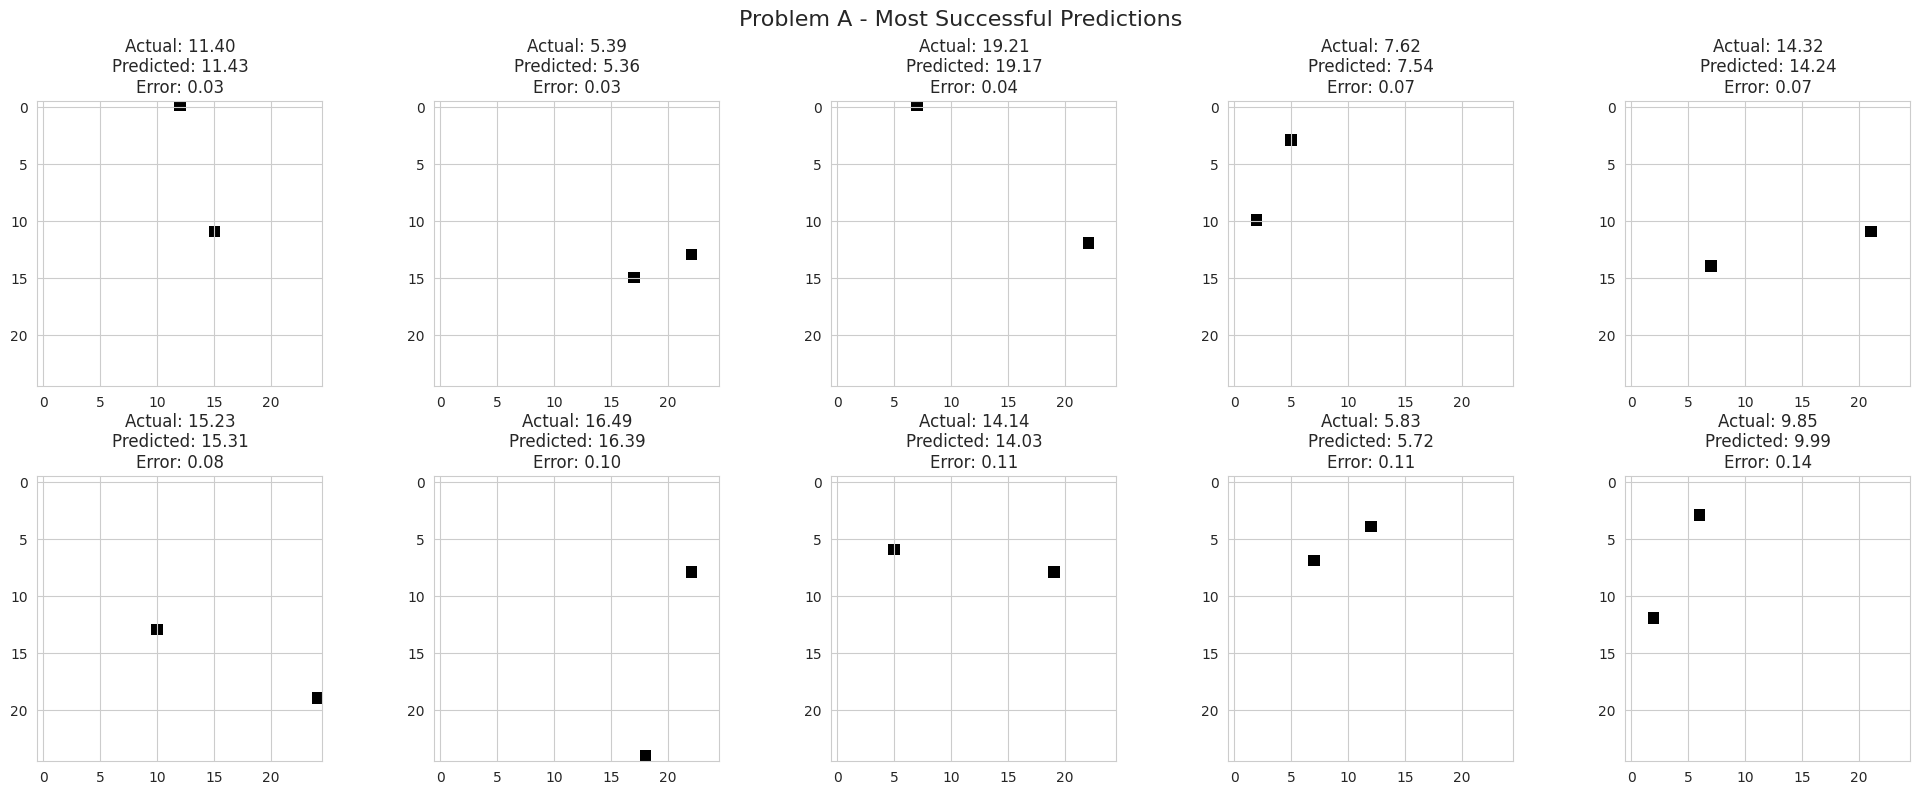


--- The Most Unsuccessful 10 Prediction ---


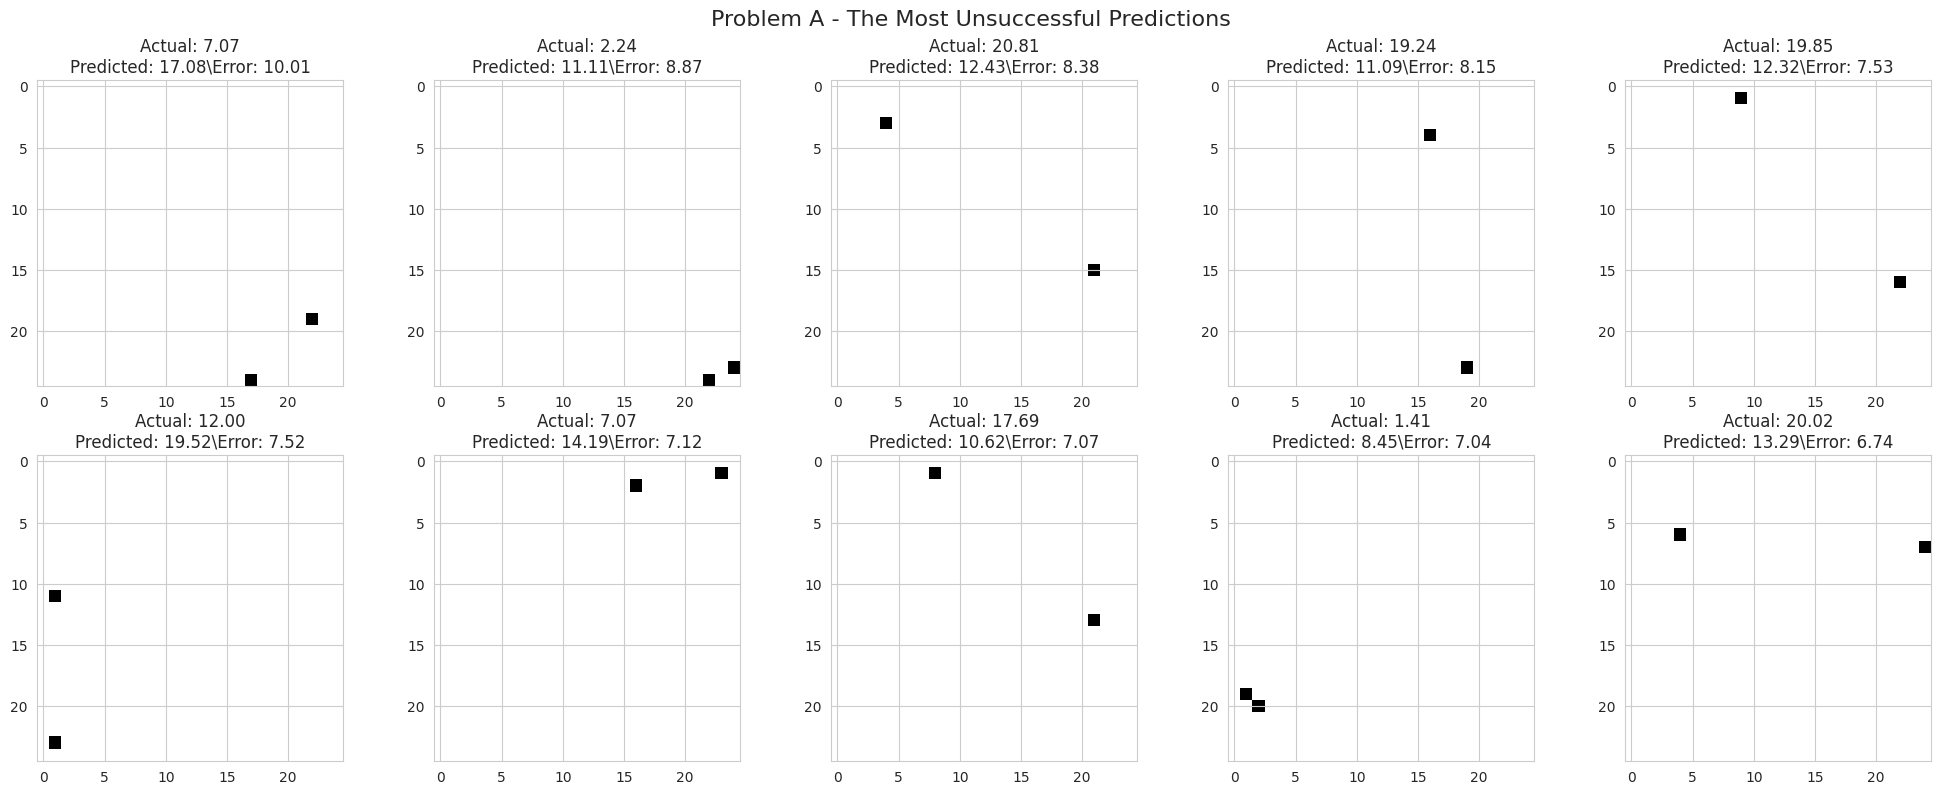

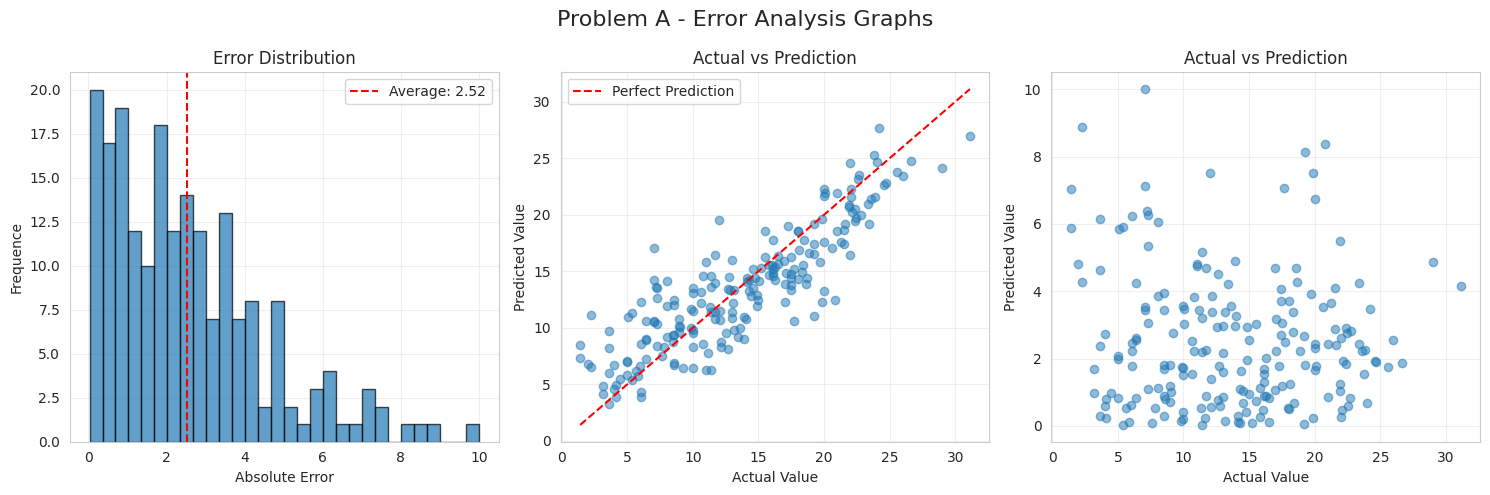


Error Analysis for Problem B
Model yüklendi: models/problem_B_full_best.h5

Test Set Performance Metrics:
  MAE: 1.1185
  MSE: 2.4706
  RMSE: 1.5718
  Average Relative Error: 47.05%

--- En Başarılı 10 Tahmin ---


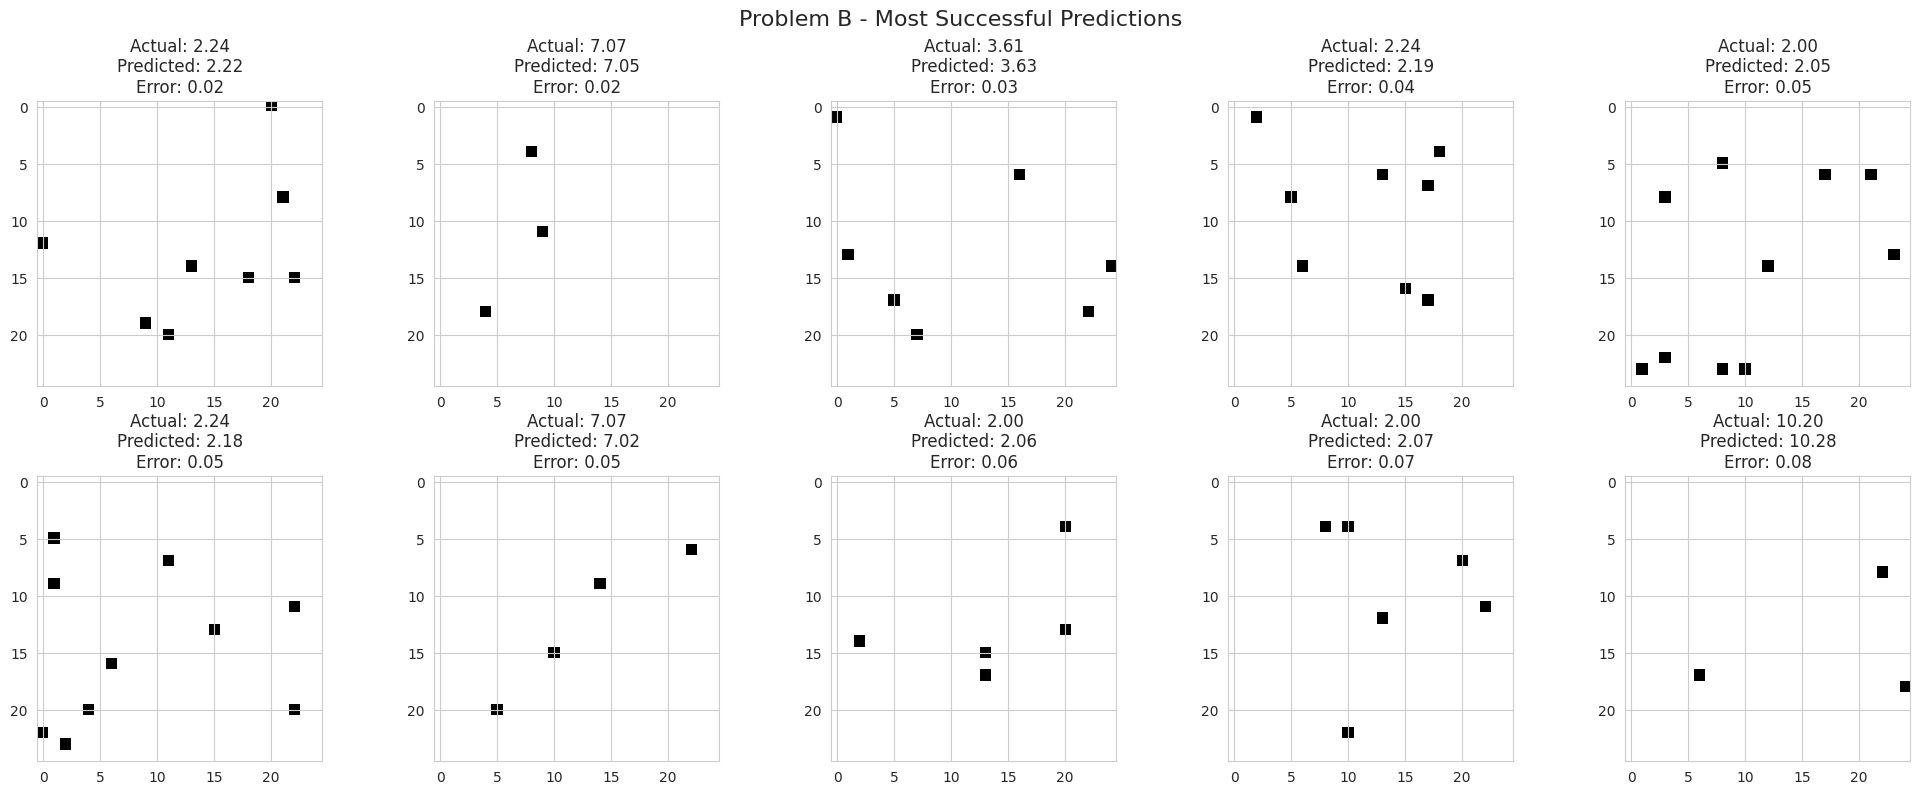


--- The Most Unsuccessful 10 Prediction ---


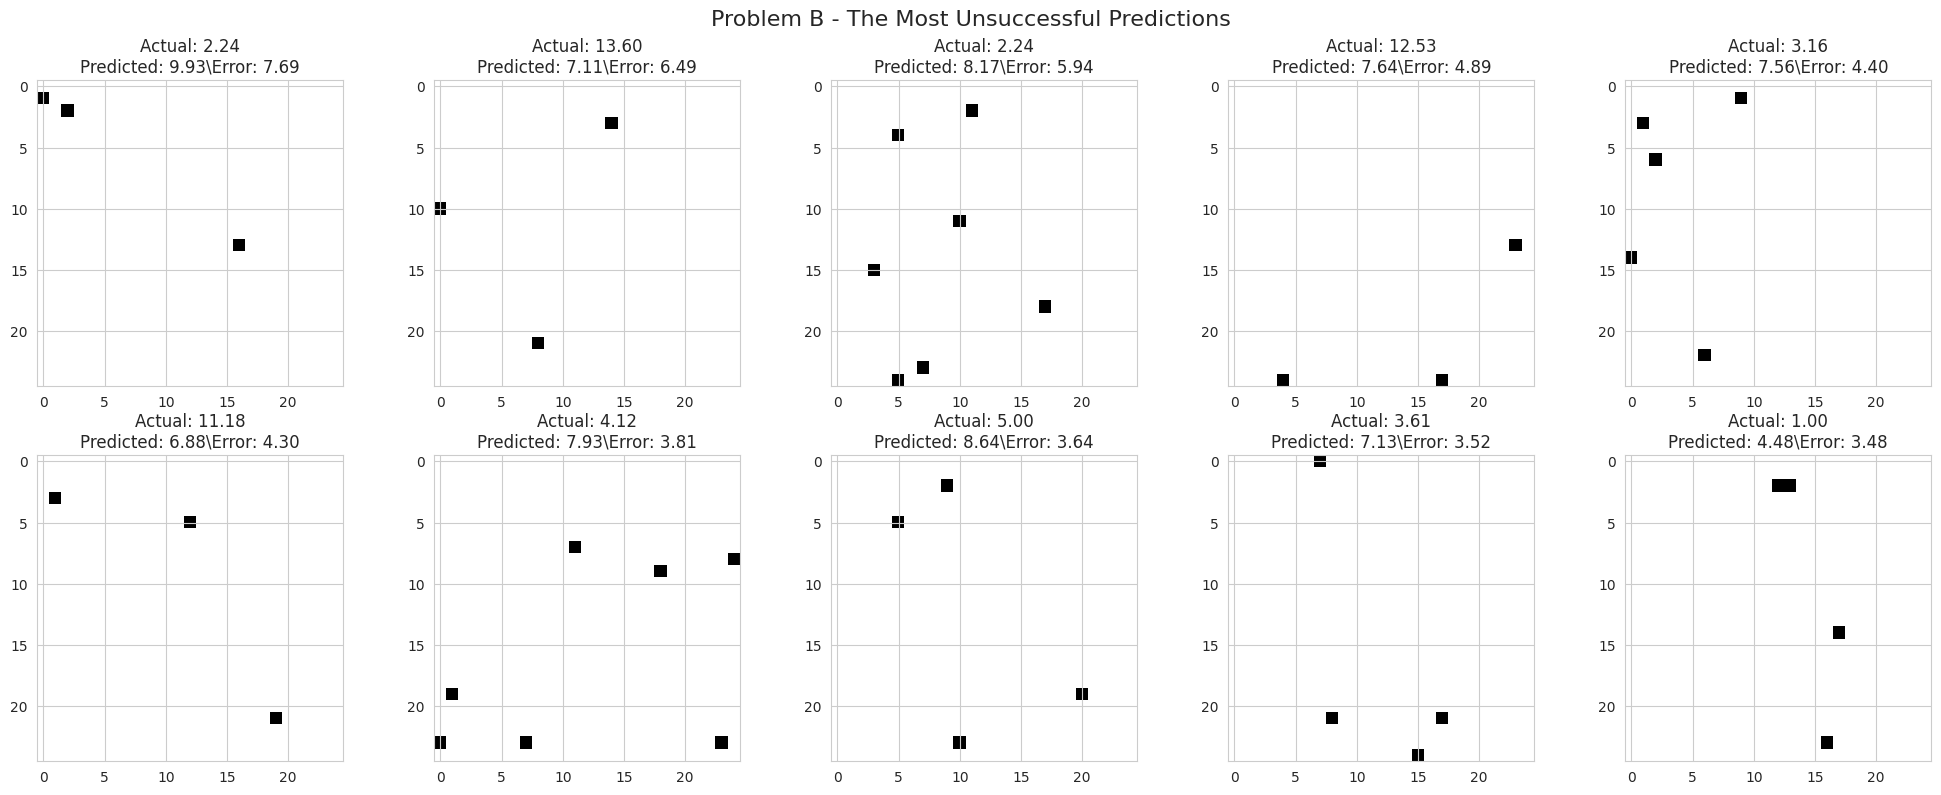

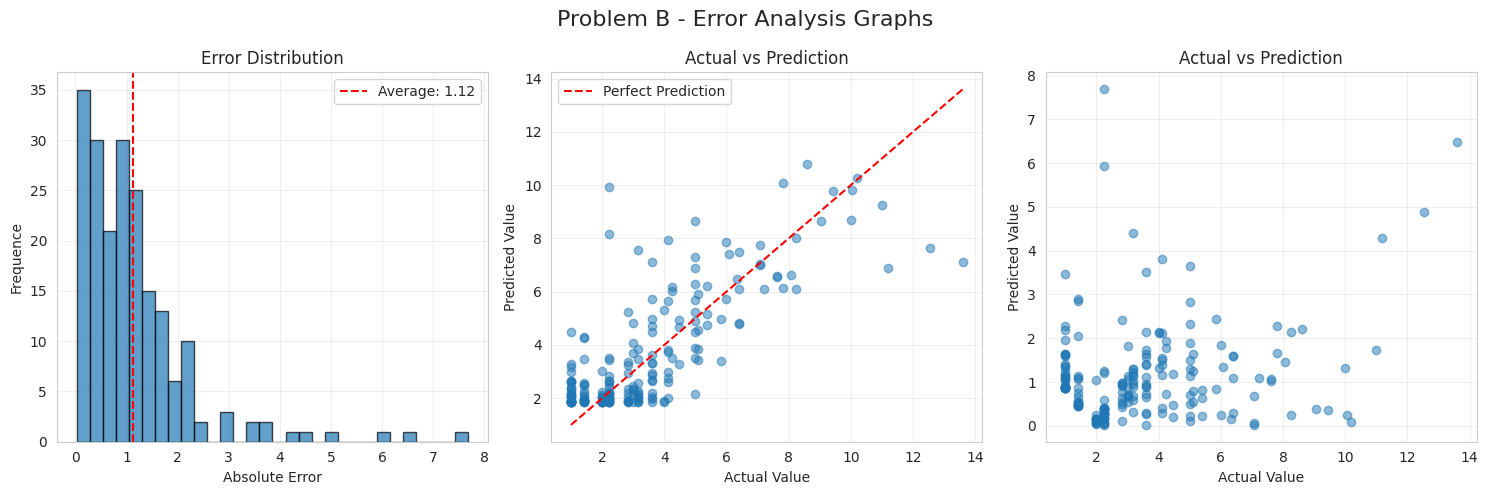


Error Analysis for Problem C
Model yüklendi: models/problem_C_full_best.h5



Test Set Performance Metrics:
  MAE: 2.1775
  MSE: 8.0232
  RMSE: 2.8325
  Average Relative Error: 9.57%

--- En Başarılı 10 Tahmin ---


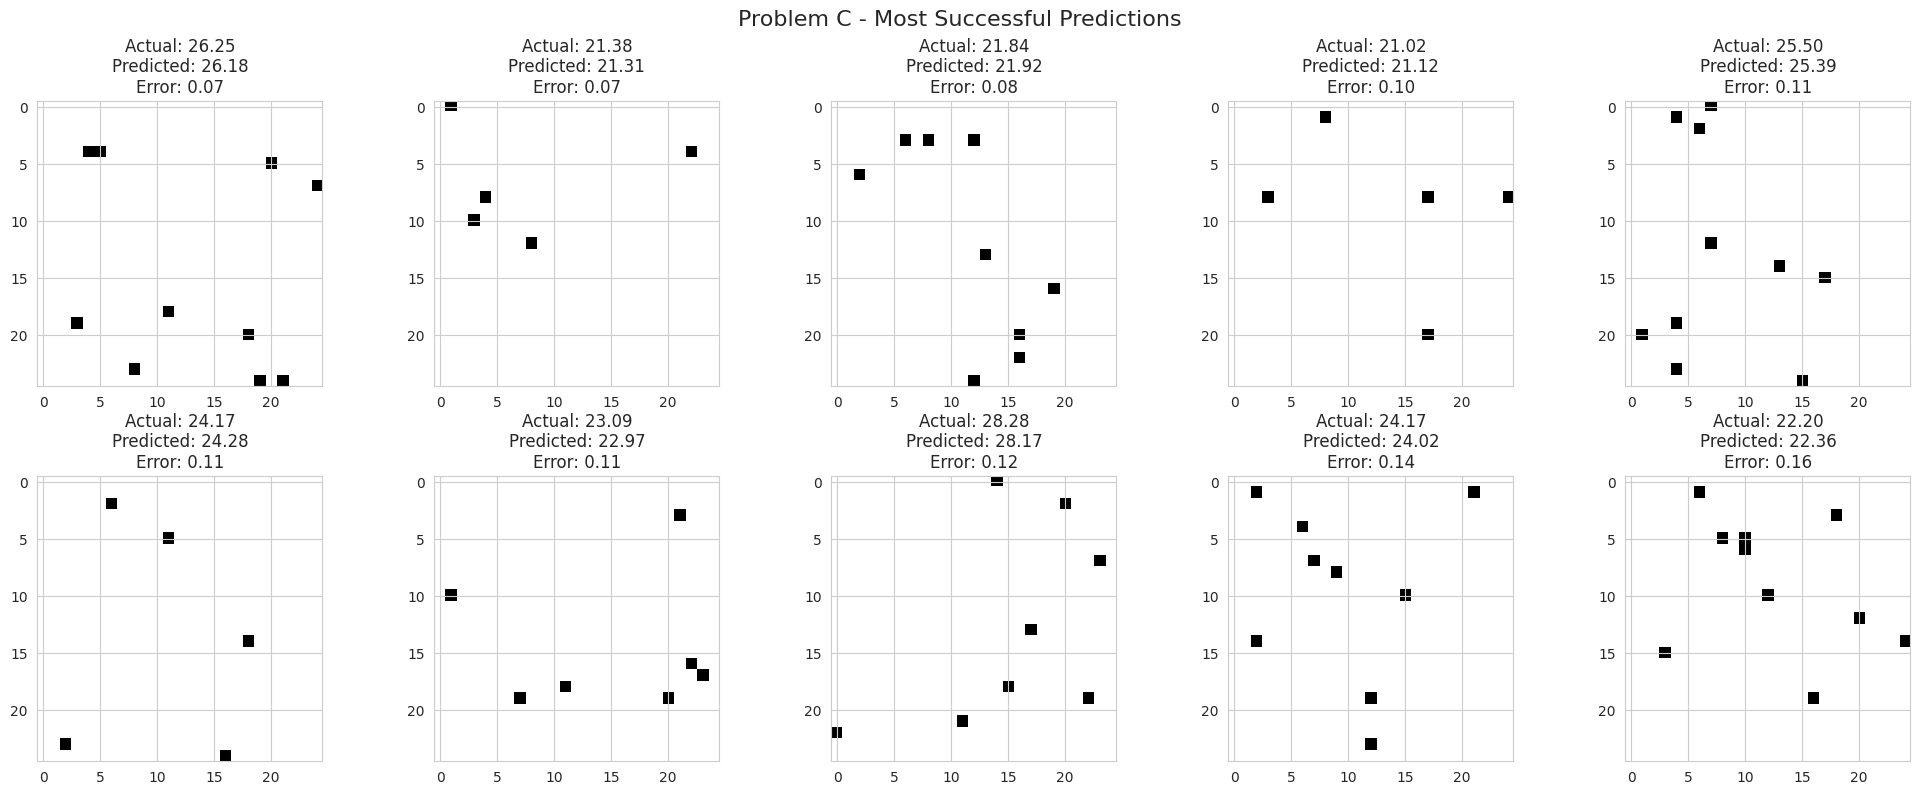


--- The Most Unsuccessful 10 Prediction ---


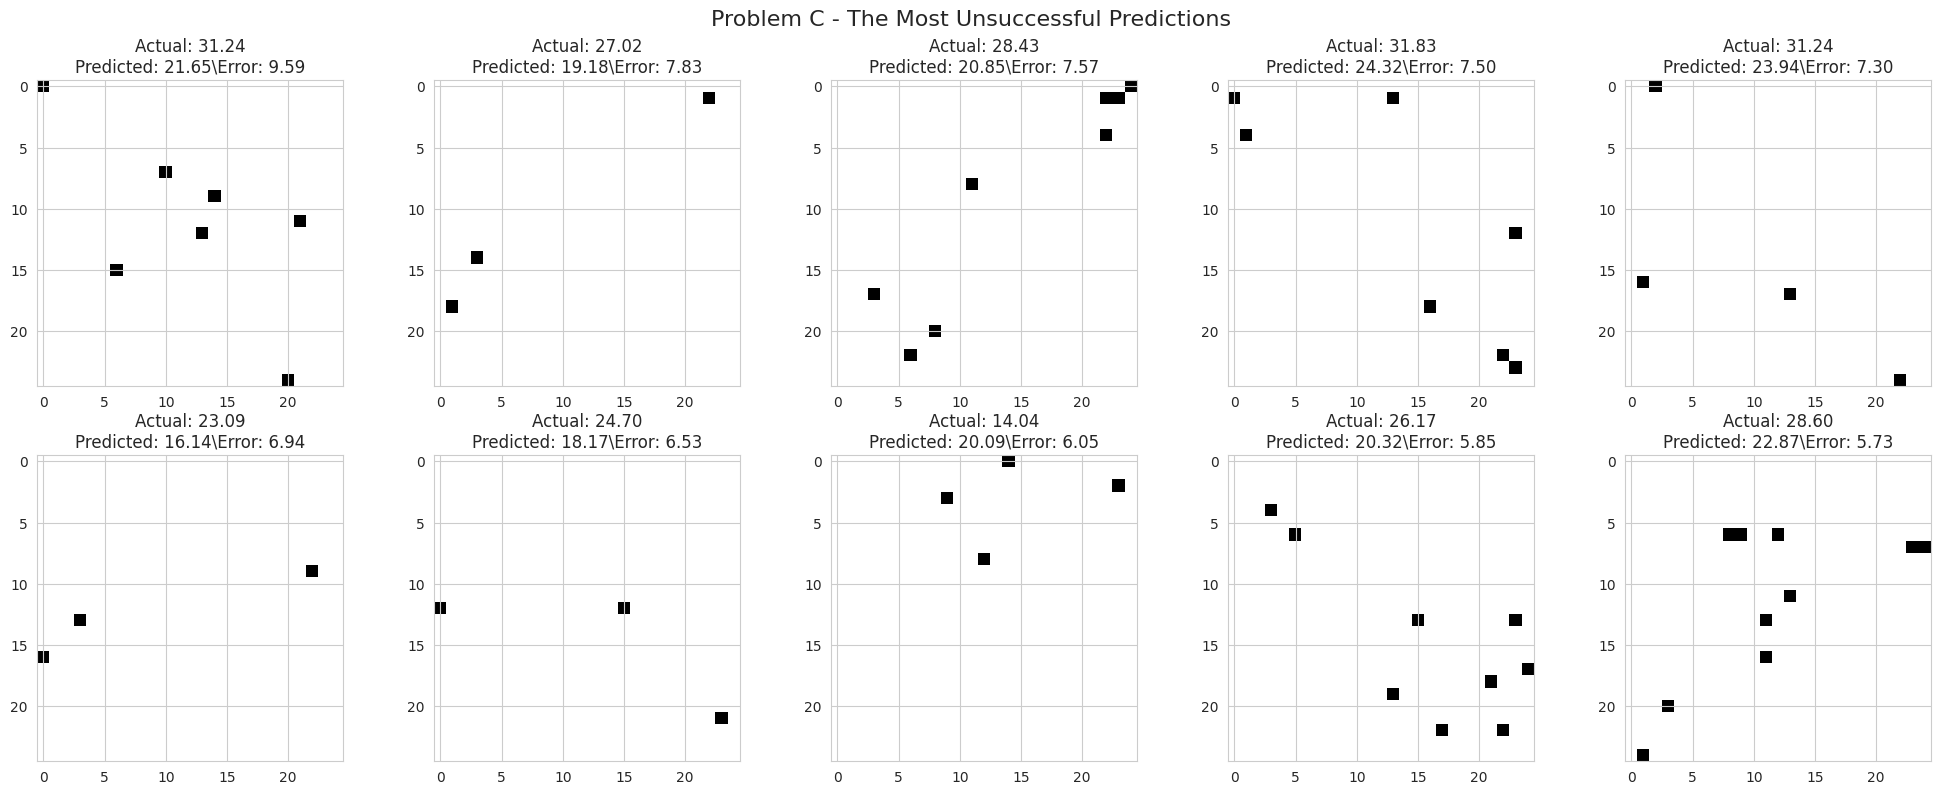

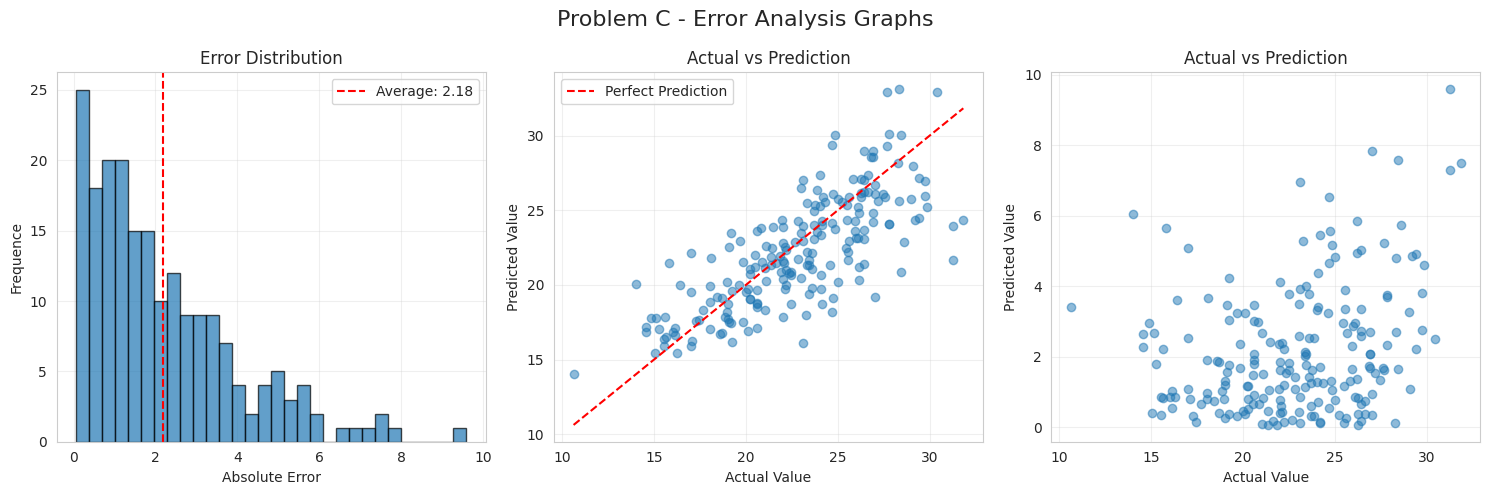


Error Analysis for Problem D
Model yüklendi: models/problem_D_full_best.h5



Test Set Performance Metrics:
  MAE: 0.1798
  MSE: 0.0601
  RMSE: 0.2451
  Average Relative Error: 4.15%

--- En Başarılı 10 Tahmin ---


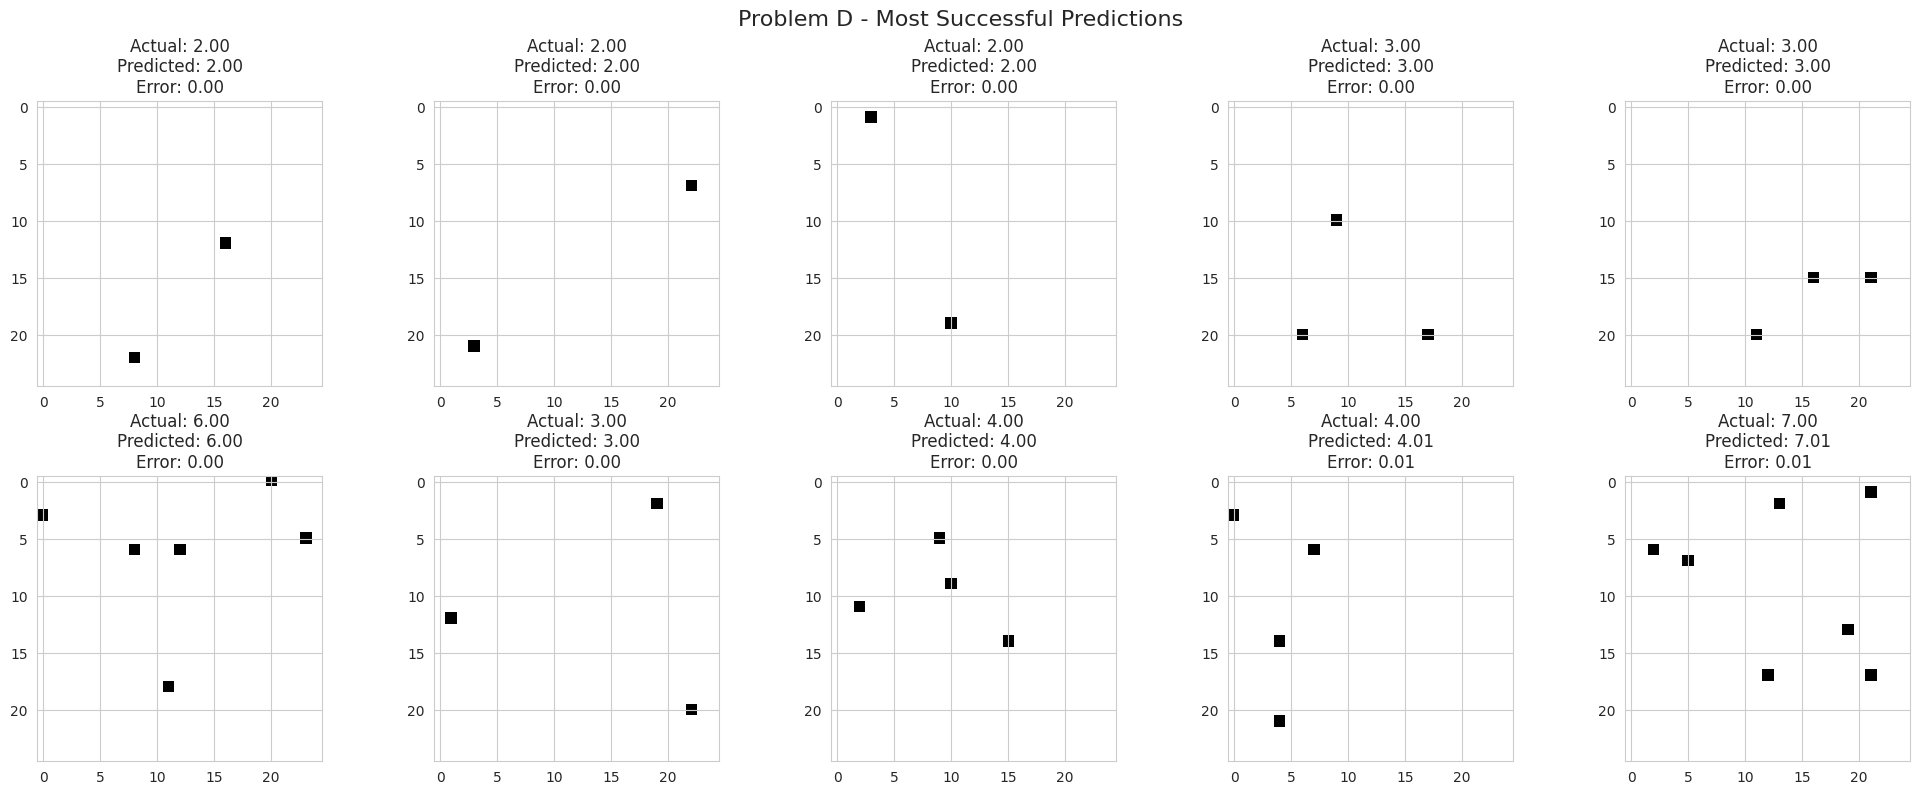


--- The Most Unsuccessful 10 Prediction ---


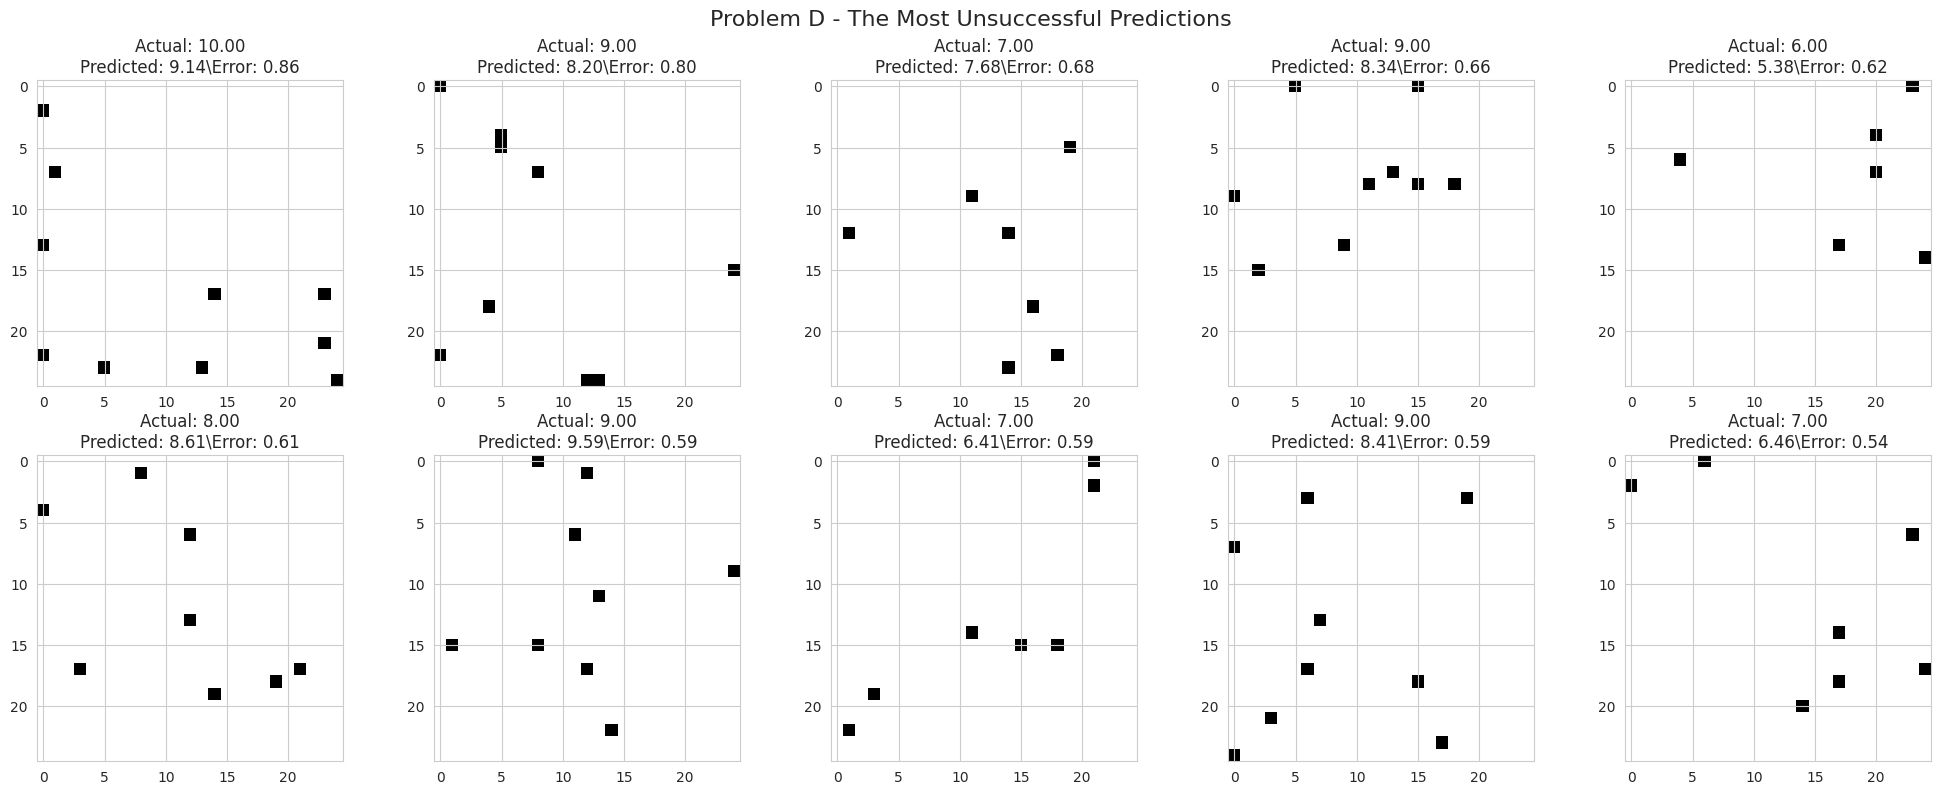

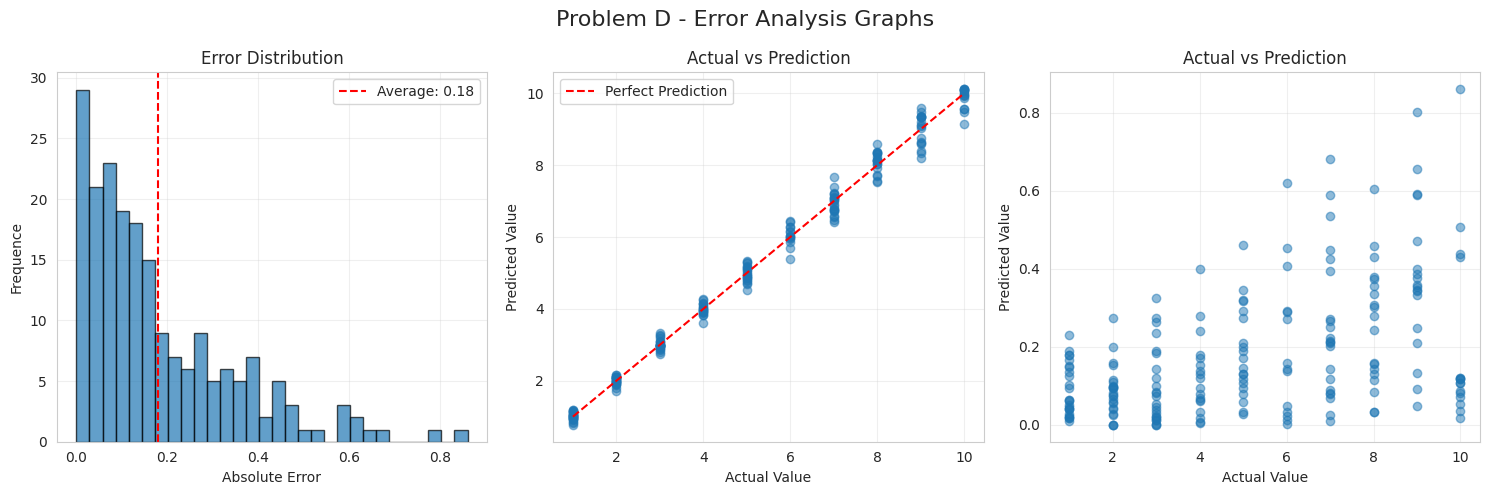


--- Special Analysis of Counting Problem (Problem D) ---
After rounding MAE: 0.0550
Absolute correct prediction rate: 94.50%

Average error by number:
  For number 1: 0.089 (n=25)
  For number 2: 0.085 (n=24)
  For number 3: 0.097 (n=24)
  For number 4: 0.124 (n=18)
  For number 5: 0.186 (n=20)
  For number 6: 0.207 (n=14)
  For number 7: 0.252 (n=22)
  For number 8: 0.259 (n=19)
  For number 9: 0.375 (n=18)
  For number 10: 0.205 (n=16)

Error Analysis for Problem E
Model yüklendi: models/problem_E_full_best.h5

Test Set Performance Metrics:
  MAE: 0.6374
  MSE: 0.7828
  RMSE: 0.8848
  Average Relative Error: 13.78%

--- En Başarılı 10 Tahmin ---


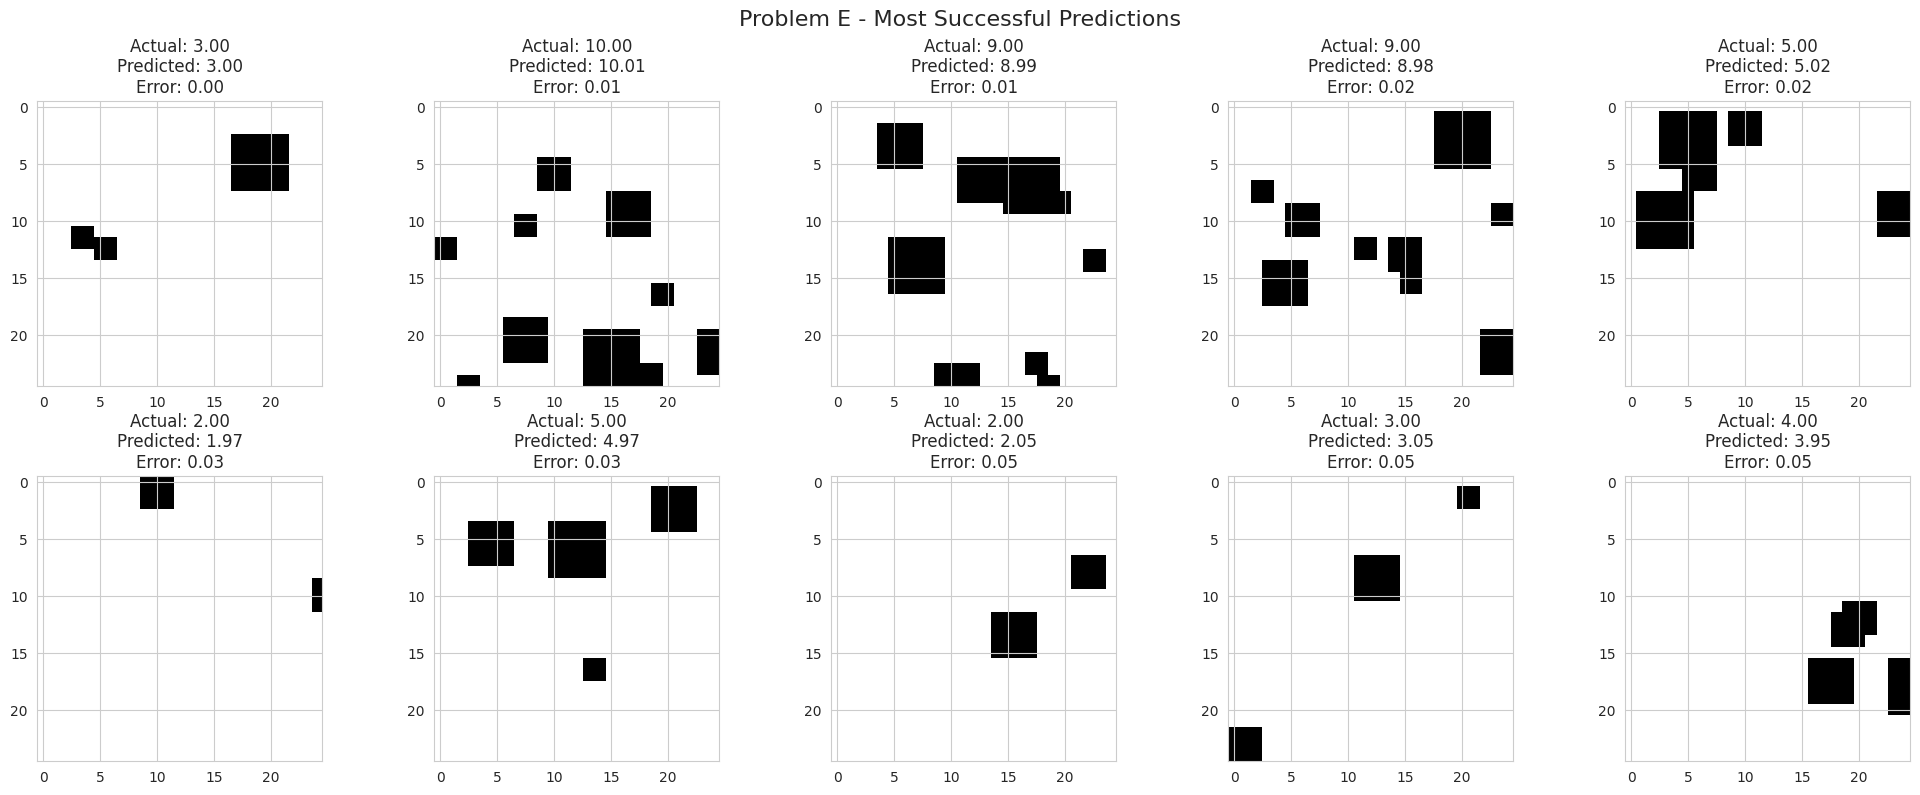


--- The Most Unsuccessful 10 Prediction ---


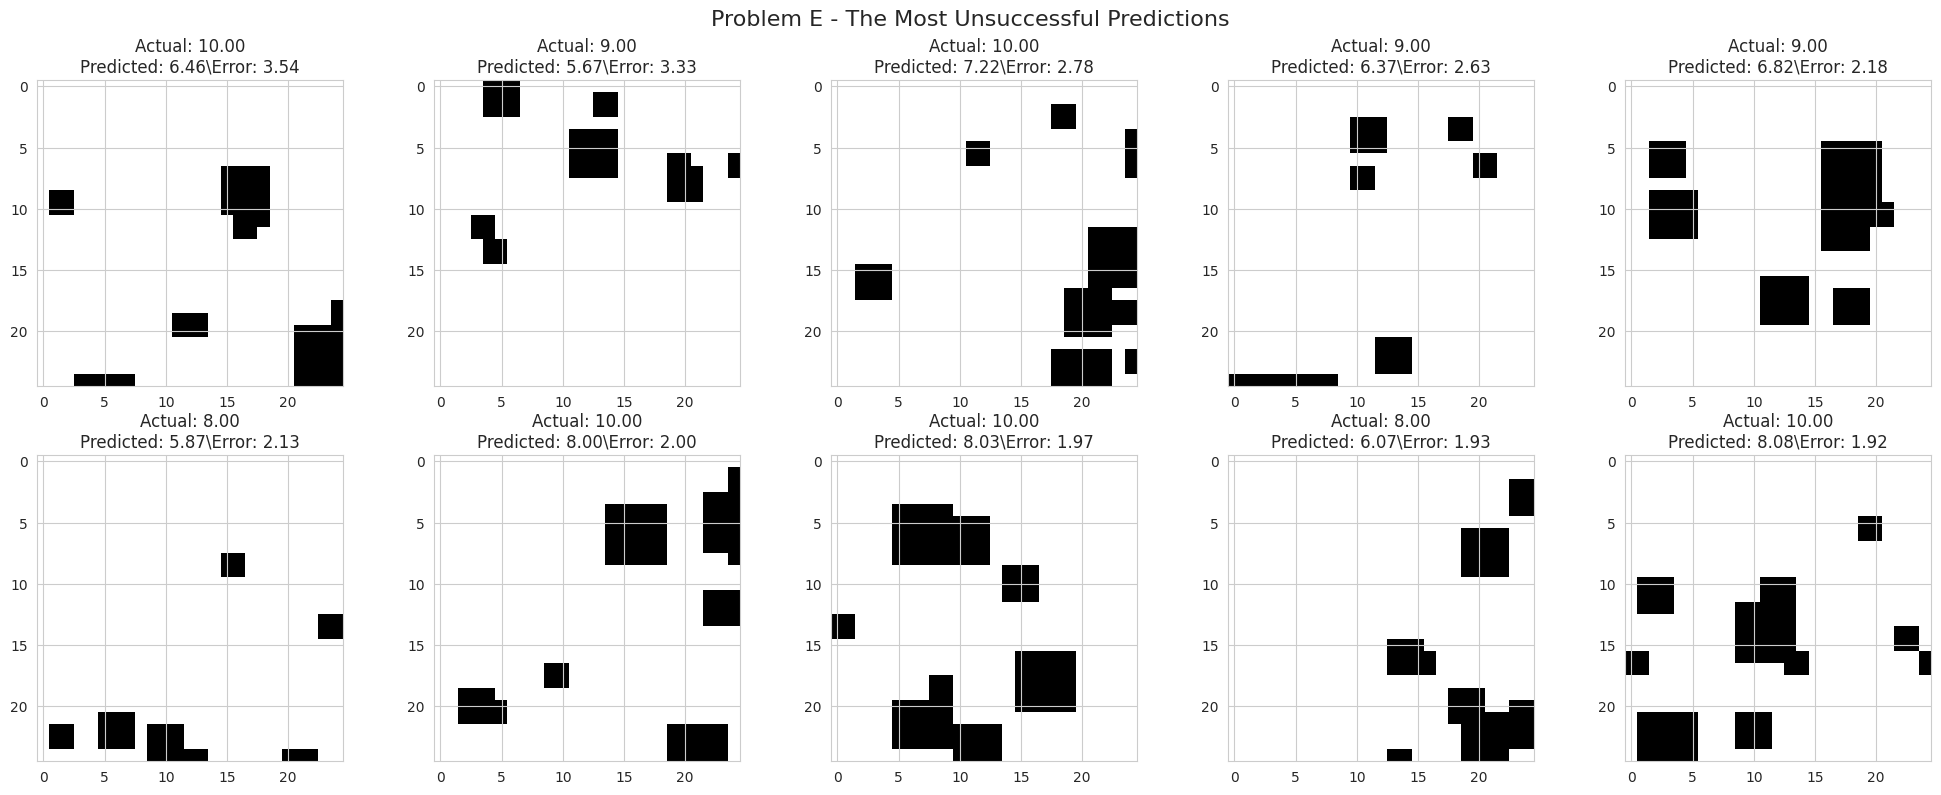

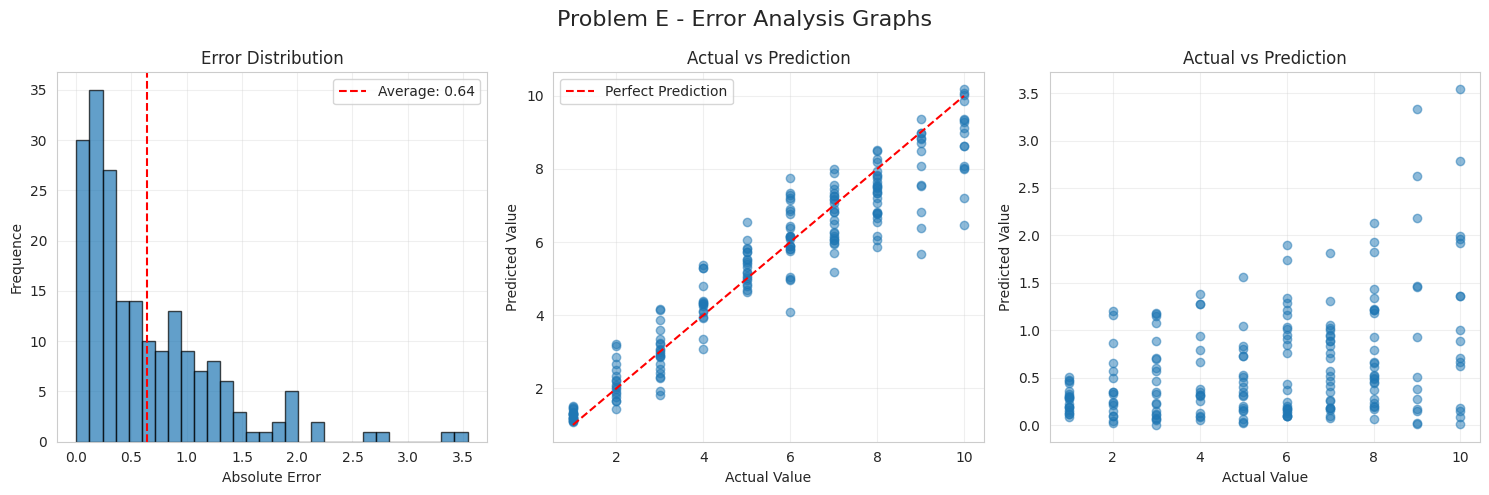


--- Special Analysis of Counting Problem (Problem E) ---
After rounding MAE: 0.5500
Absolute correct prediction rate: 55.00%

Average error by number:
  For number 1: 0.271 (n=20)
  For number 2: 0.417 (n=17)
  For number 3: 0.486 (n=21)
  For number 4: 0.539 (n=16)
  For number 5: 0.470 (n=20)
  For number 6: 0.664 (n=25)
  For number 7: 0.635 (n=25)
  For number 8: 0.798 (n=27)
  For number 9: 1.038 (n=13)
  For number 10: 1.203 (n=16)


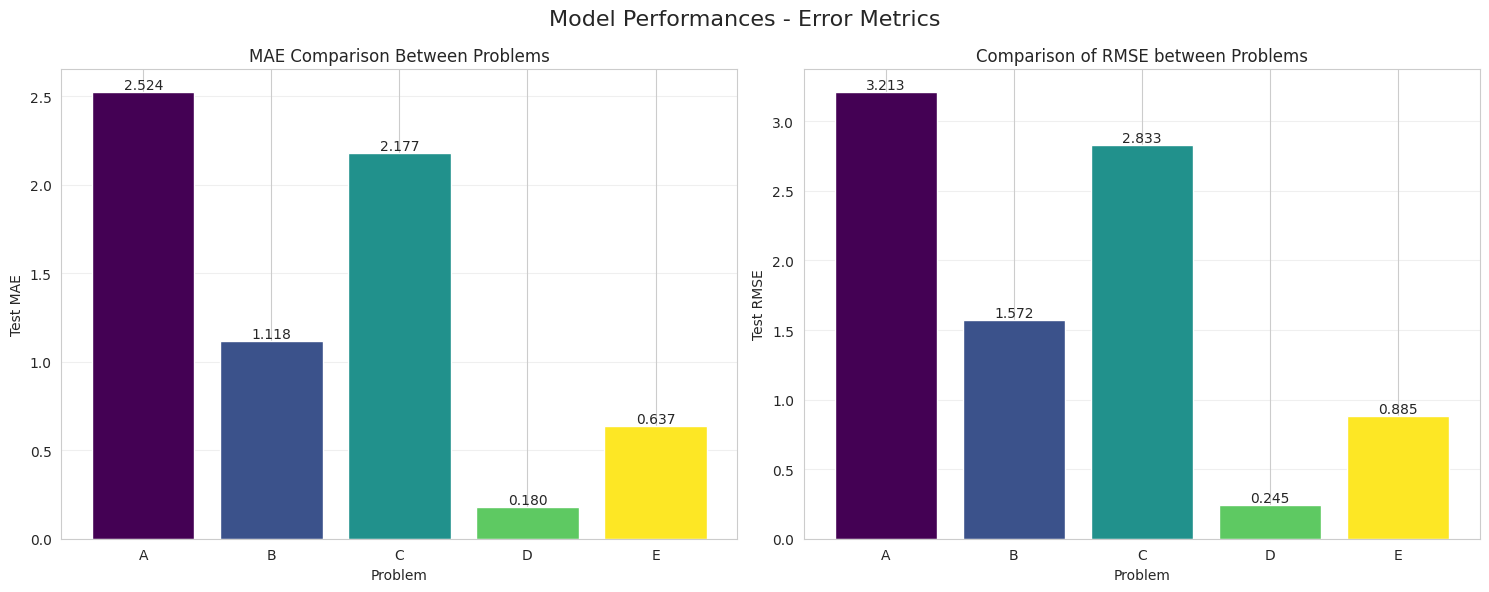

In [28]:
def perform_error_analysis(problem, model_path, num_examples=10):
    """
    Performs error analysis for a specific problem.

    This function finds, visualizes, and analyzes the model's best
    and worst predictions. It is critical to understanding what the
    model has learned and what it has not learned.

    Args:
        problem: 'A', 'B', 'C', 'D', 'E'
        model_path
        num_examples: default: 10

    Returns:
        analysis_results
    """
    print(f"\n{'='*60}")
    print(f"Error Analysis for Problem {problem}")
    print(f"{'='*60}")

    X_test = np.load(f"data/problem_{problem}_X_test.npy")
    y_test = np.load(f"data/problem_{problem}_y_test.npy")
    X_test_prepared, _ = prepare_data_simple(X_test, y_test)

    try:
        custom_objects = {
            'mse': MeanSquaredError(),
            'mae': MeanAbsoluteError()
        }
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        print(f"Model yüklendi: {model_path}")
    except Exception as e:
        print(e)
        traceback.print_exc()
        return None
    y_pred = model.predict(X_test_prepared, verbose=0).flatten()

    errors = np.abs(y_test - y_pred)
    relative_errors = errors / (y_test + 1e-8)

    mae = np.mean(errors)
    mse = np.mean((y_test - y_pred)**2)
    rmse = np.sqrt(mse)

    print(f"\nTest Set Performance Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Average Relative Error: {np.mean(relative_errors):.2%}")

    best_indices = np.argsort(errors)[:num_examples]
    worst_indices = np.argsort(errors)[-num_examples:][::-1]

    problem_descriptions = {
        'A': "Prection of distance between two points",
        'B': "Prediction of distance between two closest points",
        'C': "Prediction of the distance between the two furthest points",
        'D': "Prediction of number of points",
        'E': "Frame count prediction"
    }

    analysis_results = {
        'problem': problem,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mean_relative_error': np.mean(relative_errors),
        'best_predictions': [],
        'worst_predictions': []
    }

    print(f"\n--- En Başarılı {num_examples} Tahmin ---")
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, idx in enumerate(best_indices[:10]):
        ax = axes[i]
        ax.imshow(X_test[idx], cmap='binary')
        ax.set_title(f"Actual: {y_test[idx]:.2f}\nPredicted: {y_pred[idx]:.2f}\nError: {errors[idx]:.2f}")
        ax.grid(True)
        ax.axis('on')

        analysis_results['best_predictions'].append({
            'index': idx,
            'true': y_test[idx],
            'pred': y_pred[idx],
            'error': errors[idx]
        })

    plt.suptitle(f"Problem {problem} - Most Successful Predictions", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"training_results/problem_{problem}_best_predictions.png")
    plt.show()

    print(f"\n--- The Most Unsuccessful {num_examples} Prediction ---")
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, idx in enumerate(worst_indices[:10]):
        ax = axes[i]
        ax.imshow(X_test[idx], cmap='binary')
        ax.set_title(f"Actual: {y_test[idx]:.2f}\nPredicted: {y_pred[idx]:.2f}\Error: {errors[idx]:.2f}")
        ax.grid(True)
        ax.axis('on')

        analysis_results['worst_predictions'].append({
            'index': idx,
            'true': y_test[idx],
            'pred': y_pred[idx],
            'error': errors[idx]
        })

    plt.suptitle(f"Problem {problem} - The Most Unsuccessful Predictions", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"training_results/problem_{problem}_worst_predictions.png")
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(mae, color='red', linestyle='--', label=f'Average: {mae:.2f}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequence')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(132)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Actual vs Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(133)
    plt.scatter(y_test, errors, alpha=0.5)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Actual vs Prediction')
    plt.grid(True, alpha=0.3)

    plt.suptitle(f"Problem {problem} - Error Analysis Graphs", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"training_results/problem_{problem}_error_analysis.png")
    plt.show()

    if problem in ['D', 'E']:
        print(f"\n--- Special Analysis of Counting Problem (Problem {problem}) ---")

        y_pred_rounded = np.round(y_pred)
        rounded_errors = np.abs(y_test - y_pred_rounded)
        rounded_mae = np.mean(rounded_errors)

        print(f"After rounding MAE: {rounded_mae:.4f}")
        print(f"Absolute correct prediction rate: {np.mean(rounded_errors == 0):.2%}")

        unique_counts = np.unique(y_test)
        print("\nAverage error by number:")
        for count in unique_counts:
            mask = y_test == count
            if np.sum(mask) > 0:
                count_mae = np.mean(errors[mask])
                print(f"  For number {int(count)}: {count_mae:.3f} (n={np.sum(mask)})")

        analysis_results['counting_analysis'] = {
            'rounded_mae': rounded_mae,
            'exact_accuracy': np.mean(rounded_errors == 0),
            'count_wise_mae': {int(count): np.mean(errors[y_test == count]) for count in unique_counts}
        }

    return analysis_results

def analyze_all_problems():
    """
    Performs error analysis for all problems and combines the results.

    This function performs a comprehensive error analysis using models
    trained on the full dataset for each problem.

    Returns:
        all_analyses
    """
    all_analyses = {}

    for problem in ['A', 'B', 'C', 'D', 'E']:
        model_path = f"models/problem_{problem}_full_best.h5"
        analysis = perform_error_analysis(problem, model_path)
        all_analyses[problem] = analysis

    return all_analyses

print("Hata analizi başlatılıyor...")
all_analyses = analyze_all_problems()


def plot_error_comparison(all_analyses):
    """Creates a graph comparing error metrics of all problems."""

    problems = []
    maes = []
    rmses = []

    for problem, analysis in all_analyses.items():
        problems.append(problem)
        maes.append(analysis['mae'])
        rmses.append(analysis['rmse'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(problems)))
    bars1 = ax1.bar(problems, maes, color=colors)
    ax1.set_xlabel('Problem')
    ax1.set_ylabel('Test MAE')
    ax1.set_title('MAE Comparison Between Problems')
    ax1.grid(True, axis='y', alpha=0.3)

    for bar, mae in zip(bars1, maes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{mae:.3f}', ha='center', va='bottom')

    bars2 = ax2.bar(problems, rmses, color=colors)
    ax2.set_xlabel('Problem')
    ax2.set_ylabel('Test RMSE')
    ax2.set_title('Comparison of RMSE between Problems')
    ax2.grid(True, axis='y', alpha=0.3)

    for bar, rmse in zip(bars2, rmses):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{rmse:.3f}', ha='center', va='bottom')

    plt.suptitle('Model Performances - Error Metrics', fontsize=16)
    plt.tight_layout()
    plt.savefig('training_results/error_metrics_comparison.png')
    plt.show()

if all_analyses:
    plot_error_comparison(all_analyses)